# Technical Appendix - TARIFFSIMULATION

## A1. Computing Environment & Reproducibility

### A1.1 Python & OS

* **Recommended Python:** 3.10–3.12
* **Tested OS:** macOS 14 / Windows 11 / Ubuntu 22.04

### A1.2 Key Packages (minimum versions)

A list of key packages and their minimum versions.

* `numpy>=1.24`
* `pandas>=2.0`
* `matplotlib>=3.7`
* `seaborn>=0.13`
* `scikit-learn>=1.3`
* `statsmodels>=0.14`
* `holidays>=0.35`
* `joblib>=1.3`
* `requests>=2.31`
* `python-dateutil>=2.8`
* `tqdm>=4.66`
* `prophet>=1.1` *(optional; guarded import)*
* `tensorflow>=2.13` *(optional; only for LSTM; guarded import)*
* `pymc>=5.10`
* `arviz>=0.16`
* `pytorch-tabnet>=4.1` *(optional; advanced tabular model; not required to reproduce core results)*

> If you cannot install optional libraries, the notebook degrades gracefully (Prophet/LSTM/TabNet steps are skipped with warnings). This preserves the core pipeline (data, tariff pricing, classical ML).

### A1.3 Recreating the Environment

**Conda (recommended)**

Example commands to set up the environment:

1.  Create the conda environment:
    `conda create -n tariffsim python=3.11 -y`
2.  Activate the environment:
    `conda activate tariffsim`
3.  Install packages:
    `pip install -r requirements.txt`

If you don’t keep a `requirements.txt`, install the packages above with `pip`.

### A1.4 Randomness & Seeds

* Load-profile simulation: `np.random.seed(52)`
* ML/Clustering CV and splits: `random_state=42` consistently
* PyMC MCMC uses its own RNG streams per chain (reproducible across runs on the same versions).

### A1.5 How to Run

**Option 1 – Jupyter:** open `TariffSimulation.ipynb` → “Run All”.

**Option 2 – Script:**

1.  Convert the notebook to a script:
    `jupyter nbconvert --to script TariffSimulation.ipynb`
2.  Run the script with a path to the CSV:
    `python TariffSimulation.py --csv /path/to/serl_aggregated.csv`
3.  Alternatively, use an environment variable:
    `export ERP_DSM_CSV=/path/to/serl_aggregated.csv`
    `python TariffSimulation.py`

The script entrypoint wires the full pipeline (transform → inspect → model → forecast → cluster → simulate tariffs). The CLI resolves the CSV in this order: `--csv` → `ERP_DSM_CSV` → project default path; otherwise it raises a clear `FileNotFoundError`.

> Per your ERP guidance, the appendix may host code, data schemas, and run-instructions to enable reproducibility; critical interpretation remains in the report body.

---

## A2. Data Sources & Schemas

### A2.1 SERL Aggregated CSV (Domestic Buildings, 2020–2023)

The pipeline expects a SERL-style aggregated dataset with columns including (illustrative, subset):

* **Targets/aggregates:** `mean` (primary usage measure by period)
* **Temporal:** `aggregation_period` (timestamp or period label)
* **Context:** `quantity` (e.g., “Electricity” / “Gas”), `unit` (kWh),
    `segment_1_value` (space-heating fuel), `segment_2_value` (PV: Yes/No)
* **Weather:** `mean_temp`, `mean_solar`, `mean_hdd`
* **Other:** `summary_time`, `standard_error_mean`, segmentation helpers

#### Cleaning & Renaming

The `DataTransformer` performs:

* **Drop** high-missing columns and known non-essentials:
    `segmentation_variable_1`, `segmentation_variable_2`, `standard_error_mean`, `summary_time`.
* **Rename** to standardize:
    `segment_1_value` → `primary_space_heating_fuel`, `segment_2_value` → `has_pv`.
* **Type conversions:** parse `aggregation_period` to datetime if needed; create derived temporal fields.
* **Encoding:**
    * One-hot: `quantity_*`, `unit_*`, `fuel_*`
    * Binary maps: `has_pv` → `has_pv_enc ∈ {0,1}`, `weekday_weekend` → `is_weekend ∈ {0,0.5,1}`
* **Temporal features:**
    `aggregation_period_minutes`, cyclic encodings `time_sin`, `time_cos`, and `lag_24h` (if present)
* **Scaling:** min-max / standard scaling of numeric features where configured.

**ML feature set (`prepare_ml_data`)** (keeps those present):
`mean_temp`, `mean_solar`, `has_pv_enc`, `is_weekend`, `lag_24h`, `fuel_*`, `quantity_*`, `unit_*`, `aggregation_period_minutes`, `time_sin`, `time_cos`.

### A2.2 Octopus Agile Tariff API (Half-Hourly Unit Rates)

Used to price consumption at half-hour or 15-minute granularity.

* **Tariff code format:** `E-1R-{PRODUCT_CODE}-{REGION}`; defaults in the notebook:
    `PRODUCT_CODE="AGILE-24-10-01"`, `REGION="C"` (Manchester area exemplar).
* **Endpoint shape (v1):** `/v1/products/{product_code}/electricity-tariffs/{tariff_code}/standard-unit-rates/`
* **Query params:** `period_from`, `period_to` (UTC ISO), `page_size=250`, `order_by=period`.
* **Response fields used:** `valid_from` (UTC), `value_inc_vat` (p/kWh).
* **Standing charge:** default **£0.5485/day** (configurable).

**Resilience:** `_fetch_and_prepare_rates()` paginates via `next`, retries on 5xx, and falls back to a local `agile_backup.json` if network requests fail.

> No authentication is required for public Agile rates. Respect API usage limits; results are cached to JSON for reproducibility.

### A2.3 UK Holidays

`holidays.UnitedKingdom()` can be used (optionally) to generate holiday indicators for feature engineering.

---

## A3. Time Handling & Alignment

* Input `timestamp`s are assumed **Europe/London** (naïve timestamps are localized to Europe/London).
* All **API rate timestamps** arrive in UTC. The calculator converts consumption timestamps to UTC and builds a key `period_start = timestamp.strftime("%Y-%m-%dT%H:%M:%S")` to map each interval to its unit rate.
* Daily grouping uses the **local UK calendar date** (`Europe/London`) so totals and standing charges align with consumer bills.

---

## A4. Tariff Costing: Formulas & Windows

For each interval $i$:

* **Unit rate** $r_i$ in **£/kWh** (API `value_inc_vat / 100`).
* **Consumption** $q_i$ in **kWh**.
* **Interval energy cost** $c_i = q_i \cdot r_i$.

Daily totals:

$$
\text{Cost}_d = \sum_{i \in d} c_i \quad,\quad
\text{TotalCost}_d = \text{Cost}_d + \text{StandingCharge}
$$

**Cheapest charging window (e.g., 4 hours):** computed by sliding-sum of `cost` over contiguous windows (e.g., 16 × 15-min intervals), returning start/end times and average rate over the window.

---

## A5. Load-Profile Simulation (for scenario tests)

`TariffSimulator` generates a stylized half-hour (or 15-minute) daily profile with morning/evening peaks and Monte-Carlo variability:

* Base shape (sinusoid + peaks), normalized to a target daily energy (default ≈ **24 kWh/day**).
* **Monte-Carlo:** $\tilde{q}_i = \max\{0, q_i \cdot (1 + \epsilon_i)\}$, with $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$; default `std_dev=0.2`.
* Used to visualize interval pricing exposure and to stress-test tariff windows.

---

## A6. Statistical & ML Modelling

### A6.1 General Regression (`EnergyModeler`)

* **Split:** stratified random or time-aware (if `time_series=True`), with warnings for *n*<50.
* **Preprocessing pipeline:** numeric imputer + scaler; categorical `OneHotEncoder(handle_unknown="ignore")`.
* **Model registry (examples):** `LinearRegression`, `RandomForestRegressor`, `GradientBoostingRegressor`, `HistGradientBoostingRegressor` (TabNet optional).
* **Evaluation:** cross-validation (`cv=k` or `TimeSeriesSplit`), metrics logged (R², MAE, MSE).
* **Model selection:** best by configurable metric (default “Test R²”).
* **Interpretability:** tree-based `feature_importances_`; optional **SHAP** plots for local/global explanations.
* **Export:** results to CSV/Markdown; models via `joblib`.

### A6.2 Bayesian Linear Model (Gas)

Filtered subset: `quantity == "Gas"` and `has_pv == "No"`. Predictors: `mean_temp`, `mean_hdd`, `mean_solar`. Let $y$ be mean gas usage:

$$
\begin{aligned}
y &\sim \mathcal{N}(\mu, \sigma), \\
\mu &= \alpha + \beta_{\text{temp}} \cdot \text{mean\_temp} + \beta_{\text{hdd}} \cdot \text{mean\_hdd} + \beta_{\text{solar}} \cdot \text{mean\_solar}.
\end{aligned}
$$

**Priors:**
$\alpha \sim \mathcal{N}(0,10)$;
$\beta_{\*} \sim \mathcal{N}(0,1)$;
$\sigma \sim \text{HalfNormal}(10)$.

**Inference:** PyMC `sample(draws=1000, tune=500, chains=2, target_accept=0.95)`. Diagnostics include trace plots, ACF, posterior densities with 90% HDI, and posterior predictive checks.

### A6.3 Forecasting (`Forecaster`)

* **ARIMA(1,1,1):** daily series (`asfreq('D')`), forecasts horizon $H$ (default 7 days).
* **Prophet:** weekly seasonality enabled; optional if installed.
* **LSTM (optional):** single-step recursive to horizon $H$, with early stopping.
* **Outputs:** `forecast_df` (columns `ARIMA`, `Prophet`, `LSTM` where available), `runtime_df` (seconds), and `error_df` if ground truth exists (MAE/RMSE/MAPE).

### A6.4 Clustering (`ConsumptionClusterer`)

* **Features:** user-selected numeric columns (e.g., daily mean, variance, peak/off-peak ratios).
* **K-Means:** `n_init=10` with elbow plot to select $k$.
* **PCA (2D)** for visualization of cluster separation.

---

## A7. Data Validation & Diagnostics

* **`DataInspector` summary:** schema, dtypes, duplicates, missingness (%), numerical stats.
* **Distribution plots:** histograms with KDEs, outlier detection via IQR fences.
* **Categorical checks:** top-k category distributions.

---

## A8. Assumptions, Limitations & Sensitivity

* **Data level:** SERL file is aggregated; individual household heterogeneity is not modelled directly.
* **Imputation:** missing engineered features are zero-filled where necessary (documented via warnings).
* **Temporal resolution:** tariff prices are half-hourly; a 15-minute series is priced by aligning to the appropriate rate (or by first aggregating), consistent with the API’s period definition.
* **Region & product:** defaults (`REGION="C"`, `AGILE-24-10-01`) are illustrative; change to your DNO region & product as needed.
* **Standing charge:** fixed per day; adjust for your tariff.
* **Forecasting:** LSTM/Prophet are minimal baselines (not exhaustively tuned).
* **Bayesian model:** linear-Gaussian; heavy-tailed residuals or non-linearities are not modeled here.
* **Sensitivity levers:** Monte-Carlo `std_dev`, charging window length, model hyperparameters, cross-validation folds, and target horizon $H$.

---

## A9. Outputs & Artifacts

* **Transformed ML dataset:** `ml_ready.csv` (if enabled by the transformer section).
* **Model results:** Markdown/CSV leaderboard with CV metrics; saved estimators via `joblib` (optional).
* **Figures:** distribution plots, elbow chart, PCA clusters, forecast overlays, tariff and consumption time-series, optimal charging window highlight.
* **API cache:** `agile_backup.json` to allow fully offline re-runs of the costing step.

> Include these artifacts with your submission as “supporting materials” to strengthen reproducibility, as recommended by the ERP handbook.

---

## A10. Configuration Summary (Notebook Classes)

* **`DataTransformer`**: cleaning, renaming, encoding, temporal features, scaling; `prepare_ml_data(target='mean')`.
* **`DataInspector`**: structure, stats, missingness, distributions, categorical summaries.
* **`TariffCalculator`**: timezone normalization (UK→UTC), Agile API fetch with pagination/retries, daily cost aggregation with standing charge, summary prints.
* **`TariffPlotter`**: interval rate vs. cost, daily totals (expects columns `['date','total_cost']`), consumption profile plot, rolling-window optimal charging suggestion.
* **`EnergyModeler`**: model registry, preprocessing pipeline, CV evaluation, feature importance, SHAP, exporting.
* **`ConsumptionClusterer`**: elbow method, K-Means, PCA visualization.
* **`Forecaster`**: ARIMA/Prophet/LSTM baselines, run-time tracking, error metrics, plotting.

---

## A11. Ethical, Licensing & Data Management Notes

* **Data:** uses aggregated statistics; no personal data are processed. If you extend with granular sources, re-check ethical approvals and data agreements.
* **API:** Octopus Agile rates are public; attribute Octopus Energy as the tariff source when presenting prices.
* **Versioning:** record package versions and the commit hash (if using Git) in your submission.
* **Backups:** the pipeline caches tariff responses; include `agile_backup.json` for offline verification.

> The handbook permits appendices to include code, data descriptions, and additional outputs intended for verification; key findings and arguments should remain in the main report.

---

## A12. Glossary of Variables (selected)

* `mean`: primary aggregated consumption metric (target).
* `quantity`, `unit`: energy type & units (one-hot encoded).
* `primary_space_heating_fuel`: heating fuel (one-hot to `fuel_*`).
* `has_pv`, `has_pv_enc`: PV presence (raw/binary).
* `mean_temp`, `mean_hdd`, `mean_solar`: weather covariates.
* `aggregation_period`: timestamp; derived `aggregation_period_minutes`, `time_sin`, `time_cos`.
* `lag_24h`: prior-day lag feature if available.
* `unit_rate_gbp_per_kwh`: Agile unit rate per interval (from API).
* `cost_energy_gbp`, `total_cost_gbp`: interval energy cost and daily total with standing charge.


In [1]:
# ╔════════════════════════════════════════════════════════════════════════╗
# ║                        PROJECT STRUCTURE OVERVIEW                      ║
# ╚════════════════════════════════════════════════════════════════════════╝
# This project builds an end-to-end pipeline for analyzing, simulating,
# and evaluating domestic energy consumption under various tariff schemes.
# The system integrates data engineering, ML forecasting, cost modeling,
# and visualization into a modular structure.

# Each component can be developed, tested, and extended independently.

# ─────────────────────────────────────────────────────────────────────────

# 1. RawDataLoader (currently inline, can be modularized)
#    ---------------------------------------------------
#    - Loads daily aggregated energy consumption data from CSV.
#    - Validates file format, handles file exceptions and parsing issues.
#    - Suggestion: abstract into a class with schema checks + metadata log.

# 2. DataInspector
#    --------------
#    - Performs exploratory data analysis (EDA):
#        - Trend, seasonality, and consumption distribution
#        - Calendar-based features (e.g. holidays, weekdays)
#        - Missing value reports, zero-value detection
#    - May include early plotting: heatmaps, time plots, KDE.

# 3. DataCleaner
#    ------------
#    - Handles missing values, outliers, and datatype normalization.
#    - Optionally applies:
#        - Interpolation
#        - Rolling window smoothing
#        - Imputation strategies
#    - Aligns timestamps and filters corrupted data ranges.

# 4. FeatureEngineer
#    ----------------
#    - Creates features like:
#        - Day of week, month, season
#        - Holiday indicator, lag features
#        - Rolling means, cumulative usage
#        - Categorical encodings
#    - Scales or transforms features where needed (e.g. log-scale, z-score).

# 5. TariffSimulator
#    ----------------
#    - Simulates how energy is consumed under synthetic or historical tariffs.
#    - Could include:
#        - Time-of-use modeling
#        - Seasonal variation in demand
#        - User behavioral patterns
#    - May connect with household profiles or region-specific adjustments.

# 6. TariffCalculator
#    -----------------
#    - Computes energy cost under:
#        - Flat rates
#        - TOU (Time-of-Use)
#        - Dynamic pricing models
#    - Capable of bulk simulation across multiple tariff structures.
#    - Outputs comparative cost estimates per household or segment.

# 7. TariffPlotter
#    --------------
#    - Visualizes:
#        - Energy usage over time
#        - Cost breakdown by tariff
#        - Tariff comparison charts
#        - Cluster heatmaps or savings distributions
#    - Uses Matplotlib and Seaborn with custom themes and consistent styling.

# 8. EnergyModeler
#    --------------
#    - Trains time series and regression models:
#        - Prophet
#        - ARIMA
#        - LSTM (Keras)
#        - Random Forest, Gradient Boosting
#    - Compares forecast accuracy via metrics (MAE, RMSE, R²).
#    - Optionally uses Optuna or GridSearch for tuning.

# 9. ClusterAnalyzer
#    ----------------
#    - Performs clustering on household usage patterns:
#        - KMeans, PCA, t-SNE
#    - Identifies behavioral archetypes (e.g. high night-use consumers).
#    - Used for targeting or pricing strategy personalization.

# 10. ReportGenerator (optional but useful)
#     -------------------------------------
#     - Generates summary tables, charts, and outputs.
#     - Saves results to disk (PDF, HTML, or JSON).
#     - Prepares insights for stakeholders or decision-makers.

# ─────────────────────────────────────────────────────────────────────────

# ➤ Suggested Directory Layout (if modularized):
#
# project/
# ├── data/
# │   └── raw/
# ├── notebooks/
# ├── src/
# │   ├── loader/
# │   ├── inspection/
# │   ├── cleaning/
# │   ├── features/
# │   ├── simulation/
# │   ├── modeling/
# │   ├── evaluation/
# │   ├── clustering/
# │   └── visualization/
# └── outputs/
#     ├── plots/
#     ├── reports/
#     └── models/


In [2]:
# ╔════════════════════════════════════════════╗
# ║             STANDARD LIBRARY IMPORTS       ║
# ╚════════════════════════════════════════════╝
import json
import logging
import os
import re
import sys
import time
import requests
import warnings
from pathlib import Path
from typing import Dict, Optional, Self, Tuple, Union

# ╔════════════════════════════════════════════╗
# ║           THIRD-PARTY LIBRARY IMPORTS      ║
# ╚════════════════════════════════════════════╝

# --- Core Data Handling ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# --- Preprocessing ---
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler
)

# --- Feature Engineering ---
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

# --- Modeling ---
from sklearn.base import clone, is_regressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
    cross_val_score,
    train_test_split
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# --- Time Series Models ---
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# --- Deep Learning ---
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.optimizers import Adam

# --- Clustering & Reduction ---
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Probabilistic Modeling ---
import pymc as pm
import arviz as az

# --- Optimization & Math ---
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

# --- Model Explainability ---
import shap

# --- Advanced ML ---
from pytorch_tabnet.tab_model import TabNetRegressor

# --- Utilities ---
import holidays
from holidays.countries.united_kingdom import UnitedKingdom
from dateutil.parser import parse
import joblib

# ╔════════════════════════════════════════════╗
# ║         PLOTTING CONFIGURATION             ║
# ╚════════════════════════════════════════════╝

# Matplotlib configuration
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 100,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Seaborn configuration
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='husl',
    font_scale=1.1
)

# ╔════════════════════════════════════════════╗
# ║         LOGGING CONFIGURATION              ║
# ╚════════════════════════════════════════════╝

try:
    import colorlog

    handler = colorlog.StreamHandler()
    handler.setFormatter(colorlog.ColoredFormatter(
        fmt="%(log_color)s[%(asctime)s] [%(levelname)s] %(name)s: %(message)s",
        log_colors={
            'DEBUG': 'cyan',
            'INFO': 'green',
            'WARNING': 'yellow',
            'ERROR': 'red',
            'CRITICAL': 'bold_red',
        },
        datefmt='%Y-%m-%d %H:%M:%S'
    ))
    logging.root.handlers = [handler]
    logging.root.setLevel(logging.INFO)

except ImportError:
    # Fallback to basic logging if colorlog is not installed
    logging.basicConfig(
        level=logging.INFO,
        format='[%(asctime)s] [%(levelname)s] %(name)s: %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[logging.StreamHandler(sys.stdout)]
    )

# ╔════════════════════════════════════════════╗
# ║           DATASET LOADING LOGIC            ║
# ╚════════════════════════════════════════════╝

# Path to input dataset
file_path = (
    "/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/"
    "data/csv/serl_daily_energy_use_in_gb_domestic_buildings_2020_to_2023_aggregated_statistics.csv"
)

# Attempt to load dataset
try:
    df = pd.read_csv(file_path)
    logging.info("Data loaded successfully.")

except FileNotFoundError:
    logging.critical(f"File not found: {file_path}")
    raise

except pd.errors.EmptyDataError:
    logging.critical("CSV file is empty.")
    raise

except pd.errors.ParserError as e:
    logging.critical(f"Error parsing CSV: {e}")
    raise

except Exception as e:
    logging.critical(f"Unexpected error occurred while loading data: {e}")
    raise

# ╔════════════════════════════╗
# ║ THEME: palette + typography║
# ╚════════════════════════════╝

# --- Brand colours (hex + reference metadata for your notes) ---
THEME = {
    "DARK_PINK":   {"hex": "#801650", "rgb": (128, 22, 80),  "cmyk": (0, 83, 38, 50)},
    "DARK_BLUE":   {"hex": "#12436D", "rgb": (18, 67, 109),  "cmyk": (83, 39, 0, 57)},
    "TURQUOISE":   {"hex": "#28A197", "rgb": (40, 161, 151), "cmyk": (75, 0, 6, 37)},
    "ORANGE":      {"hex": "#F46A25", "rgb": (244,106, 37),  "cmyk": (0, 57, 85, 4)},
    "DARK_GREY":   {"hex": "#3D3D3D", "rgb": (61, 61, 61),   "cmyk": (0, 0, 0, 76)},
    "LIGHT_PURPLE":{"hex": "#A285D1", "rgb": (162,133,209),  "cmyk": (22, 36, 0, 18)},
}

# Primary plotting cycle (professional, feminine-leaning order)
PALETTE = [
    THEME["DARK_PINK"]["hex"],
    THEME["DARK_BLUE"]["hex"],
    THEME["ORANGE"]["hex"],
    THEME["TURQUOISE"]["hex"],
    THEME["LIGHT_PURPLE"]["hex"],
    THEME["DARK_GREY"]["hex"],
]

def apply_serl_theme():
    """Apply Times New Roman + brand palette across Matplotlib/Seaborn + HTML headings."""
    import matplotlib as mpl  # Fix: ensure mpl is defined
    from IPython.display import HTML  # Fix: import HTML for notebook display
    # Matplotlib rcParams
    mpl.rcParams.update({
        # Typography
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "serif"],
        # Figure & axes
        "figure.facecolor": "#FFFFFF",
        "axes.facecolor": "#FFFFFF",
        "axes.edgecolor":  THEME["DARK_GREY"]["hex"],
        "axes.titleweight": "bold",
        "axes.titlesize": 16,
        "axes.labelsize": 12,
        "axes.titlecolor": "#000000",          # headings black
        "axes.labelcolor": THEME["DARK_GREY"]["hex"],
        "text.color":      THEME["DARK_GREY"]["hex"],
        # Grid
        "axes.grid": True,
        "grid.color": "#E6E6EE",
        "grid.alpha": 0.85,
        # Lines, legend
        "legend.frameon": False,
        "lines.linewidth": 2.0,
    })
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=PALETTE)

    # Seaborn theme (safe if seaborn is present)
    try:
        import seaborn as sns  # already imported in your file
        sns.set_theme(
            context="notebook",
            style="whitegrid",
            font="Times New Roman",
            rc={
                "axes.edgecolor": THEME["DARK_GREY"]["hex"],
                "axes.labelcolor": THEME["DARK_GREY"]["hex"],
                "text.color": THEME["DARK_GREY"]["hex"],
                "grid.color": "#E6E6EE",
            }
        )
        sns.set_palette(PALETTE)
    except Exception:
        pass

    # HTML headings → Times New Roman, black
    HTML("""
    <style>
      h1, h2, h3, h4, h5, h6 {
        font-family: 'Times New Roman', Times, serif !important;
        color: #000 !important;
      }
      /* Optional: small pill class matching the scheme */
      .pill {
        display:inline-block; padding:4px 10px; border-radius:14px;
        background:#F5F5F5; border:1px solid %s; color:%s;
      }
    </style>
    """ % (THEME["DARK_BLUE"]["hex"], THEME["DARK_GREY"]["hex"]))

# Call once near the start of your notebook:
apply_serl_theme()
print("[OK] Theme applied (Times New Roman + brand palette).")


[2025-09-01 01:59:52] [INFO] root: Data loaded successfully.


[OK] Theme applied (Times New Roman + brand palette).


In [3]:
# ╔════════════════════════════╗
# ║    DATA TRANSFORMATION     ║
# ╚════════════════════════════╝

class DataTransformer:
    """
    Encapsulates data cleaning and feature engineering tasks.
    The goal is to transform raw input into a tidy format suitable
    for machine learning and statistical analysis.

    Transformation Pipeline:
    1. Handle missing values
    2. Drop irrelevant columns
    3. Rename and type conversion
    4. Feature engineering
    5. Encoding categorical variables
    6. Temporal feature extraction
    7. Interaction terms and lag features
    8. Prepare ML data
    9. Summary visualization and reporting
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.logger = logging.getLogger(self.__class__.__name__)

    def clean(self) -> pd.DataFrame:
        """Clean the dataset by applying a series of preprocessing steps."""
        self._handle_missing_values(threshold=30.0)  # Default threshold set to 30%
        self._drop_unused_columns()
        self._rename_columns()
        self._convert_data_types()
        self.logger.info("Data cleaning complete")
        return self.df

    def _handle_missing_values(self, threshold: float = 30.0) -> None:
        """Drop columns that exceed the missing value threshold."""
        missing_pct = self.df.isnull().mean() * 100
        drop_cols = missing_pct[missing_pct > threshold].index.tolist()
        if drop_cols:
            self.df.drop(columns=drop_cols, inplace=True)
            self.logger.info(f"Dropped columns (> {threshold}% missing): {drop_cols}")

    def _drop_unused_columns(self) -> None:
        """Remove columns known to be irrelevant."""
        drop_cols = [
            'segmentation_variable_1',
            'segmentation_variable_2',
            'standard_error_mean',
            'summary_time'
        ]
        actual = [c for c in drop_cols if c in self.df.columns]
        if actual:
            self.df.drop(columns=actual, inplace=True)
            self.logger.info(f"Dropped unused columns: {actual}")

    def _rename_columns(self) -> None:
        """Rename cryptic or verbose columns to standardized names."""
        rename_map = {
            'segment_1_value': 'primary_space_heating_fuel',
            'segment_2_value': 'has_pv'
        }
        to_rename = {k: v for k, v in rename_map.items() if k in self.df.columns}
        if to_rename:
            self.df.rename(columns=to_rename, inplace=True)
            self.logger.info(f"Renamed columns: {to_rename}")

    def _convert_data_types(self) -> None:
        """Convert types for categorical and time fields."""
        if 'summary_time' in self.df.columns:
            self.df['summary_time'] = pd.to_datetime(
                self.df['summary_time'], format='%H:%M', errors='coerce'
            ).dt.time

        cat_cols = [
            'quantity', 'unit', 'weekday_weekend',
            'primary_space_heating_fuel', 'has_pv'
        ]
        for c in cat_cols:
            if c in self.df.columns:
                self.df[c] = self.df[c].astype('category')

    def engineer_features(self) -> pd.DataFrame:
        """Run full feature engineering pipeline."""
        self._encode_categoricals()
        self._handle_temporal_features()
        self._add_interaction_terms()
        self._add_lag_features()
        self.logger.info("Feature engineering complete")
        return self.df

    def _encode_categoricals(self) -> None:
        """Apply one-hot or mapping-based encoding to categorical fields."""
        for col in ['quantity', 'unit']:
            if col in self.df.columns:
                self.df = pd.get_dummies(
                    self.df, columns=[col], prefix=col, drop_first=True
                )

        if 'weekday_weekend' in self.df.columns:
            wk_map = {'weekday': 0, 'weekend': 1, 'both': 0.5}
            self.df['is_weekend'] = self.df['weekday_weekend'].map(wk_map)

        if 'has_pv' in self.df.columns:
            pv_map = {'Yes': 1, 'No': 0, 'All': np.nan}
            self.df['has_pv_enc'] = self.df['has_pv'].map(pv_map)

        if 'primary_space_heating_fuel' in self.df.columns:
            self.df = pd.get_dummies(
                self.df,
                columns=['primary_space_heating_fuel'],
                prefix='fuel',
                drop_first=True
            )

    def _handle_temporal_features(self) -> None:
        """Extract cyclical and numerical time-based features from aggregation_period."""
        if 'aggregation_period' in self.df.columns:
            if self.df['aggregation_period'].dtype == object:
                self.df['aggregation_period'] = pd.to_datetime(
                    self.df['aggregation_period'], errors='coerce'
                )

            def to_minutes(t):
                return t.hour * 60 + t.minute if pd.notnull(t) else np.nan

            self.df['aggregation_period_minutes'] = (
                self.df['aggregation_period'].dt.hour * 60 + 
                self.df['aggregation_period'].dt.minute
            )
            self.df['time_sin'] = np.sin(
                2 * np.pi * self.df['aggregation_period_minutes'] / 1440
            )
            self.df['time_cos'] = np.cos(
                2 * np.pi * self.df['aggregation_period_minutes'] / 1440
            )
            self.logger.info("Temporal features extracted from aggregation_period")

    def _add_interaction_terms(self) -> None:
        """Generate polynomial or interaction features."""
        if 'mean_temp' in self.df.columns and 'mean_solar' in self.df.columns:
            self.df['temp_solar_interaction'] = (
                self.df['mean_temp'] * self.df['mean_solar']
            )
        if 'mean_hdd' in self.df.columns and 'has_pv_enc' in self.df.columns:
            self.df['hdd_pv_interaction'] = (
                self.df['mean_hdd'] * self.df['has_pv_enc']
            )

    def _add_lag_features(self) -> None:
        """Create lagged versions of features (assumes 30-min interval)."""
        if 'mean' in self.df.columns and 'aggregation_period_minutes' in self.df.columns:
            self.df.sort_values('aggregation_period_minutes', inplace=True)
            self.df['lag_24h'] = self.df['mean'].shift(48)
            self.df['lag_24h'].fillna(self.df['mean'].mean(), inplace=True)
            self.logger.info("Added 24h lag feature")

    def remove_outliers_iqr(self, col: str, factor: float = 1.5) -> pd.DataFrame:
        """
        Remove outliers based on IQR method.
        TODO: Consider winsorization instead of hard filtering.
        """
        Q1 = self.df[col].quantile(0.25)
        Q3 = self.df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        before = len(self.df)
        self.df = self.df[(self.df[col] >= lower) & (self.df[col] <= upper)]
        removed = before - len(self.df)
        self.logger.info(f"Removed {removed} outliers from '{col}'")
        return self.df

    def scale_features(self, cols: list = None) -> None:
        """Standardize numeric features for distance-based or linear models."""
        if cols is None:
            cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        scaler = StandardScaler()
        self.df[cols] = scaler.fit_transform(self.df[cols])
        self.logger.info(f"Scaled features: {cols}")

    def prepare_ml_data(self, target: str = 'mean') -> pd.DataFrame:
        """
        Selects engineered features and target for ML.
        Drops rows where target is missing, fills missing features.
        """
        # Define base features
        potential_base = [
            'mean_temp', 'mean_solar', 'has_pv_enc',
            'is_weekend', 'lag_24h'
        ]
        fuel_cols = [c for c in self.df.columns if c.startswith('fuel_')]
        quantity_cols = [c for c in self.df.columns if c.startswith('quantity_')]
        unit_cols = [c for c in self.df.columns if c.startswith('unit_')]
        features = (
            [f for f in potential_base if f in self.df.columns] +
            fuel_cols + quantity_cols + unit_cols +
            ['aggregation_period_minutes', 'time_sin', 'time_cos']
        )

        # Drop rows with missing target
        df_ml = self.df[self.df[target].notna()].copy()
        # Fill missing feature values
        missing_feats = [col for col in features if df_ml[col].isna().any()]
        if missing_feats:
            self.logger.warning(f"Missing values in features: {missing_feats}")
            df_ml[missing_feats] = df_ml[missing_feats].fillna(0)

        self.logger.info(f"ML data ready: {len(df_ml)}/{len(self.df)} rows")
        return df_ml[features + [target]]

    # --- Visualization & Summary ---
    def visualize_correlations(self, df: pd.DataFrame = None, figsize=(10, 8)) -> None:
        data = df if df is not None else self.df
        corr = data.select_dtypes(include=[np.number]).corr()
        plt.figure(figsize=figsize)
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()

    def plot_target_distribution(self, df_ml: pd.DataFrame, target: str = 'mean') -> None:
        plt.figure(figsize=(8, 4))
        sns.histplot(df_ml[target], kde=True)
        plt.title(f'Distribution of {target}')
        plt.xlabel(target)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

    def summary_table(self, df: pd.DataFrame = None) -> pd.DataFrame:
        data = df if df is not None else self.df
        return data.describe()

In [4]:
%matplotlib inline

# ╔════════════════════════════╗
# ║     DATA INSPECTION CLASS  ║
# ╚════════════════════════════╝

class DataInspector:
    """Performs exploratory data analysis and validation"""
    
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.report = {}
        self.logger = logging.getLogger(self.__class__.__name__)
        
        # Optional: Extract date parts from 'aggregation_period' if datetime
        if 'aggregation_period' in self.df.columns:
            try:
                self.df['aggregation_period'] = pd.to_datetime(
                    self.df['aggregation_period'], errors='coerce'
                )
                self.df['year'] = self.df['aggregation_period'].dt.year
                self.df['month'] = self.df['aggregation_period'].dt.month
                self.df['day'] = self.df['aggregation_period'].dt.day
                self.logger.info("Extracted year, month, and day from 'aggregation_period'")
            except Exception as e:
                self.logger.warning(f"Could not parse 'aggregation_period' as datetime: {e}")

    def generate_summary(self) -> dict:
        """Run full analysis suite"""
        self.report['structure'] = self._get_structure()
        self.report['stats'] = self._get_statistics()
        self.report['missing'] = self._get_missing_data()
        self.report['categorical'] = self._get_categorical_summary()
        return self.report
        
    def _get_structure(self) -> dict:
        """Return dataset structure summary"""
        return {
            'rows': len(self.df),
            'columns': list(self.df.columns),
            'dtypes': dict(self.df.dtypes),
            'duplicates': self.df.duplicated().sum()
        }
        
    def _get_statistics(self) -> dict:
        """Compute descriptive statistics"""
        stats = {
            'numerical': self.df.describe().to_dict()
        }

        # Conditionally add categorical summary
        cat_cols = self.df.select_dtypes(include='category').columns
        if len(cat_cols) > 0:
            stats['categorical'] = self.df[cat_cols].describe().to_dict()
        else:
            stats['categorical'] = {}

        return stats
        
    def _get_missing_data(self) -> dict:
        """Calculate missing value percentages"""
        missing = self.df.isnull().mean() * 100
        return missing.sort_values(ascending=False).to_dict()
    def plot_categorical_distributions(self, max_categories: int = 10):
        """Bar plots for top categories of each categorical column"""
        cat_cols = self.df.select_dtypes(include='category').columns
        for col in cat_cols:
            plt.figure(figsize=(8, 4))
            self.df[col].value_counts().head(max_categories).plot(kind='bar')
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()

    def _get_categorical_summary(self) -> dict:
        """Analyze categorical features"""
        return {
            col: {
                'unique_count': self.df[col].nunique(),
                'value_counts': self.df[col].value_counts(dropna=False).to_dict()
            }
            for col in self.df.select_dtypes(include='category').columns
        }

    def detect_outliers(self, column: str) -> pd.DataFrame:
        """Identify outliers using IQR method"""
        q1 = self.df[column].quantile(0.25)
        q3 = self.df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return self.df[(self.df[column] < lower_bound) | (self.df[column] > upper_bound)]
        
    def plot_distributions(self):
        """Visualize distributions of numeric features"""
        num_cols = self.df.select_dtypes(include=np.number).columns
        if len(num_cols) == 0:
            self.logger.warning("No numeric columns to plot.")
            return None

        fig, axes = plt.subplots(len(num_cols), 1, figsize=(10, 5 * len(num_cols)))
        if len(num_cols) == 1:
            axes = [axes]

        for ax, col in zip(axes, num_cols):
            sns.histplot(self.df[col], kde=True, ax=ax)
            ax.set_title(f'Distribution of {col}')
        plt.tight_layout()
        return fig

#--------------------USAGE EXAMPLES--------------------#
# Transform and clean the raw data first
transformer = DataTransformer(df)
df_cleaned = transformer.clean()

# Run inspection
inspector = DataInspector(df_cleaned)
reports = inspector.generate_summary()

# View reports
print("STRUCTURE:\n", reports['structure'])
print("\nSTATISTICS:\n", reports['stats'])
print("\nMISSING DATA:\n", reports['missing'])
print("\nCATEGORICAL SUMMARY:\n", reports['categorical'])


[2025-09-01 01:59:52] [INFO] DataTransformer: Dropped unused columns: ['segmentation_variable_1', 'segmentation_variable_2', 'standard_error_mean', 'summary_time']
[2025-09-01 01:59:52] [INFO] DataTransformer: Renamed columns: {'segment_1_value': 'primary_space_heating_fuel', 'segment_2_value': 'has_pv'}
[2025-09-01 01:59:52] [INFO] DataTransformer: Data cleaning complete
[2025-09-01 01:59:52] [INFO] DataInspector: Extracted year, month, and day from 'aggregation_period'


STRUCTURE:
 {'rows': 531180, 'columns': ['quantity', 'unit', 'aggregation_period', 'weekday_weekend', 'primary_space_heating_fuel', 'has_pv', 'segmentation_variable_3', 'segment_3_value', 'mean', 'standard_deviation', 'median', '25th_percentile', '75th_percentile', 'mean_temp', 'mean_hdd', 'mean_solar', 'n_rounded', 'year', 'month', 'day'], 'dtypes': {'quantity': CategoricalDtype(categories=['Electricity exports', 'Electricity imports',
                  'Electricity net', 'Gas', 'Gas + electricity imports'],
, ordered=False, categories_dtype=object), 'unit': CategoricalDtype(categories=['kWh/day', 'kWh/m2/day', 'kWh/person/day'], ordered=False, categories_dtype=object), 'aggregation_period': dtype('<M8[ns]'), 'weekday_weekend': CategoricalDtype(categories=['both', 'weekday', 'weekend'], ordered=False, categories_dtype=object), 'primary_space_heating_fuel': CategoricalDtype(categories=['All', 'Electric', 'Gas'], ordered=False, categories_dtype=object), 'has_pv': CategoricalDtype(catego

timestamp  consumption_kwh  hour  minute
0 2023-01-01 00:00:00              0.5     0       0
1 2023-01-01 00:30:00              0.5     0      30
2 2023-01-01 01:00:00              0.5     1       0
3 2023-01-01 01:30:00              0.5     1      30
4 2023-01-01 02:00:00              0.5     2       0

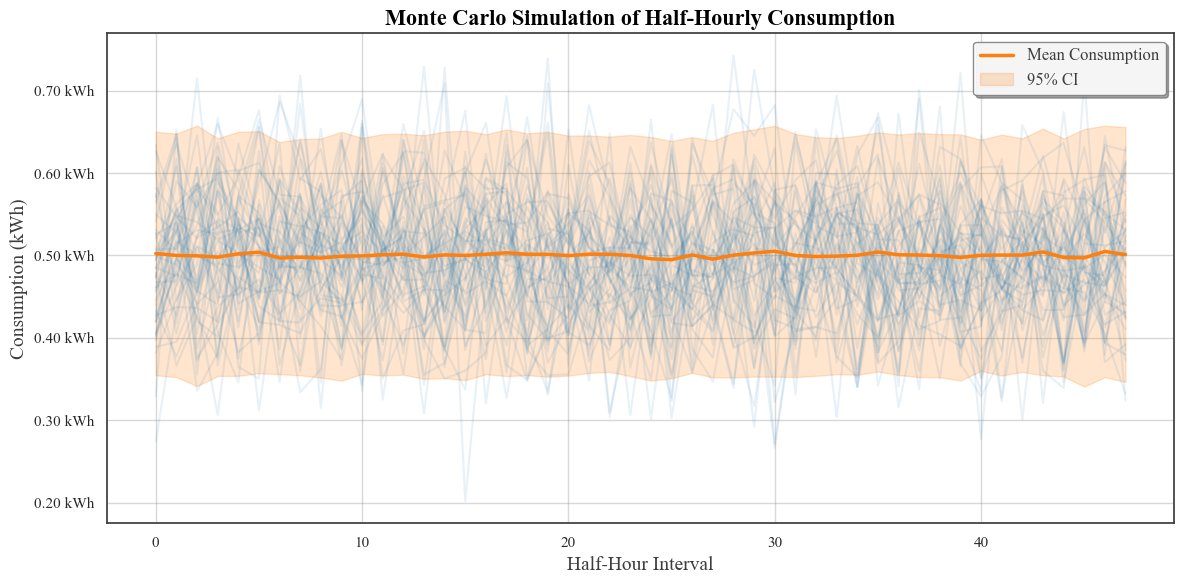

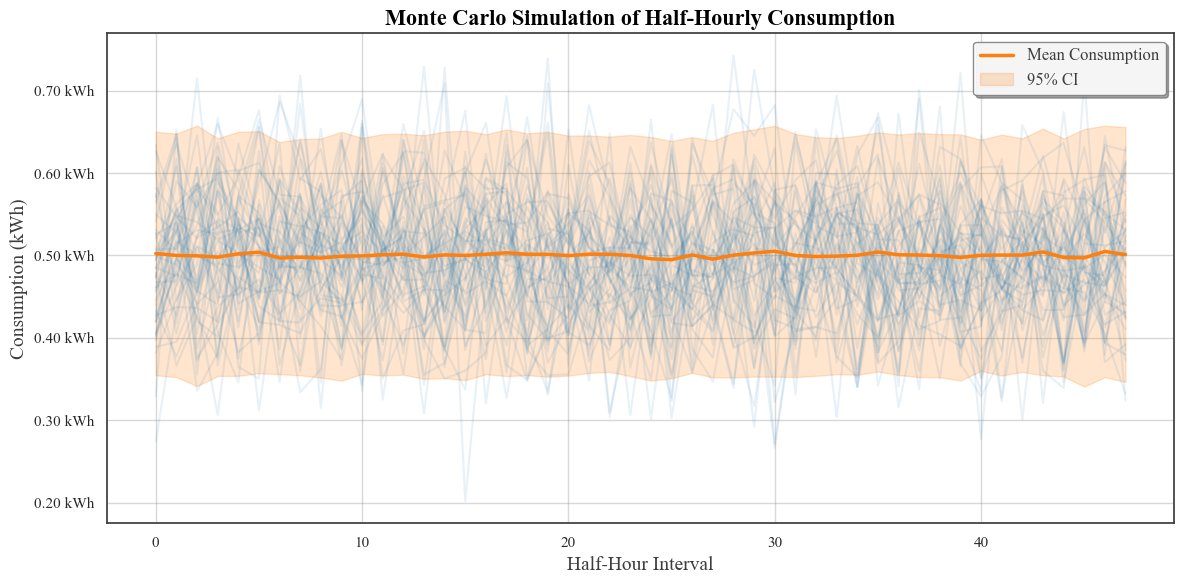

In [5]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

THEME = {
    "DARK_BLUE": {"hex": "#1f77b4"},
    "ORANGE": {"hex": "#ff7f0e"},
    "DARK_GREY": {"hex": "#7f7f7f"}
}

def apply_plot_style(ax, title, xlabel, ylabel):
    """Apply styling to the plot according to the SERL theme."""
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

# ╔════════════════════════════╗
# ║   TARIFF SIMULATOR CLASS   ║
# ╚════════════════════════════╝
class TariffSimulator:
    """Simulates energy consumption patterns and profiles"""
    
    def __init__(self, daily_usage_kwh):
        self.daily_usage_kwh = daily_usage_kwh
        self.logger = logging.getLogger(self.__class__.__name__)
        
    def simulate_half_hourly(self):
        """Generate half-hourly consumption profile"""
        avg_kwh = self.daily_usage_kwh / 48
        timestamps = pd.date_range("2023-01-01", periods=48, freq='30min')
        
        return pd.DataFrame({
            "timestamp": timestamps,
            "consumption_kwh": [avg_kwh] * 48,
            "hour": timestamps.hour,
            "minute": timestamps.minute
        })
        
    def monte_carlo_simulation(self, n_iterations=1000, std_dev=0.2):
        """Simulate demand variability using Monte Carlo method"""
        base_consumption = np.asarray(self.simulate_half_hourly()['consumption_kwh'])
        simulations = []
        
        for _ in range(n_iterations):
            # Add Gaussian noise to simulate demand variability
            noise = np.random.normal(scale=std_dev, size=48)
            simulated = np.clip(base_consumption * (1 + noise), 0, None)
            simulations.append(simulated)
            
        return pd.DataFrame(simulations).T
    
    def plot_simulation(self, simulations):
        """Visualize Monte Carlo simulation results with SERL theme"""
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot individual simulations
        for i in range(min(50, len(simulations.columns))):
            ax.plot(simulations[i], alpha=0.1, color=THEME["DARK_BLUE"]["hex"])
            
        # Plot mean and confidence intervals
        mean_consumption = simulations.mean(axis=1)
        std_consumption = simulations.std(axis=1)
        
        ax.plot(mean_consumption, color=THEME["ORANGE"]["hex"], 
                linewidth=2.5, label='Mean Consumption')
        ax.fill_between(
            range(48),
            mean_consumption - 1.96 * std_consumption,
            mean_consumption + 1.96 * std_consumption,
            alpha=0.2, color=THEME["ORANGE"]["hex"], label='95% CI'
        )
        
        # Apply SERL theme styling
        apply_plot_style(
            ax, 
            "Monte Carlo Simulation of Half-Hourly Consumption",
            "Half-Hour Interval",
            "Consumption (kWh)"
        )
        
        # Customize legend
        legend = ax.legend(
            loc='upper right',
            frameon=True,
            fancybox=True,
            shadow=True,
            fontsize=12
        )
        frame = legend.get_frame()
        frame.set_facecolor('#FFFFFF')
        frame.set_edgecolor(THEME["DARK_GREY"]["hex"])
        frame.set_alpha(0.9)
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3, linestyle='-', color=THEME["DARK_GREY"]["hex"])
        
        # Format y-axis to show kWh values properly
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f} kWh'))
        
        plt.tight_layout()
        return fig
    
# Create simulator for 24 kWh daily usage
sim = TariffSimulator(daily_usage_kwh=24)

# Generate baseline half-hourly profile and show first 5 rows
profile = sim.simulate_half_hourly()
display(profile.head())

# Run a Monte Carlo (1 000 runs, 15% noise) and plot results
mc = sim.monte_carlo_simulation(n_iterations=1000, std_dev=0.15)
sim.plot_simulation(mc)


╔══════════════════════════════════════════════╗
║   SIMULATION DIAGNOSTICS FOR MONTE CARLO     ║
╚══════════════════════════════════════════════╝


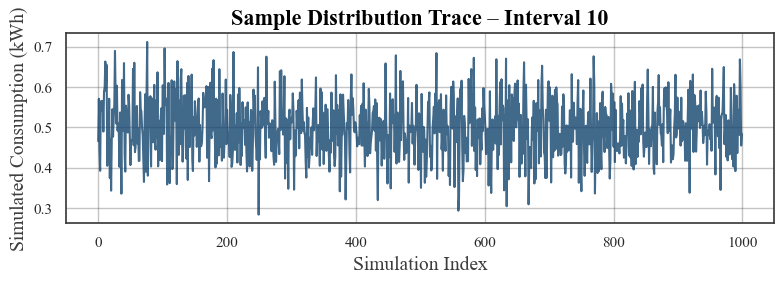

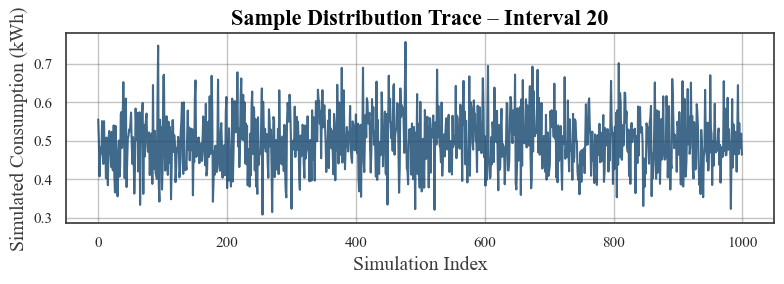

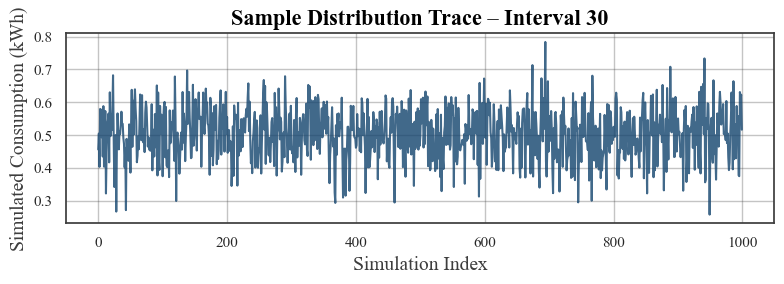

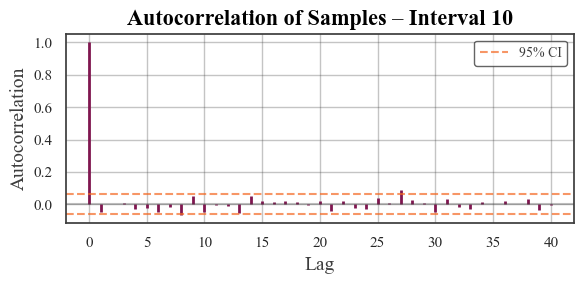

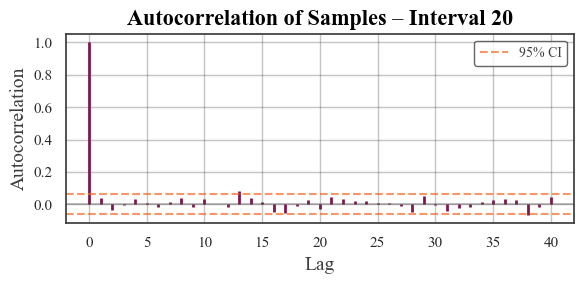

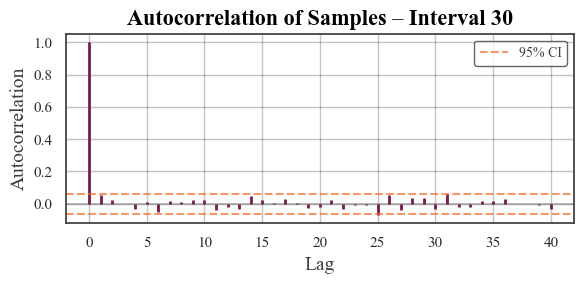

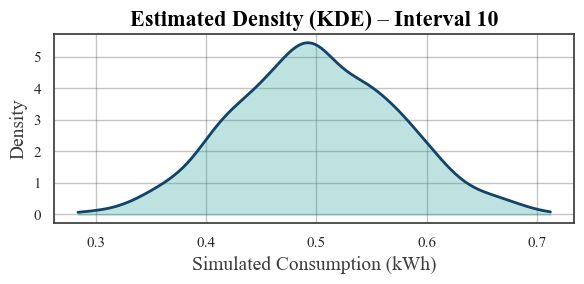

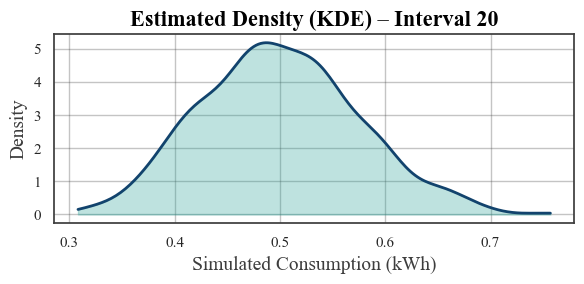

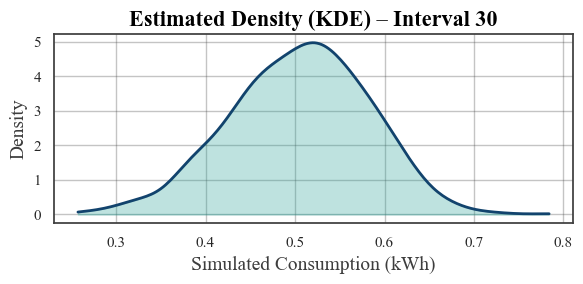

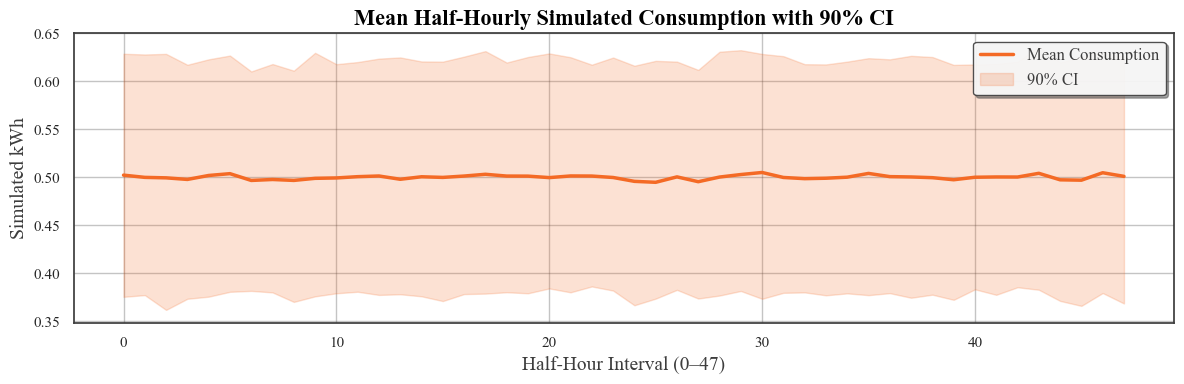

[2025-09-01 01:59:54] [INFO] root: Simulation diagnostics customized with SERL theme successfully.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde, skew, kurtosis  # Ensure these functions are available
import logging

def create_styled_table(df, title):
    return df.style.set_caption(title)

# Define THEME as a dictionary so that you can access color hex codes properly.
THEME = {
    "DARK_PINK":   {"hex": "#801650", "rgb": (128, 22, 80),  "cmyk": (0, 83, 38, 50)},
    "DARK_BLUE":   {"hex": "#12436D", "rgb": (18, 67, 109),  "cmyk": (83, 39, 0, 57)},
    "TURQUOISE":   {"hex": "#28A197", "rgb": (40, 161, 151), "cmyk": (75, 0, 6, 37)},
    "ORANGE":      {"hex": "#F46A25", "rgb": (244, 106, 37),  "cmyk": (0, 57, 85, 4)},
    "DARK_GREY":   {"hex": "#3D3D3D", "rgb": (61, 61, 61),   "cmyk": (0, 0, 0, 76)},
    "LIGHT_PURPLE":{"hex": "#A285D1", "rgb": (162, 133, 209), "cmyk": (22, 36, 0, 18)}
}

# ╔═══════════════════════════════════════════════════════╗
# ║        SIMULATION VARIABILITY & DISTRIBUTION CHECKS   ║
# ╚═══════════════════════════════════════════════════════╝

print("╔══════════════════════════════════════════════╗")
print("║   SIMULATION DIAGNOSTICS FOR MONTE CARLO     ║")
print("╚══════════════════════════════════════════════╝")

# These diagnostics explore distribution and variability
# in randomly simulated consumption at specific time intervals.

# Choose 3 time intervals out of the 48 simulated half-hour slots
selected_intervals = [10, 20, 30]

# === 1. Simulation Trace Plots (like an i.i.d. sample trace) ===
for idx in selected_intervals:
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(mc.iloc[idx].astype(float).values, alpha=0.8, color=THEME["DARK_BLUE"]["hex"]) # type: ignore
    
    # Apply SERL theme styling
    apply_plot_style(
        ax, 
        f"Sample Distribution Trace – Interval {idx}",
        "Simulation Index",
        "Simulated Consumption (kWh)"
    )
    
    ax.grid(True, alpha=0.3, color=THEME["DARK_GREY"]["hex"])
    plt.tight_layout()
    plt.show()

# === 2. Autocorrelation of Samples (mostly flat for i.i.d.) ===
for idx in selected_intervals:
    fig, ax = plt.subplots(figsize=(6, 3))
    values = mc.iloc[idx].astype(float).values
    
    # Create autocorrelation plot with custom styling
    from statsmodels.tsa.stattools import acf
    acf_values = acf(values, nlags=40, fft=False)
    
    # Plot the autocorrelation values
    ax.vlines(range(len(acf_values)), [0], acf_values, 
              colors=THEME["DARK_PINK"]["hex"], linewidth=2)
    ax.axhline(y=0, color=THEME["DARK_GREY"]["hex"], linestyle='-', alpha=0.3)
    
    # Add confidence intervals (approx 95%)
    conf_int = 1.96 / np.sqrt(len(values))
    ax.axhline(y=conf_int, color=THEME["ORANGE"]["hex"], 
               linestyle='--', alpha=0.7, label='95% CI')
    ax.axhline(y=-conf_int, color=THEME["ORANGE"]["hex"], 
               linestyle='--', alpha=0.7)
    
    # Apply SERL theme styling
    apply_plot_style(
        ax, 
        f"Autocorrelation of Samples – Interval {idx}",
        "Lag",
        "Autocorrelation"
    )
    
    ax.legend(loc='upper right', fontsize=10, frameon=True, 
              facecolor='white', edgecolor=THEME["DARK_GREY"]["hex"])
    ax.grid(True, alpha=0.3, color=THEME["DARK_GREY"]["hex"])
    plt.tight_layout()
    plt.show()

# === 3. KDE: Smooth estimated density from Monte Carlo draws ===
for idx in selected_intervals:
    # Ensure values is a 1D float64 numpy array
    values = np.asarray(mc.iloc[idx].values, dtype=float)
    values = values[np.isfinite(values)]  # Remove invalid entries

    kde = gaussian_kde(values)
    x_vals = np.linspace(values.min(), values.max(), 200)
    y_vals = kde(x_vals)

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(x_vals, y_vals, color=THEME["DARK_BLUE"]["hex"], linewidth=2)
    ax.fill_between(x_vals, y_vals, alpha=0.3, color=THEME["TURQUOISE"]["hex"])
    
    # Apply SERL theme styling
    apply_plot_style(
        ax, 
        f"Estimated Density (KDE) – Interval {idx}",
        "Simulated Consumption (kWh)",
        "Density"
    )
    
    ax.grid(True, alpha=0.3, color=THEME["DARK_GREY"]["hex"])
    plt.tight_layout()
    plt.show()

# === 4. Mean and Confidence Interval Across All Intervals ===
# Aggregate stats from all 48 half-hour periods
mean = mc.mean(axis=1)
lower = mc.quantile(0.05, axis=1)
upper = mc.quantile(0.95, axis=1)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(mean, color=THEME["ORANGE"]["hex"], linewidth=2.5, label="Mean Consumption")
ax.fill_between(range(48), lower, upper, alpha=0.2, color=THEME["ORANGE"]["hex"], label="90% CI")

# Apply SERL theme styling
apply_plot_style(
    ax, 
    "Mean Half-Hourly Simulated Consumption with 90% CI",
    "Half-Hour Interval (0–47)",
    "Simulated kWh"
)

# Customize legend
legend = ax.legend(
    loc='upper right',
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=12
)
frame = legend.get_frame()
frame.set_facecolor('#FFFFFF')
frame.set_edgecolor(THEME["DARK_GREY"]["hex"])
frame.set_alpha(0.9)

ax.grid(True, alpha=0.3, color=THEME["DARK_GREY"]["hex"])
plt.tight_layout()
plt.show()

# ╔════════════════════════════════════════════╗
# ║         ADDITIONAL STATISTICAL SUMMARY     ║
# ╚════════════════════════════════════════════╝

# Create a summary table of statistics for the selected intervals
summary_data = []
for idx in selected_intervals:
    values = np.asarray(mc.iloc[idx].values, dtype=float)
    values = values[np.isfinite(values)]
    
    summary_data.append({
        'Interval': idx,
        'Mean (kWh)': np.mean(values),
        'Std Dev (kWh)': np.std(values),
        '5th Percentile': np.percentile(values, 5),
        '95th Percentile': np.percentile(values, 95),
        'Skewness': stats.skew(values),
        'Kurtosis': stats.kurtosis(values)
    })

summary_df = pd.DataFrame(summary_data)
styled_summary = create_styled_table(
    summary_df, 
    "Statistical Summary of Selected Intervals"
)
display(styled_summary)

# Log completion
logging.info("Simulation diagnostics customized with SERL theme successfully.")

Initializing NUTS using jitter+adapt_diag...
[2025-09-01 01:59:54] [INFO] pymc.sampling.mcmc: Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
[2025-09-01 01:59:55] [INFO] pymc.sampling.mcmc: Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_temp, beta_hdd, beta_solar, sigma]
[2025-09-01 01:59:55] [INFO] pymc.sampling.mcmc: NUTS: [alpha, beta_temp, beta_hdd, beta_solar, sigma]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
[2025-09-01 01:59:58] [INFO] pymc.sampling.mcmc: Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
[2025-09-01 01:59:58] [INFO] pymc.stats.convergence: We recommend running at least 4 chains for robust computation of convergence diagnostics


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha       13.63  7.37   -0.25    27.67       0.29     0.21    638.77   
beta_temp   -0.02  0.46   -0.87     0.81       0.02     0.01    742.28   
beta_hdd     2.26  0.55    1.17     3.24       0.02     0.02    679.65   
beta_solar  -0.06  0.02   -0.09    -0.02       0.00     0.00    950.28   
sigma       17.01  0.67   15.81    18.29       0.02     0.02   1087.36   

            ess_tail  r_hat  
alpha         825.08   1.00  
beta_temp     884.80   1.00  
beta_hdd      966.63   1.01  
beta_solar   1009.70   1.00  
sigma        1019.66   1.00  


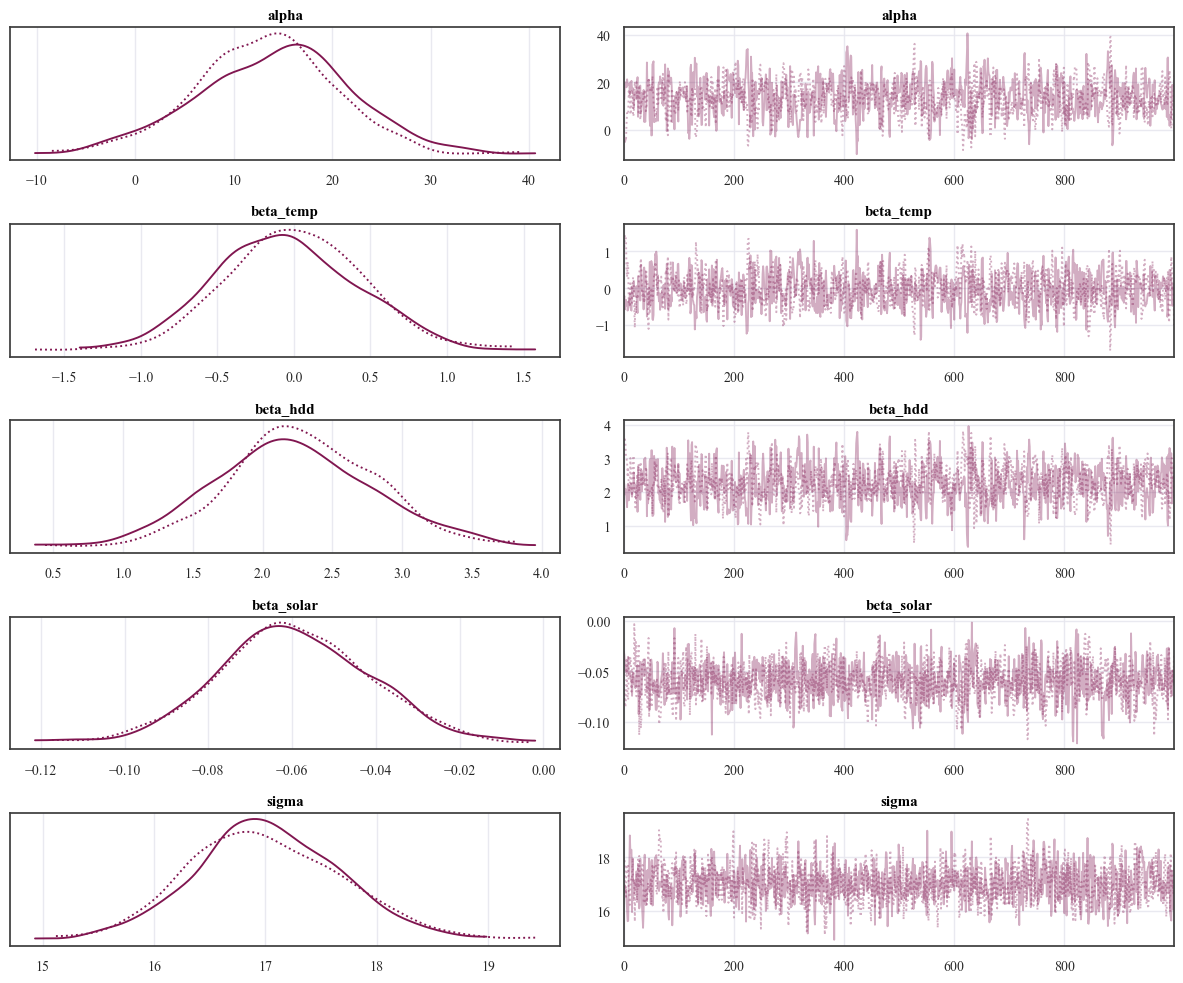

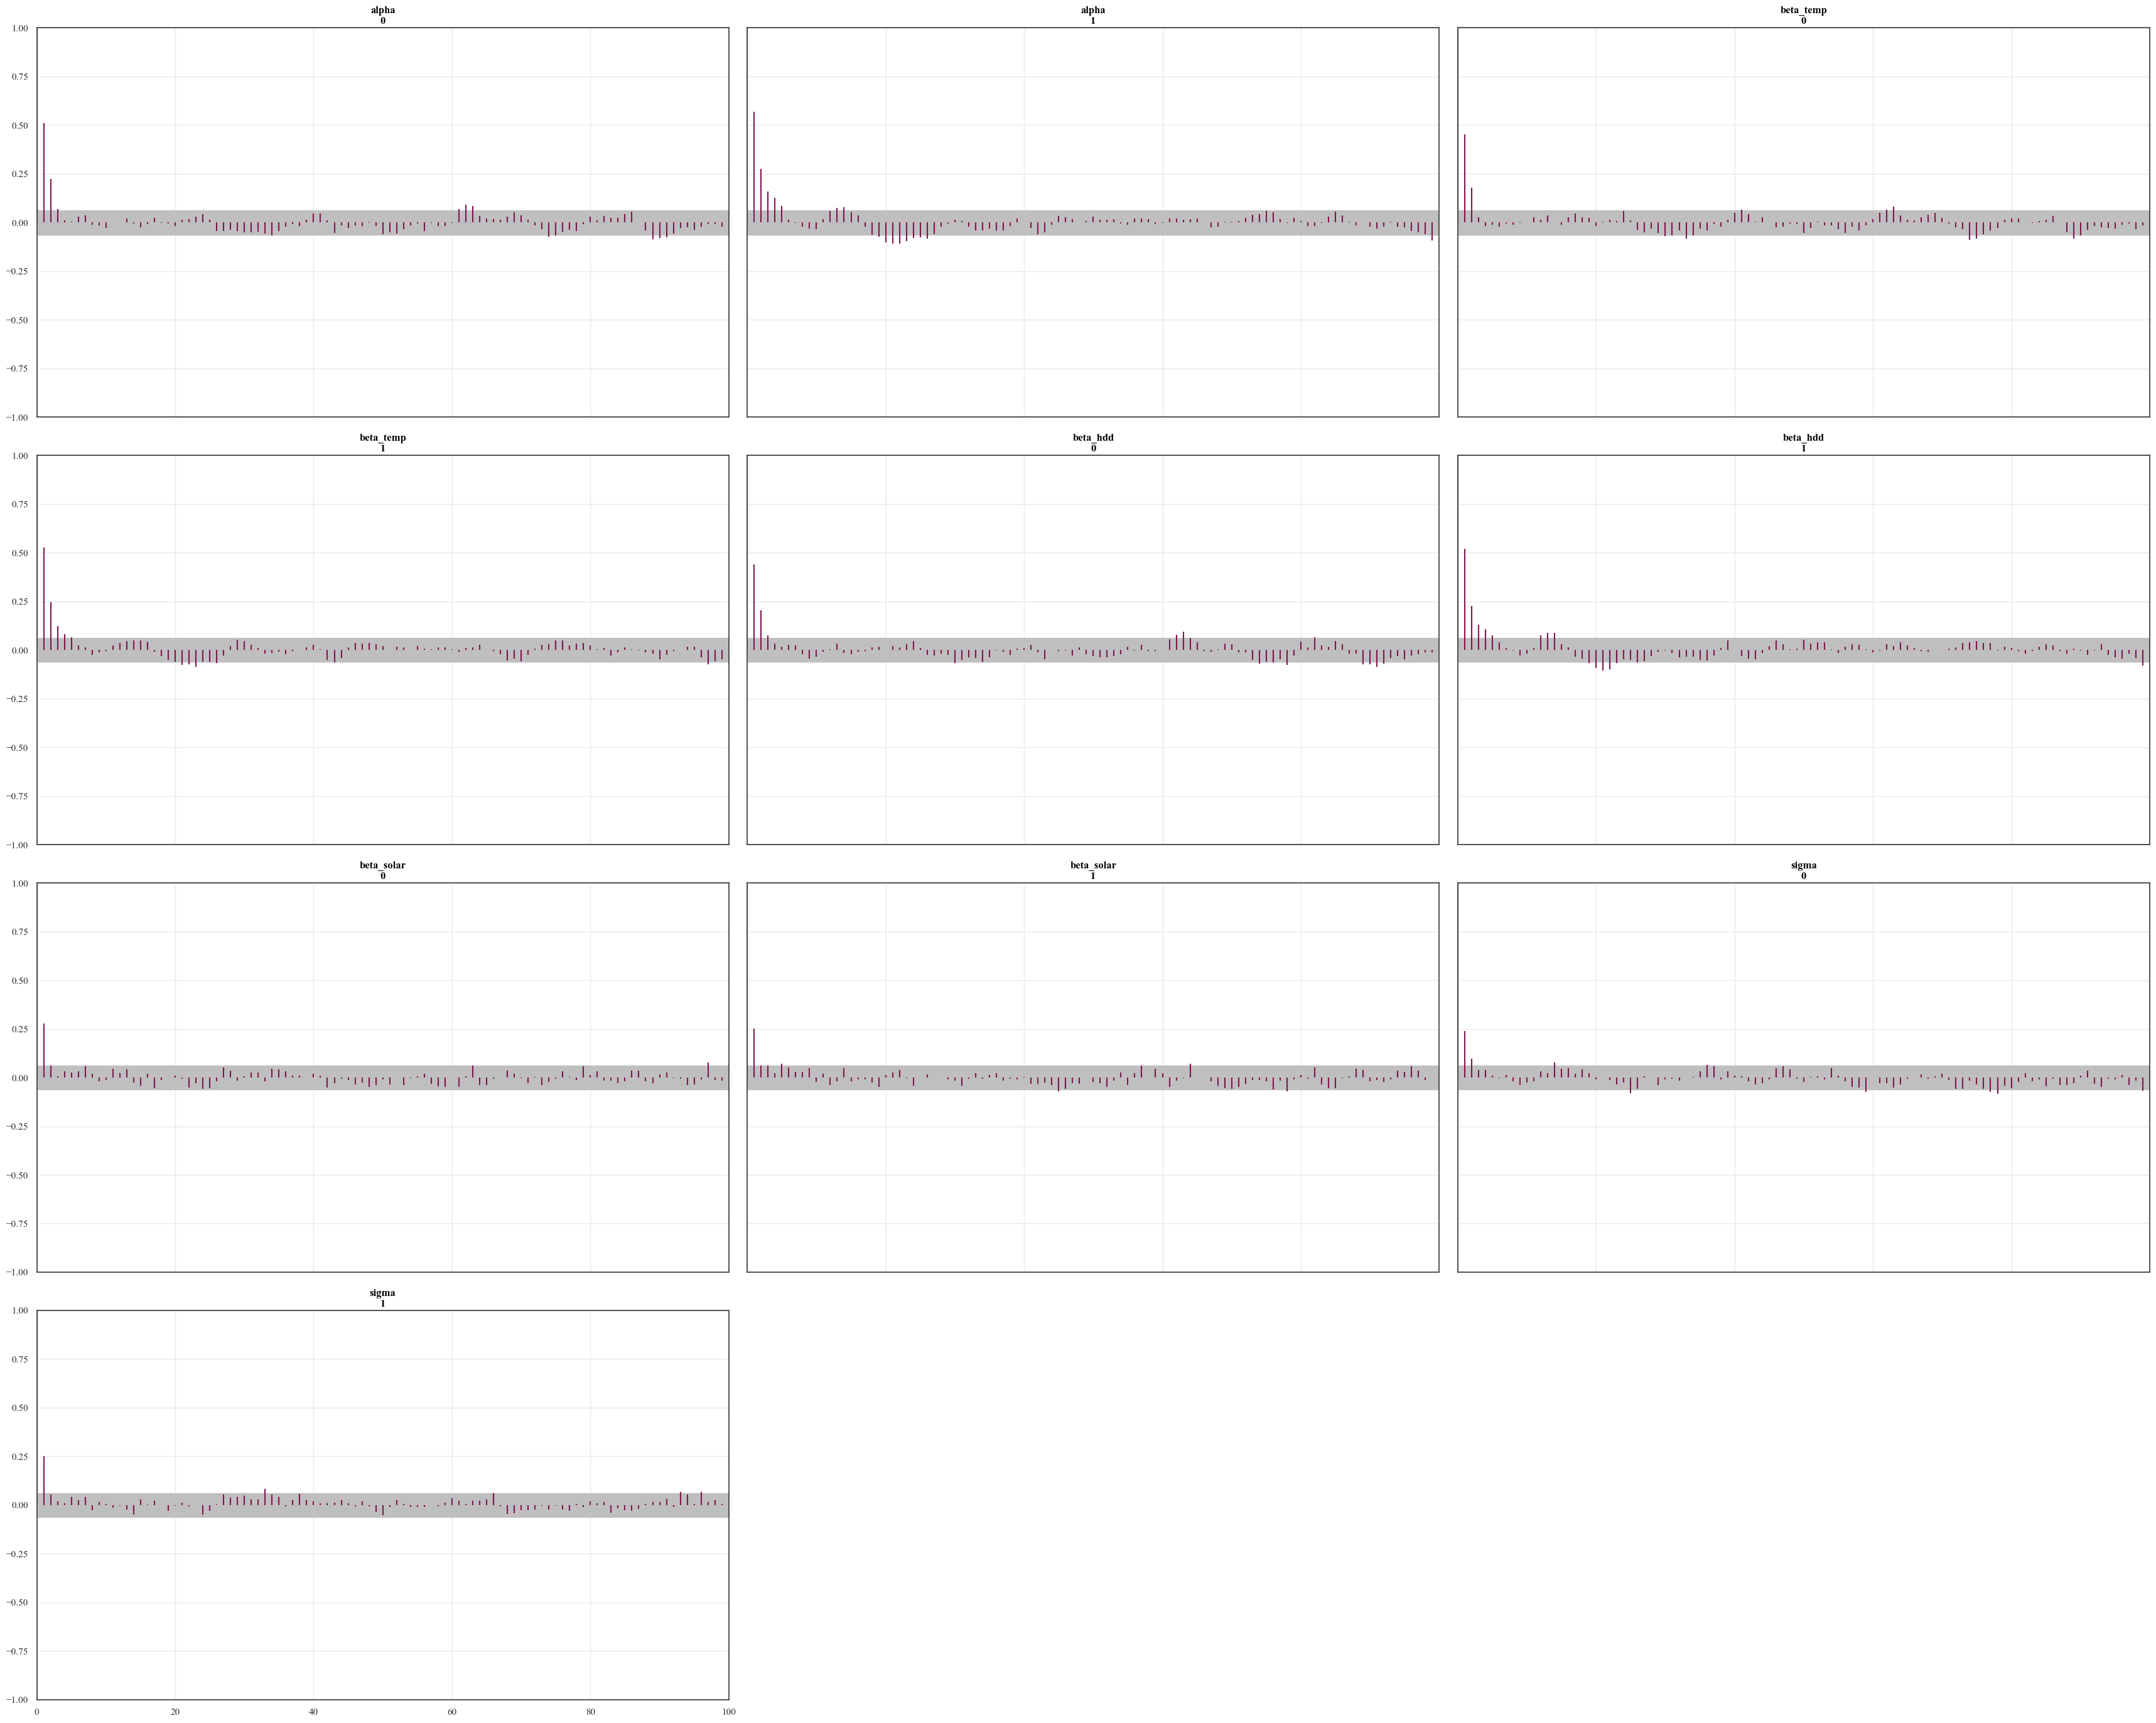

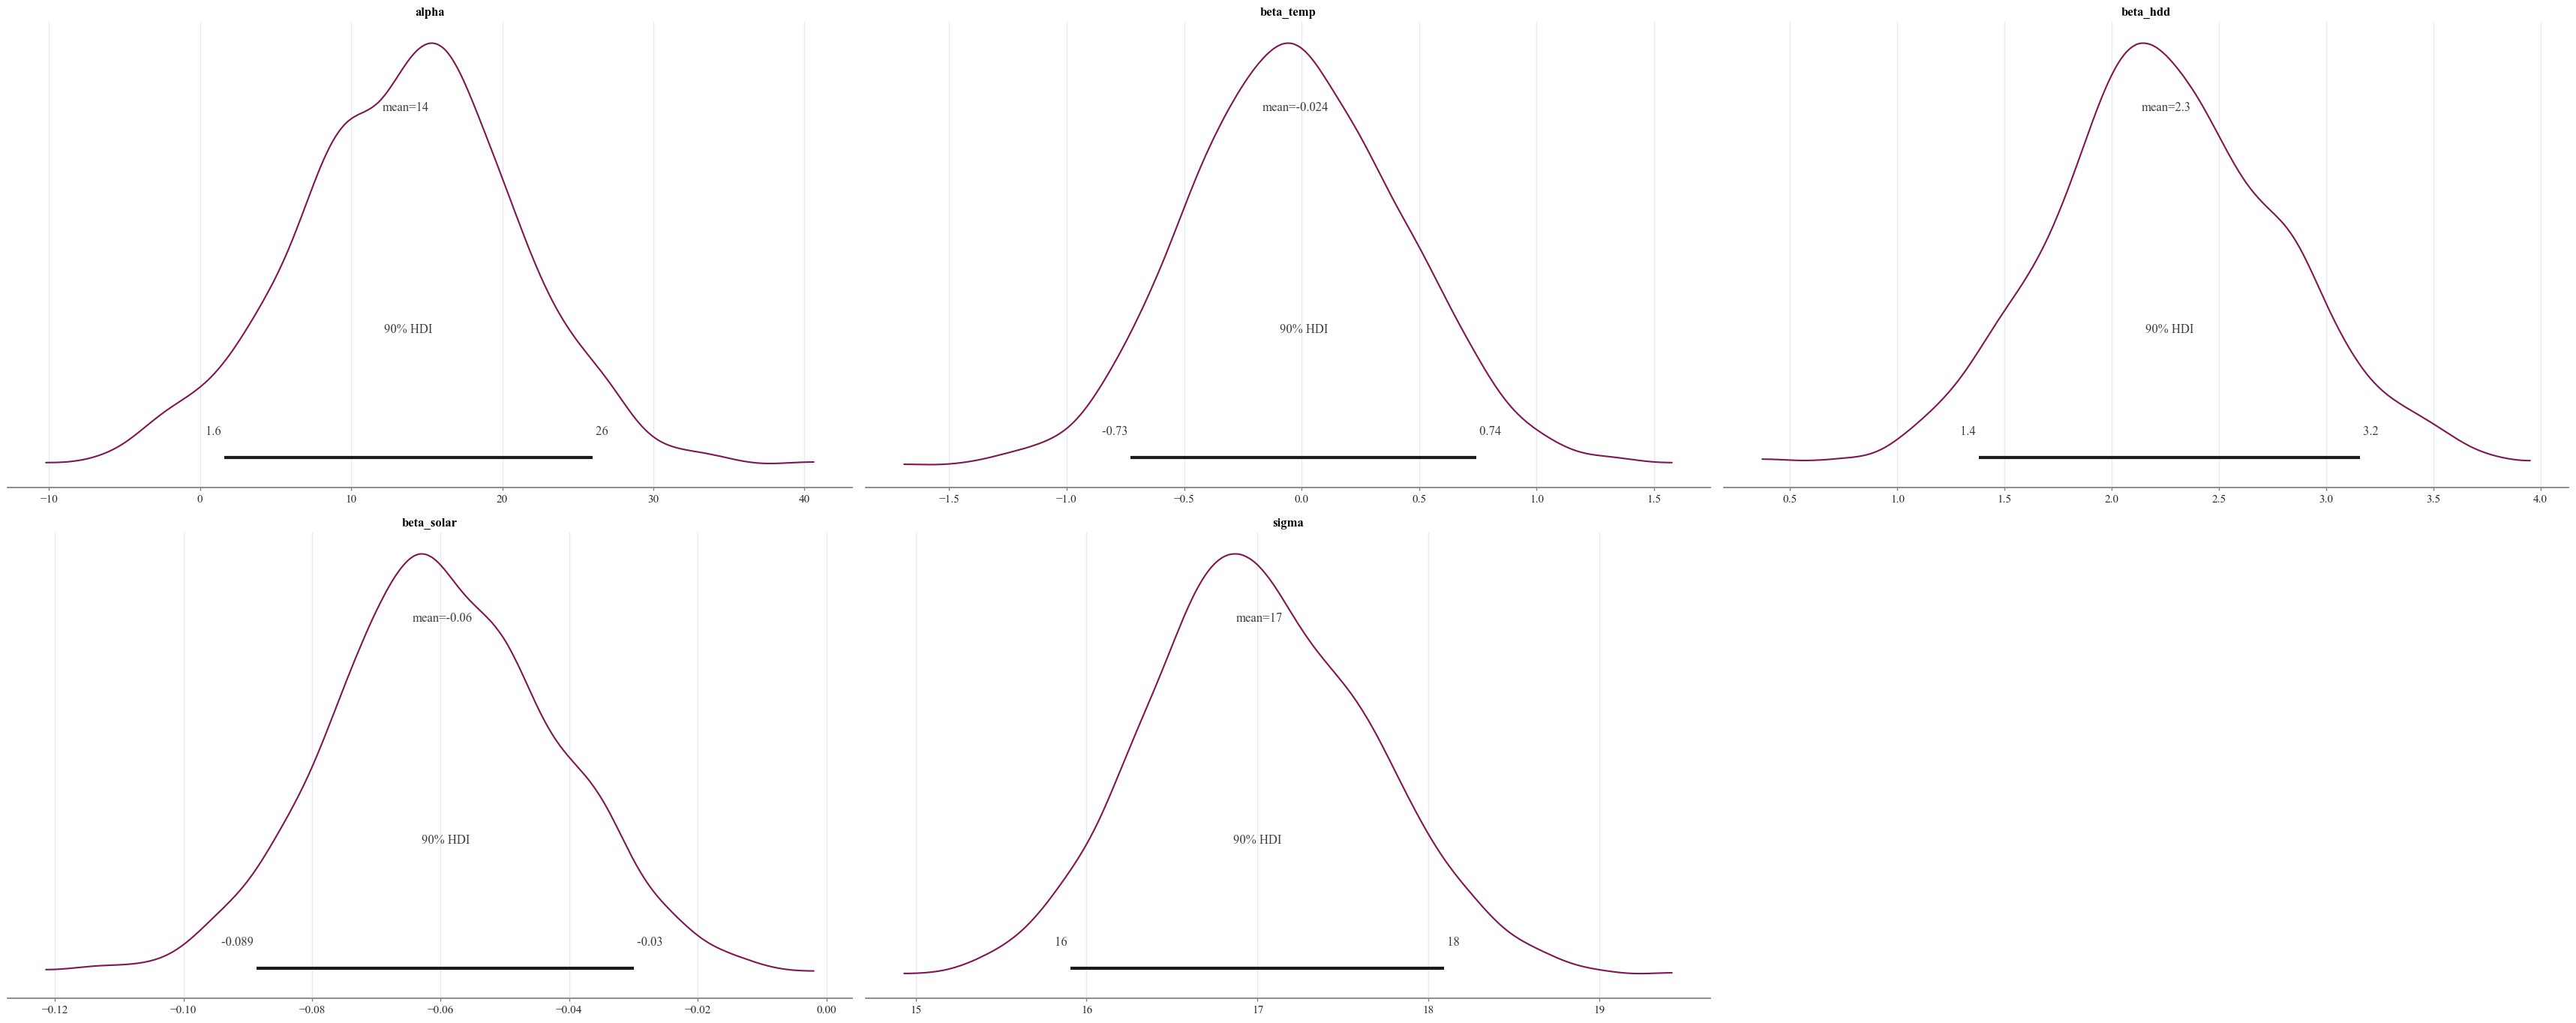

Sampling: [y]
[2025-09-01 02:00:00] [INFO] pymc.sampling.forward: Sampling: [y]


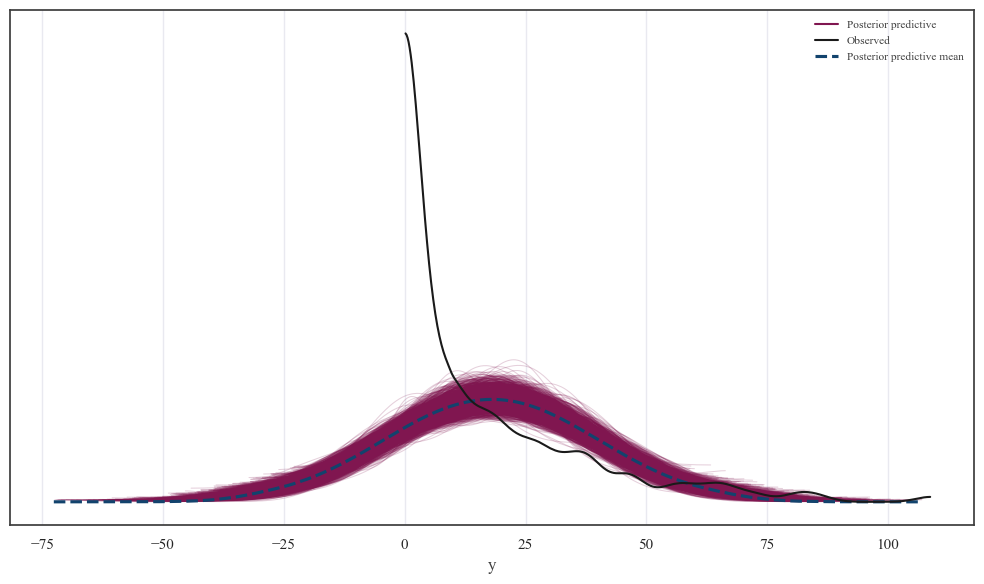

In [7]:
# ╔══════════════════════════════════════════════════════════════╗
# ║    BAYESIAN LINEAR MODELING FOR GAS CONSUMPTION (PYMC)      ║
# ╚══════════════════════════════════════════════════════════════╝

# Filter dataset for gas users without PV and select relevant features
subset = df[
    (df["quantity"] == "Gas") &
    (df["segment_2_value"] == "No")
][["mean", "mean_temp", "mean_hdd", "mean_solar"]].dropna()

# Randomly sample 300 rows to speed up inference
sample_df = subset.sample(n=300, random_state=42)

# Extract predictors and target variable as NumPy arrays
y_obs = sample_df["mean"].values
temp = sample_df["mean_temp"].values
hdd = sample_df["mean_hdd"].values
solar = sample_df["mean_solar"].values

with pm.Model() as model:
    # Priors for regression coefficients
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_temp = pm.Normal("beta_temp", mu=0, sigma=1)
    beta_hdd = pm.Normal("beta_hdd", mu=0, sigma=1)
    beta_solar = pm.Normal("beta_solar", mu=0, sigma=1)

    # Prior for noise (residual standard deviation)
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Linear model
    mu = alpha + beta_temp * temp + beta_hdd * hdd + beta_solar * solar

    # Likelihood: observed gas usage is Normally distributed
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

    # Run MCMC sampling
    trace = pm.sample(
        draws=1000,
        tune=500,
        chains=2,
        cores=1,
        target_accept=0.95,
        return_inferencedata=True,
        progressbar=False  # Disable progress bar for cleaner logs
    )

# Summary statistics of posterior samples
print(
    az.summary(
        trace,
        var_names=["alpha", "beta_temp", "beta_hdd", "beta_solar", "sigma"],
        round_to=2
    )
)

# Plot posterior traces (value over iteration)
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Plot autocorrelation of MCMC chains
az.plot_autocorr(trace)
plt.tight_layout()
plt.show()

# Plot marginal posteriors with 90% highest density intervals (HDIs)
az.plot_posterior(trace, hdi_prob=0.9)
plt.tight_layout()
plt.show()

# Generate posterior predictive draws for observed variable `y`
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y"], progressbar=False)

# Plot overlay of predicted and observed distributions
az.plot_ppc(ppc)
plt.tight_layout()
plt.show()

In [8]:
# ╔════════════════════════════╗
# ║   TARIFF CALCULATOR CLASS  ║
# ╚════════════════════════════╝

from __future__ import annotations
import json
import time
import logging
from typing import Optional, Dict, List
import requests
import pandas as pd
from dateutil import parser as dtparser
from datetime import datetime, timezone

class TariffCalculator:
    """
    Fetches live half-hourly Agile unit rates from Octopus Energy and
    calculates daily costs for a provided consumption dataframe.
    """

    def __init__(
        self,
        consumption_df: pd.DataFrame,
        region_code: str = "C",                 # Agile region (e.g., "C" Manchester)
        product_code: str = "AGILE-24-10-01",  # Update as needed
        normalize_to_kwh: Optional[float] = None,
        standing_charge_gbp_per_day: float = 0.5485,  # Manchester example
        backup_file: str = "agile_backup.json",
        request_timeout: int = 15,
        max_retries: int = 3,
        retry_backoff_sec: float = 1.5,
    ) -> None:

        # ---- Validate and prepare consumption data ----
        if "consumption_kwh" not in consumption_df.columns:
            raise ValueError("consumption dataframe must contain a 'consumption_kwh' column")

        if "timestamp" not in consumption_df.columns:
            if isinstance(consumption_df.index, pd.DatetimeIndex):
                consumption_df = consumption_df.copy()
                consumption_df["timestamp"] = consumption_df.index
            else:
                raise ValueError("consumption dataframe must have a datetime index or a 'timestamp' column")

        df = consumption_df.copy()

        # ensure timestamps are timezone-aware in local (Europe/London) then converted to UTC
        # If your timestamps are already tz-aware, we respect them; if naive, assume Europe/London.
        if df["timestamp"].dt.tz is None:
            # Assume local UK time if naive, then convert to UTC
            df["timestamp"] = df["timestamp"].dt.tz_localize("Europe/London").dt.tz_convert("UTC")
        else:
            df["timestamp"] = df["timestamp"].dt.tz_convert("UTC")

        if normalize_to_kwh:
            total = df["consumption_kwh"].sum()
            if total > 0:
                df["consumption_kwh"] = df["consumption_kwh"] / total * normalize_to_kwh

        # Attach handy columns (all using UTC)
        df["date"] = df["timestamp"].dt.tz_convert("Europe/London").dt.date  # daily grouping in local UK date
        df["period_start"] = df["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%S")  # naive ISO string used as key

        self.df = df
        self.product_code = product_code
        self.region_code = region_code
        self.tariff_code = f"E-1R-{self.product_code}-{self.region_code}"
        self.base_url = f"https://api.octopus.energy/v1/products/{self.product_code}/electricity-tariffs/{self.tariff_code}/standard-unit-rates/"
        self.backup_file = backup_file
        self.request_timeout = request_timeout
        self.max_retries = max_retries
        self.retry_backoff_sec = retry_backoff_sec

        self.standing_charge = standing_charge_gbp_per_day
        self.tariff_type = "agile"
        self.logger = logging.getLogger(self.__class__.__name__)
        if not self.logger.handlers:
            logging.basicConfig(level=logging.INFO)

        # Fetch & prepare rates
        self.rates = self._fetch_and_prepare_rates()

    # ---------- Public API ----------

    def calculate_agile_tariff(self) -> pd.DataFrame:
        """
        Returns a dataframe with per-day total cost (energy + standing charge).
        """
        df = self.df.copy()

        def lookup_rate(ts_str: str) -> float:
            # Fallback to 0.30 £/kWh if a half-hour slot has no returned price
            return self.rates.get(ts_str, 0.30)

        df["unit_rate_gbp_per_kwh"] = df["period_start"].map(lookup_rate)
        df["cost_energy_gbp"] = df["consumption_kwh"] * df["unit_rate_gbp_per_kwh"]

        daily = df.groupby("date", as_index=False)["cost_energy_gbp"].sum()
        daily["standing_charge_gbp"] = self.standing_charge
        daily["total_cost_gbp"] = daily["cost_energy_gbp"] + daily["standing_charge_gbp"]
        return daily

    def summary(self) -> None:
        cost_df = self.calculate_agile_tariff()
        print("\n╔═════════════════════════════════════╗")
        print("║      TARIFF COMPARISON RESULTS      ║")
        print("╚═════════════════════════════════════╝")
        print(cost_df[["date", "total_cost_gbp"]].to_string(index=False))

        avg_cost = cost_df["total_cost_gbp"].mean()
        min_day = cost_df.loc[cost_df["total_cost_gbp"].idxmin()]
        print(f"\nAverage Daily Cost: £{avg_cost:.2f}")
        print(f"Cheapest Day: {min_day['date']} (£{min_day['total_cost_gbp']:.2f})")

    # ---------- Internals ----------

    def _fetch_and_prepare_rates(self) -> Dict[str, float]:
        """
        Fetch half-hourly unit rates from Octopus, handling pagination, retries, and fallback.
        Returns a dict keyed by UTC half-hour start (naive ISO string) -> £/kWh.
        """
        period_from = self._to_octopus_iso(self.df["timestamp"].min())
        period_to = self._to_octopus_iso(self.df["timestamp"].max())

        try:
            price_data = self._fetch_octopus_rates_paginated(period_from, period_to)
            # Save fallback on success
            with open(self.backup_file, "w", encoding="utf-8") as f:
                json.dump(price_data, f)
        except Exception as e:
            self.logger.warning(f"Failed to fetch live rates: {e}")
            self.logger.info(f"Falling back to local '{self.backup_file}' if available...")
            try:
                with open(self.backup_file, "r", encoding="utf-8") as f:
                    price_data = json.load(f)
            except Exception as backup_error:
                raise RuntimeError(f"Could not load fallback data: {backup_error}")

        # Map each valid_from (UTC) to value_inc_vat (£/kWh)
        # Octopus returns p/kWh; divide by 100 for £/kWh.
        rates: Dict[str, float] = {}
        for entry in price_data:
            try:
                valid_from_utc = dtparser.isoparse(entry["valid_from"]).astimezone(timezone.utc)
                key = valid_from_utc.replace(tzinfo=None).strftime("%Y-%m-%dT%H:%M:%S")
                rates[key] = float(entry["value_inc_vat"]) / 100.0
            except Exception:
                # Skip malformed entries gracefully
                continue

        if not rates:
            raise RuntimeError("No tariff rates available after fetch/fallback.")

        return rates

    def _fetch_octopus_rates_paginated(self, period_from: str, period_to: str) -> List[dict]:
        """
        Handles Octopus pagination via 'next' links. Adds page_size for efficiency.
        """
        headers = {
            "User-Agent": "TariffSimulation/1.0 (+https://example.local) Python requests"
        }
        params = {
            "period_from": period_from,
            "period_to": period_to,
            "page_size": 250,   # fetch larger pages to reduce pagination
            "order_by": "period",  # consistent order if supported
        }

        results: List[dict] = []
        url = self.base_url
        first = True
        retries = 0

        while url:
            try:
                if first:
                    resp = requests.get(url, params=params, headers=headers, timeout=self.request_timeout)
                    first = False
                else:
                    # For 'next' URLs we don't pass params again
                    resp = requests.get(url, headers=headers, timeout=self.request_timeout)

                if resp.status_code >= 500 and retries < self.max_retries:
                    retries += 1
                    time.sleep(self.retry_backoff_sec * retries)
                    continue

                resp.raise_for_status()
                data = resp.json()
                page_results = data.get("results", [])
                results.extend(page_results)
                url = data.get("next")
                retries = 0  # reset retries after a successful page

            except requests.RequestException as e:
                if retries < self.max_retries:
                    retries += 1
                    time.sleep(self.retry_backoff_sec * retries)
                    continue
                raise RuntimeError(f"Request failed after retries: {e}") from e

        if not results:
            raise RuntimeError("Octopus API returned no results in the requested period.")
        return results

    @staticmethod
    def _to_octopus_iso(ts: pd.Timestamp) -> str:
        """
        Convert pandas Timestamp to Octopus expected ISO (UTC, Z-suffixed, minute precision).
        """
        ts = ts.tz_convert("UTC")
        return ts.strftime("%Y-%m-%dT%H:%MZ")


if __name__ == "__main__":
    # Example: synthetic 3-day profile, 0.5 kWh every 30 minutes, normalized to 24 kWh/day
    date_range = pd.date_range(
        start="2024-11-01 00:00",
        end="2024-11-04 00:00",
        freq="30min",
        tz="Europe/London",
        inclusive="left"
    )
    consumption = [0.5] * len(date_range)
    df = pd.DataFrame({"timestamp": date_range, "consumption_kwh": consumption})

    # Instantiate and run (Manchester Region C)
    calculator = TariffCalculator(
        consumption_df=df,
        region_code="C",
        product_code="AGILE-24-10-01",
        normalize_to_kwh=24
    )
    calculator.summary()



╔═════════════════════════════════════╗
║      TARIFF COMPARISON RESULTS      ║
╚═════════════════════════════════════╝
      date  total_cost_gbp
2024-11-01        2.211525
2024-11-02        2.199467
2024-11-03        2.236990

Average Daily Cost: £2.22
Cheapest Day: 2024-11-02 (£2.20)


In [34]:
# ╔════════════════════════════╗
# ║     TARIFF PLOTTER CLASS   ║
# ╚════════════════════════════╝

class TariffPlotter:
    """
    Handles advanced visualization of Agile tariff pricing,
    energy consumption patterns, and optimal usage strategies.
    """

    @staticmethod
    def plot_interval_costs(df: pd.DataFrame, unit: str = "kWh"):
        """
        Plot unit rate, cost per interval, and rolling average rates.
        Highlights peak pricing intervals using a quantile threshold.
        """
        required_cols = {'timestamp', 'unit_rate', 'cost', 'consumption_kwh'}
        if not required_cols.issubset(df.columns):
            raise ValueError(f"DataFrame must contain: {required_cols}")

        df_sorted = df.sort_values("timestamp").copy()
        df_sorted['rolling_rate'] = (
            df_sorted['unit_rate'].rolling(window=4, min_periods=1).mean()
        )
        peak_threshold = df_sorted['unit_rate'].quantile(0.95)
        df_sorted['is_peak'] = df_sorted['unit_rate'] >= peak_threshold

        # Initialize twin axes
        fig, ax1 = plt.subplots(figsize=(16, 6))
        ax2 = ax1.twinx()

        # Plot rolling rate and cost
        sns.lineplot(data=df_sorted, x="timestamp", y="rolling_rate", ax=ax1,
                     label="Rolling Avg Rate", color="tab:blue")
        sns.lineplot(data=df_sorted, x="timestamp", y="cost", ax=ax2,
                     label="Interval Cost (£)", color="tab:red")

        # Highlight peak pricing points
        peak_points = df_sorted[df_sorted['is_peak']]
        ax1.scatter(peak_points['timestamp'], peak_points['unit_rate'],
                    color='orange', s=30, label="Peak Pricing")

        # Axis formatting
        ax1.set_ylabel(f"Unit Rate (£/{unit})", color="tab:blue")
        ax2.set_ylabel("Cost per Interval (£)", color="tab:red")
        ax1.set_xlabel("Aggregation Period")
        ax1.set_title("Agile Tariff: Unit Rate, Cost, and Peak Intervals")
        ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))
        ax1.tick_params(axis='x', rotation=45)

        # Layout and legend
        fig.tight_layout()
        fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.92))
        plt.grid(True, axis='x')
        plt.show()

    @staticmethod
    def plot_daily_costs(cost_df: pd.DataFrame):
        """
        Bar chart of total daily costs with average line and annotation.
        """
        if not {'date', 'total_cost'}.issubset(cost_df.columns):
            raise ValueError("DataFrame must contain 'date' and 'total_cost'")

        plt.figure(figsize=(12, 6))
        ax = sns.barplot(data=cost_df, x='date', y='total_cost', palette='Spectral')

        avg_cost = cost_df['total_cost'].mean()
        plt.axhline(avg_cost, color='gray', linestyle='--',
                    label=f"Average Cost = £{avg_cost:.2f}")

        # Annotate each bar
        for i, p in enumerate(ax.patches):
            label = f"£{p.get_height():.2f}"
            ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=9)

        plt.title("Total Daily Costs with Average Benchmark")
        plt.ylabel("Total Cost (£)")
        plt.xlabel("Day")
        plt.legend()
        plt.xticks(rotation=15)
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_consumption_profile(df: pd.DataFrame):
        """
        Line plot showing interval-level consumption and a rolling average.
        """
        if not {'timestamp', 'consumption_kwh'}.issubset(df.columns):
            raise ValueError("DataFrame must contain 'timestamp' and 'consumption_kwh'")

        df_sorted = df.sort_values("timestamp").copy()
        df_sorted['rolling_kwh'] = (
            df_sorted['consumption_kwh'].rolling(window=4, min_periods=1).mean()
        )

        plt.figure(figsize=(14, 5))
        sns.lineplot(data=df_sorted, x="timestamp", y="consumption_kwh",
                     color="tab:green", label="Interval Consumption")
        sns.lineplot(data=df_sorted, x="timestamp", y="rolling_kwh",
                     color="black", linestyle='--', label="Rolling Avg")

        plt.title("Energy Consumption Profile by Aggregation Period")
        plt.ylabel("Consumption (kWh)")
        plt.xlabel("Aggregation Period")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    @staticmethod
    def suggest_optimal_charging_windows(df: pd.DataFrame, duration_hours: int = 4):
        """
        Identify the cheapest continuous window of the specified duration
        (e.g., for EV charging) and print summary statistics.
        """
        if not {'timestamp', 'unit_rate'}.issubset(df.columns):
            raise ValueError("DataFrame must contain 'timestamp' and 'unit_rate'")

        df_sorted = df.sort_values('timestamp').reset_index(drop=True).copy()
        window_size = int(duration_hours * 2)  # 30-min intervals
        
        # Calculate rolling average for full windows only
        rolling_avg = df_sorted['unit_rate'].rolling(
            window=window_size, min_periods=window_size).mean()
        
        # Find the minimum rolling average position
        if rolling_avg.isna().all():
            print("Not enough data to find a window of the requested duration")
            return
        
        min_idx = rolling_avg.idxmin()
        
        # Extract the optimal window
        window_start = max(0, min_idx - window_size + 1)
        window = df_sorted.iloc[window_start:min_idx + 1]

        best_start = window['timestamp'].iloc[0]
        best_end = window['timestamp'].iloc[-1]
        avg_rate = window['unit_rate'].mean()

        print("\n🔋 Optimal Charging Window")
        print(f"Window Start: {best_start}")
        print(f"Window End:   {best_end}")
        print(f"Average Rate: £{avg_rate:.4f}/kWh")
        print(f"Duration:     {duration_hours} hours")

REALISTIC LOAD PROFILE STATISTICS:
Total consumption: 72.00 kWh
Daily average: 24.00 kWh/day
Mean 15-min consumption: 0.250 kWh
Max 15-min consumption: 0.694 kWh
Min 15-min consumption: 0.036 kWh


timestamp  consumption_kwh
0 2024-11-01 00:00:00         0.067136
1 2024-11-01 00:15:00         0.036484
2 2024-11-01 00:30:00         0.051446
3 2024-11-01 00:45:00         0.119279
4 2024-11-01 01:00:00         0.090112
5 2024-11-01 01:15:00         0.073188
6 2024-11-01 01:30:00         0.094960
7 2024-11-01 01:45:00         0.075973
8 2024-11-01 02:00:00         0.100703
9 2024-11-01 02:15:00         0.067774


GENERATING VISUALIZATIONS...


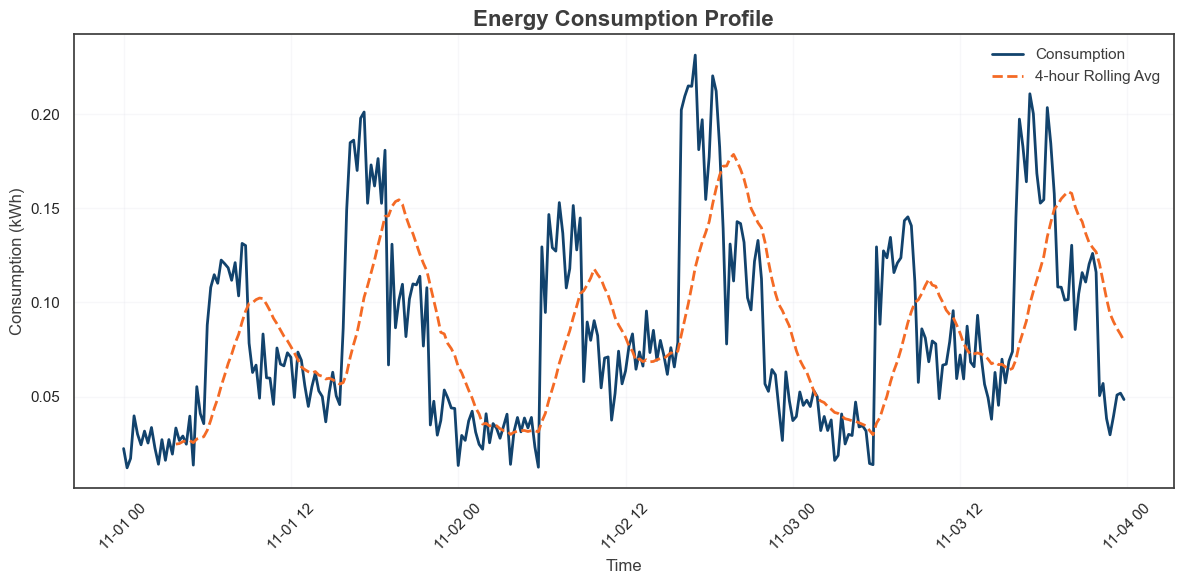

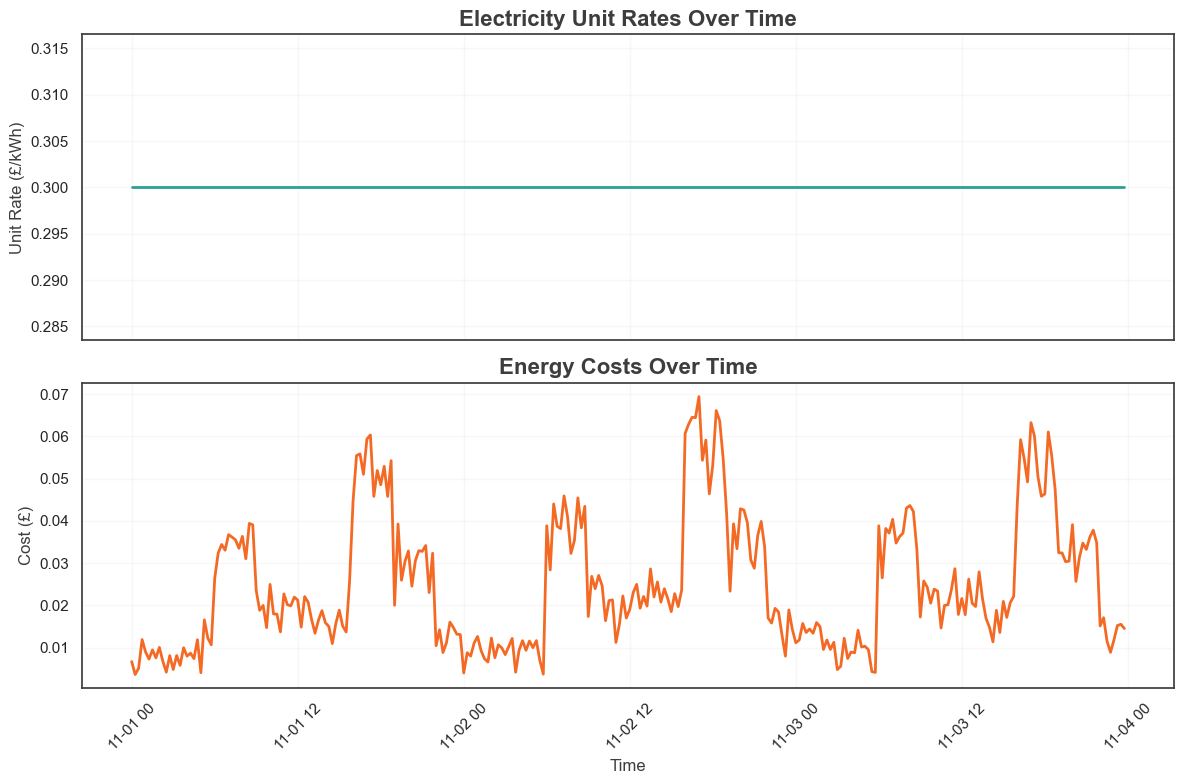

[2025-09-01 02:00:04] [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-09-01 02:00:04] [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


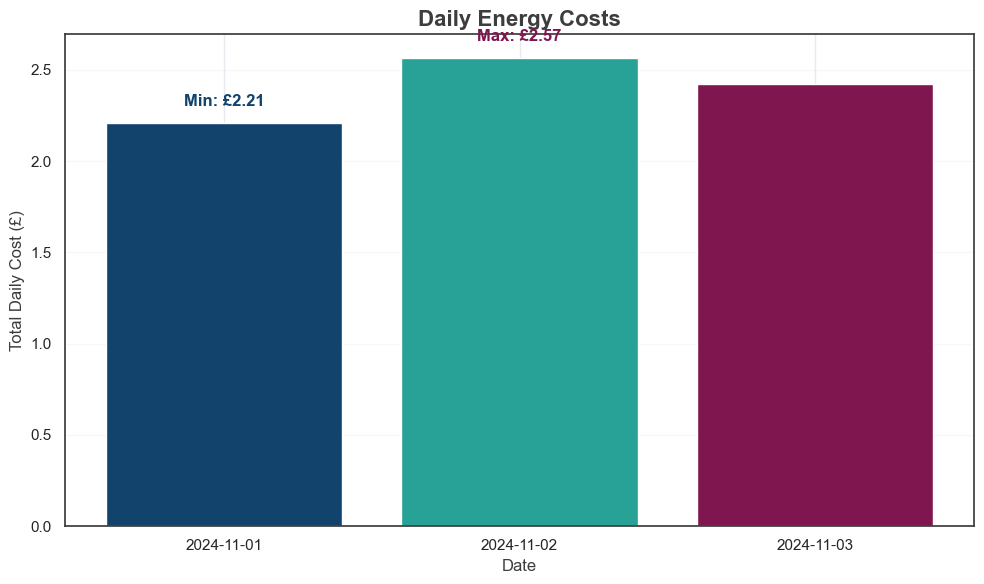

Optimal 4-hour charging window:
Start: 2024-11-01 00:00:00+00:00
End:   2024-11-01 03:45:00+00:00
Total cost: £0.12
Average rate: £0.300/kWh


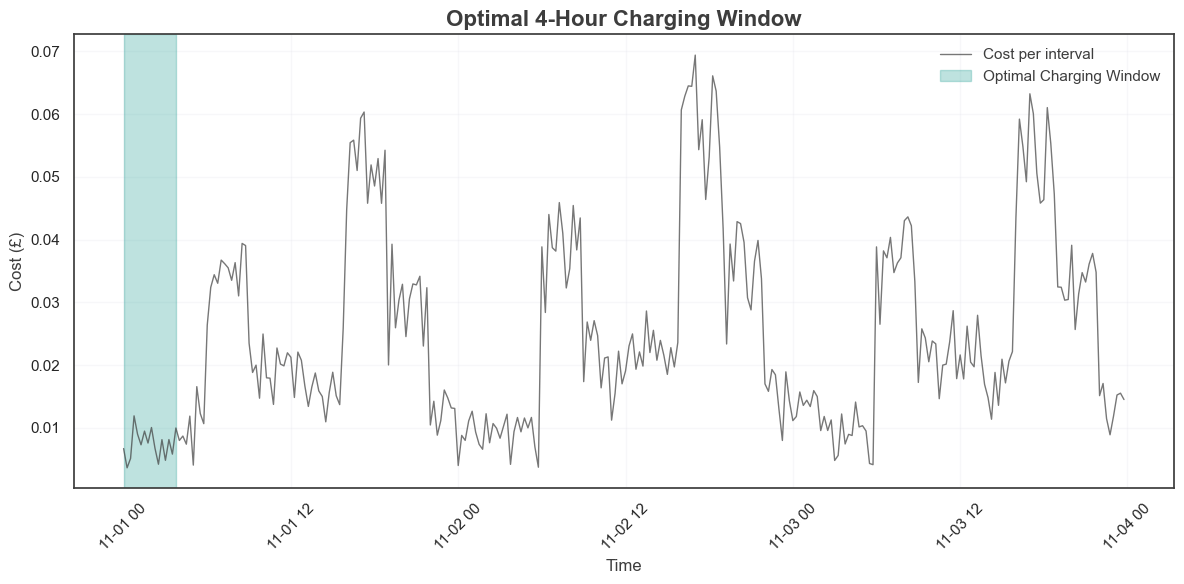

ANALYSIS COMPLETE!
Total cost for 3 days: £7.20
Average daily cost: £2.40
Peak consumption: 0.69 kWh


In [10]:
# =============================================================================
# Generate Realistic Load Profile (3 Days) + Agile Tariff Analysis 
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# ---------------------------------------------------------------------------
# Random seed for reproducibility
# ---------------------------------------------------------------------------
np.random.seed(52)

# ---------------------------------------------------------------------------
# Build 3-day 15-min interval date range
# ---------------------------------------------------------------------------
date_range = pd.date_range(start="2024-11-01", end="2024-11-04", freq="15min", inclusive="left")
n_intervals = len(date_range)

# Convert to daily pattern first, then disaggregate to 15-min intervals
days = np.floor(np.arange(n_intervals) / 96)  # 96 intervals per day
hours = (np.arange(n_intervals) / 4) % 24     # Convert index to hour-of-day

# Base daily consumption (using your Gas statistics as reference)
daily_mean = 38.01  # kWh/day from your data
daily_std = 21.91   # Std from your data (not used directly, but kept for reference)

# Create daily variation (weekday vs weekend pattern)
weekdays = (date_range.weekday < 5)  # Monday-Friday
daily_consumption = np.zeros(len(date_range))

for i in range(len(date_range)):
    if weekdays[i]:
        daily_consumption[i] = daily_mean * (0.9 + 0.2 * np.random.random())  # Weekdays
    else:
        daily_consumption[i] = daily_mean * (1.1 + 0.3 * np.random.random())  # Weekends

# Apply daily pattern to 15-min intervals (disaggregation)
base_profile = np.zeros(n_intervals)

# ---------------------------------------------------------------------------
# Typical UK household time-of-day pattern (15-min intervals)
# ---------------------------------------------------------------------------
for i in range(n_intervals):
    hour = hours[i]
    day_idx = int(days[i])
    
    # Time-of-day pattern (typical household)
    if hour < 6:  # Night (12am-6am): low base load
        proportion = 0.02 + 0.01 * np.random.random()
    elif hour < 9:  # Morning (6am-9am): morning peak
        proportion = 0.08 + 0.04 * np.random.random()
    elif hour < 16:  # Day (9am-4pm): moderate consumption
        proportion = 0.04 + 0.03 * np.random.random()
    elif hour < 19:  # Evening peak (4pm-7pm)
        proportion = 0.12 + 0.06 * np.random.random()
    elif hour < 22:  # Evening (7pm-10pm)
        proportion = 0.07 + 0.04 * np.random.random()
    else:  # Late evening (10pm-12am)
        proportion = 0.03 + 0.02 * np.random.random()
    
    base_profile[i] = daily_consumption[day_idx * 96] * proportion

# ---------------------------------------------------------------------------
# Add appliance spikes (typical household behavior)
# ---------------------------------------------------------------------------
for i in range(n_intervals):
    # 2% chance of a consumption spike (appliance turning on)
    if np.random.random() < 0.02:
        spike_size = 2.0 + 3.0 * np.random.random()  # 2-5 kWh spike
        duration = np.random.randint(2, 9)  # 30min to 2hr spikes (2-8 intervals)
        for j in range(min(duration, n_intervals - i)):
            base_profile[i + j] += spike_size / duration

# ---------------------------------------------------------------------------
# Add random noise (realistic variations)
# ---------------------------------------------------------------------------
noise = np.random.normal(0, 0.3, n_intervals)  # Small random variations
base_profile += noise

# Ensure positive values
base_profile = np.maximum(base_profile, 0.1)

# Normalize to match daily mean (approximately 24 kWh/day as requested)
current_daily_total = base_profile.reshape(-1, 96).sum(axis=1)
normalization_factor = 24 / current_daily_total.mean()
base_profile *= normalization_factor

# ---------------------------------------------------------------------------
# Create DataFrame
# ---------------------------------------------------------------------------
df = pd.DataFrame({
    'timestamp': date_range,
    'consumption_kwh': base_profile
})

# ---------------------------------------------------------------------------
# Display statistics
# ---------------------------------------------------------------------------
print("REALISTIC LOAD PROFILE STATISTICS:")
print(f"Total consumption: {df['consumption_kwh'].sum():.2f} kWh")
print(f"Daily average: {df['consumption_kwh'].sum() / 3:.2f} kWh/day")
print(f"Mean 15-min consumption: {df['consumption_kwh'].mean():.3f} kWh")
print(f"Max 15-min consumption: {df['consumption_kwh'].max():.3f} kWh")
print(f"Min 15-min consumption: {df['consumption_kwh'].min():.3f} kWh")

display(df.head(10))

# =============================================================================
# THEME
# =============================================================================
THEME = {
    "DARK_BLUE": "#12436D",
    "TURQUOISE": "#28A197", 
    "DARK_PINK": "#801650",
    "ORANGE": "#F46A25",
    "DARK_GREY": "#3D3D3D",
    "LIGHT_PURPLE": "#A285D1"
}

PALETTE = [
    THEME["DARK_PINK"],
    THEME["DARK_BLUE"], 
    THEME["ORANGE"],
    THEME["TURQUOISE"],
    THEME["LIGHT_PURPLE"],
    THEME["DARK_GREY"]
]

# Apply the theme to matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=PALETTE)
plt.rcParams['axes.edgecolor'] = THEME["DARK_GREY"]
plt.rcParams['axes.labelcolor'] = THEME["DARK_GREY"]
plt.rcParams['text.color'] = THEME["DARK_GREY"]
plt.rcParams['grid.color'] = "#E6E6EE"

# Apply the theme to seaborn
sns.set_palette(PALETTE)
sns.set_style("whitegrid", {
    "grid.color": "#E6E6EE",
    "axes.edgecolor": THEME["DARK_GREY"],
    "axes.labelcolor": THEME["DARK_GREY"],
    "text.color": THEME["DARK_GREY"]
})

# =============================================================================
# Tariff Calculator with Agile Pricing
# (Assumes a TariffCalculator class is available in your environment)
# =============================================================================
calculator = TariffCalculator(
    consumption_df=df,
    region_code="C",            # Manchester area (Octopus Agile region)
    normalize_to_kwh=24         # Normalize to 24 kWh per day
)

# Extract interval data (unit_rate, cost, etc.)
interval_df = calculator.df.copy()

# Create a 'period' column based on the hour of the timestamp if it does not exist.
if 'period' not in interval_df.columns:
    interval_df['period'] = interval_df['timestamp'].dt.hour

# Map unit rates from calculator; fall back to £0.30/kWh if hour missing
interval_df['unit_rate'] = interval_df['period'].map(calculator.rates).fillna(0.30)
interval_df['cost'] = interval_df['consumption_kwh'] * interval_df['unit_rate']

# =============================================================================
# VISUALIZATIONS (Theme-Aligned)
# =============================================================================
print("\nGENERATING VISUALIZATIONS...")

# ---------------------------------------------------------------------------
# Plot energy consumption pattern
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(interval_df['timestamp'], interval_df['consumption_kwh'], 
        color=THEME["DARK_BLUE"], linewidth=2, label='Consumption')

# Add rolling average (4-hour = 16 intervals)
rolling_avg = interval_df['consumption_kwh'].rolling(window=16).mean()
ax.plot(interval_df['timestamp'], rolling_avg, 
        color=THEME["ORANGE"], linewidth=2, linestyle='--', label='4-hour Rolling Avg')

ax.set_xlabel('Time')
ax.set_ylabel('Consumption (kWh)')
ax.set_title('Energy Consumption Profile', fontsize=16, fontweight='bold', color=THEME["DARK_GREY"])
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Plot interval unit rate and cost
# ---------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Unit rate plot
ax1.plot(interval_df['timestamp'], interval_df['unit_rate'], 
         color=THEME["TURQUOISE"], linewidth=2)
ax1.set_ylabel('Unit Rate (£/kWh)')
ax1.set_title('Electricity Unit Rates Over Time', fontsize=16, fontweight='bold', color=THEME["DARK_GREY"])
ax1.grid(True, alpha=0.3)

# Highlight peak pricing periods
peak_threshold = interval_df['unit_rate'].quantile(0.8)
peak_mask = interval_df['unit_rate'] > peak_threshold
ax1.fill_between(interval_df['timestamp'], 0, interval_df['unit_rate'], 
                 where=peak_mask, color=THEME["DARK_PINK"], alpha=0.3, label='Peak Pricing')

# Cost plot
ax2.plot(interval_df['timestamp'], interval_df['cost'], 
         color=THEME["ORANGE"], linewidth=2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Cost (£)')
ax2.set_title('Energy Costs Over Time', fontsize=16, fontweight='bold', color=THEME["DARK_GREY"])
ax2.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================================================================
# DAILY SUMMARY (Fixed: build from interval_df so 'total_cost' exists)
# =============================================================================
interval_df['date'] = interval_df['timestamp'].dt.date

daily_summary = (
    interval_df
    .groupby('date', as_index=False)
    .agg(
        total_kwh=('consumption_kwh', 'sum'),
        total_cost=('cost', 'sum')
    )
)

# Average rate for context
daily_summary['avg_rate'] = daily_summary['total_cost'] / daily_summary['total_kwh']

# Ensure datetime for nice formatting
daily_summary['date'] = pd.to_datetime(daily_summary['date'])

# ---------------------------------------------------------------------------
# Plot total daily costs (Theme-aligned)
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
labels = daily_summary['date'].dt.strftime('%Y-%m-%d')

# Use your palette consistently; trim to number of bars
bar_colors = [THEME["DARK_BLUE"], THEME["TURQUOISE"], THEME["DARK_PINK"]][:len(labels)]
bars = ax.bar(labels, daily_summary['total_cost'], color=bar_colors)

ax.set_xlabel('Date')
ax.set_ylabel('Total Daily Cost (£)')
ax.set_title('Daily Energy Costs', fontsize=16, fontweight='bold', color=THEME["DARK_GREY"])
ax.grid(True, alpha=0.3, axis='y')

# Annotate min and max days safely
min_idx = daily_summary['total_cost'].idxmin()
max_idx = daily_summary['total_cost'].idxmax()

def _bar_center(b):
    return b.get_x() + b.get_width() / 2

min_x = _bar_center(bars[min_idx])
max_x = _bar_center(bars[max_idx])

ax.annotate(f"Min: £{daily_summary.loc[min_idx, 'total_cost']:.2f}",
            xy=(min_x, daily_summary.loc[min_idx, 'total_cost']),
            xytext=(0, 10), textcoords='offset points',
            ha='center', va='bottom', fontweight='bold',
            color=THEME["DARK_BLUE"])

ax.annotate(f"Max: £{daily_summary.loc[max_idx, 'total_cost']:.2f}",
            xy=(max_x, daily_summary.loc[max_idx, 'total_cost']),
            xytext=(0, 10), textcoords='offset points',
            ha='center', va='bottom', fontweight='bold',
            color=THEME["DARK_PINK"])

plt.tight_layout()
plt.show()

# =============================================================================
# Cheapest 4-hour charging window
# =============================================================================
window_size = 16  # 4 hours in 15-min intervals
min_cost_window = None
min_cost = float('inf')

for i in range(len(interval_df) - window_size + 1):
    window_cost = interval_df['cost'].iloc[i:i+window_size].sum()
    if window_cost < min_cost:
        min_cost = window_cost
        min_cost_window = i

if min_cost_window is not None:
    start_time = interval_df['timestamp'].iloc[min_cost_window]
    end_time = interval_df['timestamp'].iloc[min_cost_window + window_size - 1]
    window_kwh = interval_df['consumption_kwh'].iloc[min_cost_window:min_cost_window+window_size].sum()
    avg_rate = (min_cost / window_kwh) if window_kwh > 0 else float('nan')
    
    print(f"Optimal 4-hour charging window:")
    print(f"Start: {start_time}")
    print(f"End:   {end_time}")
    print(f"Total cost: £{min_cost:.2f}")
    print(f"Average rate: £{avg_rate:.3f}/kWh")
    
    # Plot the optimal charging window
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(interval_df['timestamp'], interval_df['cost'], 
            color=THEME["DARK_GREY"], linewidth=1, alpha=0.7, label='Cost per interval')
    ax.axvspan(start_time, end_time, alpha=0.3, color=THEME["TURQUOISE"], 
               label='Optimal Charging Window')
    ax.set_xlabel('Time')
    ax.set_ylabel('Cost (£)')
    ax.set_title('Optimal 4-Hour Charging Window', fontsize=16, fontweight='bold', color=THEME["DARK_GREY"])
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# =============================================================================
# FINAL SUMMARY PRINTS
# =============================================================================
print("ANALYSIS COMPLETE!")
print(f"Total cost for 3 days: £{daily_summary['total_cost'].sum():.2f}")
print(f"Average daily cost: £{daily_summary['total_cost'].mean():.2f}")
print(f"Peak consumption: {df['consumption_kwh'].max():.2f} kWh")


In [11]:
# ╔════════════════════════════╗
# ║         ENERGY MODELING    ║
# ╚════════════════════════════╝

from typing import List
from sklearn.inspection import permutation_importance


# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class EnergyModeler:
    """
    Flexible regression modeling class with comprehensive modeling capabilities.
    
    Handles data preparation, model training/evaluation, hyperparameter tuning,
    and model interpretation for energy forecasting tasks.

    Attributes:
        df (pd.DataFrame): Cleaned input data
        target (str): Target variable for regression
        scale_features (bool): Whether to scale numeric features
        test_size (float): Proportion of data for test set (0.0-1.0)
        scoring (str): Scoring metric for model evaluation
        best_metric (str): Metric to determine best model
        time_series (bool): Whether data is time-series
        feature_groups (dict): Optional feature groupings
        random_state (int): Random seed for reproducibility
        models (dict): Dictionary of trained model pipelines
        results (pd.DataFrame): Model evaluation results
    """

    def __init__(
        self,
        df_cleaned: pd.DataFrame,
        target: str = None,
        scale_features: bool = True,
        test_size: float = 0.2,
        scoring: str = "r2",
        time_series: bool = False,
        best_metric: str = "Test R2",
        feature_groups: Optional[Dict] = None,
        random_state: int = 42
    ):
        """Initialize the EnergyModeler with data and configuration.
        
        Args:
            df_cleaned: Preprocessed DataFrame containing features and target
            target: Name of target column. If None, will use first numeric column
            scale_features: Whether to scale numeric features
            test_size: Proportion of data to use for testing (0.0-1.0)
            scoring: Metric to optimize during model selection
            time_series: Whether data is time-series (affects train-test split)
            best_metric: Metric to use for selecting best model
            feature_groups: Optional dictionary of feature groupings
            random_state: Random seed for reproducibility
        """
        # Validate input data
        if not isinstance(df_cleaned, pd.DataFrame) or df_cleaned.empty:
            raise ValueError("Input must be a non-empty pandas DataFrame")

        self.df = df_cleaned.copy()
        self.scale_features = scale_features
        self.test_size = test_size
        self.scoring = scoring
        self.best_metric = best_metric
        self.time_series = time_series
        self.feature_groups = feature_groups or {}
        self.random_state = random_state
        self.logger = logging.getLogger(self.__class__.__name__)
        self.models = {}
        self.results = pd.DataFrame()

        # Set target column
        self._validate_and_set_target(target)

        # Initial data checks
        self._perform_initial_checks()

        # Split data into features and target
        self.X = self.df.drop(columns=[self.target])
        self.y = self.df[self.target]

        # Perform train-test split
        self._split_data()

        # Initialize default models
        self.default_models = self._create_default_models()

    def _validate_and_set_target(self, target: Optional[str]) -> None:
        """Validate and set the target variable."""
        if target is None:
            numeric_cols = self.df.select_dtypes(include=np.number).columns.tolist()
            if not numeric_cols:
                raise ValueError("No numeric columns available for regression target")
            target = numeric_cols[0]
            self.logger.warning(f"Inferred target column: '{target}'")
        
        if target not in self.df.columns:
            raise ValueError(f"Target column '{target}' not found in DataFrame")
        
        if self.df[target].isna().all():
            raise ValueError(f"Target column '{target}' contains only null values")
        
        self.target = target

    def _perform_initial_checks(self) -> None:
        """Perform initial data quality checks."""
        # Check for sufficient samples
        if len(self.df) < 10:
            warnings.warn(
                "Very small dataset (<10 samples) - results may be unreliable",
                UserWarning
            )
        elif len(self.df) < 50:
            warnings.warn(
                "Small dataset (<50 samples) - metrics like R² may be unstable",
                UserWarning
            )

        # Check test_size validity
        if not 0 < self.test_size < 1:
            raise ValueError(f"test_size must be between 0 and 1, got {self.test_size}")

        # Drop rows with null target values
        initial_size = len(self.df)
        self.df = self.df.dropna(subset=[self.target])
        if len(self.df) < initial_size:
            self.logger.warning(
                f"Dropped {initial_size - len(self.df)} rows with null target values"
            )

    def _split_data(self) -> None:
        """Split data into training and test sets.
        
        Handles both time-series and standard random splits.
        """
        min_samples = 5  # Minimum samples needed for meaningful split
        
        if len(self.df) < min_samples:
            raise ValueError(
                f"Need at least {min_samples} samples for train-test split, "
                f"got {len(self.df)}"
            )

        if self.time_series:
            # Time-series split (chronological)
            idx = int((1 - self.test_size) * len(self.df))
            self.X_train, self.X_test = self.X.iloc[:idx], self.X.iloc[idx:]
            self.y_train, self.y_test = self.y.iloc[:idx], self.y.iloc[idx:]
        else:
            # Random split
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                self.X,
                self.y,
                test_size=self.test_size,
                random_state=self.random_state
            )

        self.logger.info(
            f"Data split complete - Train: {len(self.X_train)}, "
            f"Test: {len(self.X_test)} samples"
        )

    def _create_default_models(self) -> Dict[str, Pipeline]:
        """Create default model registry with basic regression models."""
        models = {
            "Random Forest": RandomForestRegressor(random_state=self.random_state),
            "Gradient Boosting": GradientBoostingRegressor(random_state=self.random_state),
            "Linear Regression": LinearRegression()
        }
        # Wrap each model in a pipeline
        return {name: self._build_pipeline(model) for name, model in models.items()}

    def _build_pipeline(self, model) -> Pipeline:
        """Build preprocessing pipeline for the given model.
        
        Args:
            model: Scikit-learn compatible regressor
            
        Returns:
            Configured Pipeline with preprocessing and model
        """
        numeric_cols = self.X.select_dtypes(include=np.number).columns.tolist()
        categorical_cols = self.X.select_dtypes(include="object").columns.tolist()
        
        transformers = []
        
        # Numeric feature processing
        if numeric_cols:
            if self.scale_features:
                transformers.append(("num", StandardScaler(), numeric_cols))
            else:
                transformers.append(("num", "passthrough", numeric_cols))
        
        # Categorical feature processing
        if categorical_cols:
            transformers.append(
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
            )
        
        preprocessor = ColumnTransformer(transformers=transformers)
        return Pipeline([
            ("preprocessor", preprocessor),
            ("regressor", model)
        ])

    def add_model(self, name: str, model) -> None:
        """Add a model to the model registry.
        
        Args:
            name: Identifier for the model
            model: Scikit-learn compatible regressor
            
        Raises:
            ValueError: If model is not a regressor
        """
        if not is_regressor(model):
            raise ValueError("Model must be a scikit-learn regressor")
        self.models[name] = self._build_pipeline(model)

    def evaluate_models(
        self,
        cv: int = 5,
        log_cv: bool = False
    ) -> pd.DataFrame:
        """Evaluate all registered models using cross-validation.
        
        Args:
            cv: Number of cross-validation folds
            log_cv: Whether to log CV scores during evaluation
            
        Returns:
            DataFrame with evaluation metrics for all models
        """
        if not self.models:
            self.logger.info("No models registered - using default models")
            for name, model in self.default_models.items():
                self.add_model(name, model)

        results = []
        splitter = TimeSeriesSplit(n_splits=cv) if self.time_series else cv

        for name, model in self.models.items():
            self.logger.info(f"Evaluating model: {name}")
            
            try:
                # Fit model and make predictions
                model.fit(self.X_train, self.y_train)
                y_train_pred = model.predict(self.X_train)
                y_test_pred = model.predict(self.X_test)
                
                # Cross-validation
                cv_scores = cross_val_score(
                    model,
                    self.X,
                    self.y,
                    cv=splitter,
                    scoring=self.scoring
                )

                if log_cv:
                    self.logger.info(f"CV scores for {name}: {cv_scores}")

                # Calculate metrics
                metrics = {
                    "Model": name,
                    "Train R2": r2_score(self.y_train, y_train_pred),
                    "Test R2": r2_score(self.y_test, y_test_pred),
                    "Test MAE": mean_absolute_error(self.y_test, y_test_pred),
                    "Test RMSE": np.sqrt(mean_squared_error(self.y_test, y_test_pred)),
                    f"{self.scoring.upper()} CV Mean": np.mean(cv_scores),
                    f"{self.scoring.upper()} CV Std": np.std(cv_scores)
                }
                results.append(metrics)

            except Exception as e:
                self.logger.error(f"Error evaluating model {name}: {str(e)}")
                continue

        self.results = pd.DataFrame(results)
        return self.results

    def tune_model(
        self,
        model_name: str,
        param_grid: Dict,
        cv: int = 5,
        use_random: bool = False,
        n_iter: int = 10,
        scoring: Optional[str] = None,
        refit: Optional[str] = None
    ) -> Dict:
        """Perform hyperparameter tuning for a specified model.
        
        Args:
            model_name: Name of model to tune (must be in registry)
            param_grid: Parameter grid for tuning
            cv: Number of cross-validation folds
            use_random: Whether to use random search (vs grid search)
            n_iter: Number of iterations for random search
            scoring: Metric to optimize (defaults to instance scoring)
            refit: Whether to refit best model (default True if scoring provided)
            
        Returns:
            Dictionary of best parameters found
            
        Raises:
            ValueError: If model_name not found in registry
        """
        if model_name not in self.models:
            raise ValueError(f"Model '{model_name}' not found in registry")

        search_class = RandomizedSearchCV if use_random else GridSearchCV
        
        search_params = {
            "estimator": self.models[model_name],
            "param_grid" if not use_random else "param_distributions": param_grid,
            "scoring": scoring or self.scoring,
            "cv": TimeSeriesSplit(n_splits=cv) if self.time_series else cv,
            "n_jobs": -1,
            "verbose": 1,
            "return_train_score": True,
            "random_state": self.random_state
        }
        
        if use_random:
            search_params["n_iter"] = n_iter
        if refit is not None:
            search_params["refit"] = refit

        search = search_class(**search_params)
        search.fit(self.X_train, self.y_train)
        
        # Update model with best estimator
        self.models[model_name] = search.best_estimator_
        
        self.logger.info(
            f"Best parameters for {model_name}: {search.best_params_}\n"
            f"Best {scoring or self.scoring} score: {search.best_score_:.4f}"
        )
        
        return search.best_params_

    def get_predictions_dataframe(self) -> pd.DataFrame:
        """Get predictions from best performing model.
        
        Returns:
            DataFrame with actual and predicted values
            
        Raises:
            ValueError: If no models have been evaluated
        """
        if self.results.empty:
            raise ValueError("No evaluation results - run evaluate_models() first")

        if self.best_metric not in self.results.columns:
            raise ValueError(
                f"Best metric '{self.best_metric}' not found in results. "
                f"Available metrics: {list(self.results.columns)}"
            )

        # Determine sort order based on metric type
        ascending = "MAE" in self.best_metric or "RMSE" in self.best_metric
        
        best_model_name = self.results.sort_values(
            self.best_metric,
            ascending=ascending
        )["Model"].iloc[0]
        
        model = self.models[best_model_name]
        predictions = model.predict(self.X_test)
        
        return pd.DataFrame({
            "actual": self.y_test.values,
            "predicted": predictions
        })

    def plot_model_comparison(self) -> plt.Figure:
        """Create comparison plots of model metrics.
        
        Returns:
            Matplotlib Figure object
            
        Raises:
            ValueError: If no evaluation results exist
        """
        if self.results.empty:
            raise ValueError("No results to plot - run evaluate_models() first")

        # Get numeric metrics (excluding Train R2 if present)
        plot_metrics = [
            col for col in self.results.select_dtypes(include=np.number).columns
            if col != "Train R2"
        ]
        
        n_metrics = len(plot_metrics)
        fig, axes = plt.subplots(
            1,
            n_metrics,
            figsize=(6 * n_metrics, 5),
            squeeze=False
        )
        axes = axes.flatten()
        
        for i, metric in enumerate(plot_metrics):
            ax = axes[i]
            sns.barplot(
                x="Model",
                y=metric,
                data=self.results,
                ax=ax,
                palette="viridis",
                hue="Model",
                legend=False
            )
            ax.set_title(metric.replace("_", " ").title())
            ax.tick_params(axis="x", rotation=45)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

    def feature_importance(
        self,
        model_name: str,
        top_n: Optional[int] = None
    ) -> pd.Series:
        """Get feature importance from tree-based models.
        
        Args:
            model_name: Name of trained model
            top_n: Number of top features to return (None for all)
            
        Returns:
            Series of feature importances
            
        Raises:
            ValueError: If model not found or doesn't support feature importance
        """
        if model_name not in self.models:
            raise ValueError(f"Model '{model_name}' not found in registry")

        pipeline = self.models[model_name]
        model = pipeline.named_steps["regressor"]
        
        if not hasattr(model, "feature_importances_"):
            raise ValueError(
                f"Model '{model_name}' doesn't support feature_importances_"
            )

        # Get feature names after preprocessing
        preprocessor = pipeline.named_steps["preprocessor"]
        feature_names = self._get_feature_names(preprocessor)
        
        # Handle potential mismatch between features and importances
        importances = model.feature_importances_
        if len(feature_names) != len(importances):
            min_len = min(len(feature_names), len(importances))
            warnings.warn(
                f"Feature names ({len(feature_names)}) and importances "
                f"({len(importances)}) mismatch. Using first {min_len}."
            )
            feature_names = feature_names[:min_len]
            importances = importances[:min_len]
        
        # Create and sort importance series
        importance_series = pd.Series(importances, index=feature_names)
        importance_series = importance_series.sort_values(ascending=False)
        
        return importance_series.iloc[:top_n] if top_n else importance_series

    def _get_feature_names(self, preprocessor: ColumnTransformer) -> List[str]:
        """Get feature names after preprocessing transformations.
        
        Args:
            preprocessor: Fitted ColumnTransformer
            
        Returns:
            List of feature names
        """
        feature_names = []
        
        for name, transformer, columns in preprocessor.transformers_:
            if transformer == "passthrough":
                feature_names.extend(columns)
            elif hasattr(transformer, "get_feature_names_out"):
                try:
                    names = transformer.get_feature_names_out(columns)
                    feature_names.extend(names)
                except Exception as e:
                    self.logger.warning(
                        f"Could not get feature names from {name}: {str(e)}"
                    )
                    feature_names.extend(columns)
            else:
                feature_names.extend(columns)
                
        return feature_names

    def permutation_importance(
        self,
        model_name: str,
        n_repeats: int = 10,
        random_state: int = 0
    ) -> pd.Series:
        """Compute permutation importance for model features.
        
        Args:
            model_name: Name of trained model
            n_repeats: Number of permutation repeats
            random_state: Random seed for reproducibility
            
        Returns:
            Series of permutation importances (mean)
            
        Raises:
            ValueError: If model not found
        """
        if model_name not in self.models:
            raise ValueError(f"Model '{model_name}' not found in registry")

        model = self.models[model_name]
        
        result = permutation_importance(
            model,
            self.X_test,
            self.y_test,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1
        )
        
        return pd.Series(
            result.importances_mean,
            index=self.X.columns
        ).sort_values(ascending=False)

    def shap_explainer(
        self,
        model_name: str,
        max_display: int = 10,
        sample_size: Optional[int] = None
    ) -> None:
        """Generate SHAP explanations for model predictions.
        
        Args:
            model_name: Name of trained model
            max_display: Maximum features to display
            sample_size: Number of samples to use (None for all)
            
        Raises:
            ValueError: If model not found or SHAP not available
        """
        try:
            import shap
        except ImportError:
            raise ImportError("SHAP library not installed - pip install shap")
            
        if model_name not in self.models:
            raise ValueError(f"Model '{model_name}' not found in registry")

        pipeline = self.models[model_name]
        model = pipeline.named_steps["regressor"]
        
        # Transform test data
        X_transformed = pipeline.named_steps["preprocessor"].transform(self.X_test)
        
        # Sample data if requested
        if sample_size and sample_size < X_transformed.shape[0]:
            rng = np.random.RandomState(self.random_state)
            sample_idx = rng.choice(
                X_transformed.shape[0],
                size=min(sample_size, X_transformed.shape[0]),
                replace=False
            )
            X_transformed = X_transformed[sample_idx]
        
        # Create explainer and plot
        explainer = shap.Explainer(model, X_transformed)
        shap_values = explainer(X_transformed)
        
        # Plot different visualizations
        shap.plots.bar(shap_values, max_display=max_display)
        shap.plots.beeswarm(shap_values, max_display=max_display)

    def export_results(
        self,
        path: str,
        format: str = "csv",
        include_timestamp: bool = True
    ) -> None:
        """Export evaluation results to file.
        
        Args:
            path: Output file path
            format: Export format ('csv' or 'md')
            include_timestamp: Whether to append timestamp to filename
            
        Raises:
            ValueError: If no results or invalid format
        """
        if self.results.empty:
            raise ValueError("No results to export - run evaluate_models() first")
            
        if format.lower() not in ("csv", "md"):
            raise ValueError("Format must be 'csv' or 'md'")

        # Add timestamp if requested
        if include_timestamp:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            path = f"{path.rsplit('.', 1)[0]}_{timestamp}.{format.lower()}"
            
        # Export in requested format
        if format.lower() == "csv":
            self.results.to_csv(path, index=False)
        else:
            with open(path, "w") as f:
                f.write(self.results.to_markdown(index=False))
                
        self.logger.info(f"Results exported to {path}")

    def save_model(self, model_name: str, path: str) -> None:
        """Save trained model to disk.
        
        Args:
            model_name: Name of model to save
            path: Output file path
            
        Raises:
            ValueError: If model not found
        """
        if model_name not in self.models:
            raise ValueError(f"Model '{model_name}' not found in registry")
            
        joblib.dump(self.models[model_name], path)
        self.logger.info(f"Model '{model_name}' saved to {path}")

    def load_model(self, model_name: str, path: str) -> None:
        """Load trained model from disk.
        
        Args:
            model_name: Name to register model under
            path: Path to saved model file
            
        Raises:
            FileNotFoundError: If path doesn't exist
            ValueError: If loaded object is not a valid model
        """
        try:
            model = joblib.load(path)
            if not is_regressor(model):
                raise ValueError("Loaded object is not a scikit-learn regressor")
            self.models[model_name] = model
            self.logger.info(f"Model '{model_name}' loaded from {path}")
        except FileNotFoundError:
            raise FileNotFoundError(f"No model found at {path}")


# ---------------------- USAGE EXAMPLE ----------------------

def main():
    """Example usage of the EnergyModeler class."""
    try:
        # Initialize with sample data
        sample_data = {
            "timestamp": pd.date_range(start="2023-01-01", periods=100, freq="D"),
            "consumption": np.random.normal(100, 20, 100),
            "temperature": np.random.uniform(10, 30, 100),
            "is_weekend": np.random.choice([0, 1], 100)
        }
        df = pd.DataFrame(sample_data)
        
        # Initialize modeler
        modeler = EnergyModeler(
            df_cleaned=df,
            target="consumption",
            scale_features=True,
            test_size=0.2,
            time_series=False,
            scoring="neg_mean_absolute_error",
            best_metric="Test MAE",
            random_state=42
        )
        
        # Add custom model
        modeler.add_model(
            "Quick RF",
            RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
        )
        
        # Evaluate models
        results = modeler.evaluate_models(cv=5)
        print("\nModel Evaluation Results:")
        print(results.to_markdown())
        
        # Visual comparison
        fig = modeler.plot_model_comparison()
        plt.show()
        
        # Get feature importance
        importance = modeler.feature_importance("Quick RF", top_n=5)
        print("\nTop 5 Feature Importances:")
        print(importance.to_markdown())
        
        # SHAP explanation
        modeler.shap_explainer("Quick RF", max_display=5)
        
        # Export results
        modeler.export_results("model_results", format="md")
        
    except Exception as e:
        logger.error(f"Error in modeling pipeline: {str(e)}")
        raise


In [12]:
# ╔═══════════════════════════════╗
# ║         CONSUMPTION CLUSTER   ║
# ╚═══════════════════════════════╝
from typing import List

class ConsumptionClusterer:
    """
    Performs clustering on consumption-related features using K-Means,
    with optional PCA-based dimensionality reduction for 2D visualization.
    """

    def __init__(
        self,
        df: pd.DataFrame,
        features: List[str],
        random_state: int = 42
    ) -> None:
        """
        Initialize the clusterer.

        Parameters:
        - df (pd.DataFrame): Dataset containing energy usage features.
        - features (List[str]): Column names used for clustering.
        - random_state (int): Seed for reproducibility (default=42).
        """
        self.df = df.copy()
        self.features = features
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.logger = logging.getLogger(self.__class__.__name__)

    def find_optimal_clusters(self, max_k: int = 10) -> Tuple[plt.Figure, List[float]]:
        """
        Applies the elbow method to help identify the optimal number of clusters.

        Parameters:
        - max_k (int): Maximum number of clusters to evaluate.

        Returns:
        - fig (plt.Figure): Elbow plot figure.
        - inertias (List[float]): Inertia values for each cluster count.
        """
        scaled_data = self.scaler.fit_transform(self.df[self.features])
        inertias: List[float] = []

        for k in range(1, max_k + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state, n_init=10)
            kmeans.fit(scaled_data)
            inertias.append(kmeans.inertia_)

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(range(1, max_k + 1), inertias, marker='o')
        ax.set_title("Elbow Method for Optimal k")
        ax.set_xlabel("Number of Clusters (k)")
        ax.set_ylabel("Inertia")
        ax.grid(alpha=0.3)
        fig.tight_layout()

        return fig, inertias

    def cluster_and_visualize(self, n_clusters: int = 3) -> Tuple[plt.Figure, pd.DataFrame]:
        """
        Performs K-Means clustering and PCA-based visualization.

        Parameters:
        - n_clusters (int): Number of clusters to form (default=3).

        Returns:
        - fig (plt.Figure): Scatter plot of PCA-reduced clusters.
        - result_df (pd.DataFrame): Original dataframe with 'cluster', 'pc1', 'pc2' columns added.
        """
        scaled_data = self.scaler.fit_transform(self.df[self.features])

        # K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=self.random_state, n_init=10)
        labels = kmeans.fit_predict(scaled_data)

        # PCA projection to 2D
        pca = PCA(n_components=2, random_state=self.random_state)
        reduced = pca.fit_transform(scaled_data)

        # Prepare output dataframe
        result_df = self.df.copy()
        result_df["cluster"] = labels
        result_df["pc1"] = reduced[:, 0]
        result_df["pc2"] = reduced[:, 1]

        # Plot the clusters in reduced 2D space
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.scatterplot(
            x="pc1",
            y="pc2",
            hue="cluster",
            data=result_df,
            palette="viridis",
            ax=ax
        )
        ax.set_title("Consumption Clusters (PCA Reduced)")
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.grid(alpha=0.3)
        fig.tight_layout()

        return fig, result_df

In [13]:
# ╔════════════════════════════╗
# ║         FORECASTING        ║
# ╚════════════════════════════╝

# Configure global logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class Forecaster:
    """
    A forecasting utility using ARIMA, Prophet, and LSTM models.
    Supports comparison of performance, plotting, and saving results.
    """

    def __init__(self, horizon: int = 7, scale: bool = True):
        self.horizon = horizon
        self.scale = scale
        self.scaler = StandardScaler() if scale else None
        self.logger = logging.getLogger(self.__class__.__name__)

    def arima_forecast(self, series: pd.Series) -> Tuple[np.ndarray, float]:
        """Perform ARIMA forecast."""
        from statsmodels.tsa.arima.model import ARIMA
        start = pd.Timestamp.now()
        try:
            if series.index.freq is None:
                series = series.asfreq('D')  # Ensure frequency
                self.logger.info("Added daily frequency to ARIMA input series")

            model = ARIMA(series, order=(1, 1, 1))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=self.horizon)
            runtime = (pd.Timestamp.now() - start).total_seconds()
            self.logger.info(f"ARIMA forecast completed in {runtime:.2f}s")
            return np.asarray(forecast.values), runtime
        except Exception as e:
            self.logger.error(f"ARIMA forecast failed: {e}")
            return np.zeros(self.horizon), 0.0

    def prophet_forecast(self, df: pd.DataFrame) -> Tuple[np.ndarray, float]:
        """Perform Prophet forecast."""
        try:
            from prophet import Prophet
        except ImportError:
            self.logger.warning("Prophet not installed.")
            return np.zeros(self.horizon), 0.0

        start = pd.Timestamp.now()
        try:
            if len(df) < 2:
                self.logger.warning("Prophet needs at least 2 data points")
                return np.zeros(self.horizon), 0.0

            model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
            model.fit(df)
            future = model.make_future_dataframe(periods=self.horizon, freq="D")
            forecast = model.predict(future)
            runtime = (pd.Timestamp.now() - start).total_seconds()
            self.logger.info(f"Prophet forecast completed in {runtime:.2f}s")
            return forecast["yhat"].tail(self.horizon).values, runtime
        except Exception as e:
            self.logger.error(f"Prophet forecast failed: {e}")
            return np.zeros(self.horizon), 0.0

    def improved_lstm_forecast(self, series: pd.Series) -> Tuple[np.ndarray, float]:
        """Improved LSTM forecast with validation, early stopping, and deeper network."""
        from keras.models import Sequential
        from keras.layers import LSTM, Dense, Input
        from keras.optimizers import Adam
        from keras.callbacks import EarlyStopping

        if len(series) < 30:  # TODO: Tune minimum threshold as needed
            self.logger.warning("Insufficient data for LSTM (min 30 required)")
            return np.zeros(self.horizon), 0.0

        start = pd.Timestamp.now()
        try:
            values = series.values.reshape(-1, 1)
            values_scaled = self.scaler.fit_transform(values) if self.scaler else values

            look_back = min(7, len(values_scaled) - 1)
            X, y = [], []
            for i in range(len(values_scaled) - look_back):
                X.append(values_scaled[i:i + look_back, 0])
                y.append(values_scaled[i + look_back, 0])

            if not X:
                self.logger.warning("Could not create sequences for LSTM")
                return np.zeros(self.horizon), 0.0

            X = np.array(X).reshape(-1, 1, look_back)
            y = np.array(y)

            model = Sequential([
                Input(shape=(1, look_back)),
                LSTM(64, return_sequences=True),
                LSTM(32),
                Dense(1)
            ])
            model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
            early_stop = EarlyStopping(monitor='loss', patience=3)
            model.fit(X, y, epochs=50, batch_size=8, callbacks=[early_stop], verbose=0)

            last_seq = values_scaled[-look_back:].flatten().tolist()
            preds = []
            for _ in range(self.horizon):
                x_input = np.array(last_seq).reshape(1, 1, look_back)
                pred = model.predict(x_input, verbose=0)
                preds.append(pred[0, 0])
                last_seq.pop(0)
                last_seq.append(pred[0, 0])

            preds = np.array(preds).reshape(-1, 1)
            preds = self.scaler.inverse_transform(preds) if self.scaler else preds
            runtime = (pd.Timestamp.now() - start).total_seconds()
            self.logger.info(f"LSTM forecast completed in {runtime:.2f}s")
            return preds.flatten(), runtime
        except Exception as e:
            self.logger.error(f"LSTM forecast failed: {e}")
            return np.zeros(self.horizon), 0.0

    def compare_forecasts(self, daily_df: pd.DataFrame, return_errors: bool = False) -> Union[Tuple[pd.DataFrame, pd.DataFrame], Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]]:
        """Compare forecasts and optionally return error metrics."""
        self.logger.info("Starting forecast comparison...")
        if not {"date", "demand"}.issubset(daily_df.columns):
            raise ValueError("Input must contain 'date' and 'demand' columns.")

        df = daily_df.copy()
        df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
        df = df.dropna(subset=["date"])

        if len(df) < 2:
            self.logger.warning("Insufficient data for forecasting")
            return pd.DataFrame(), pd.DataFrame()

        series = df.set_index("date")["demand"]
        prophet_input = df.rename(columns={"date": "ds", "demand": "y"})

        arima_pred, arima_time = self.arima_forecast(series)
        prophet_pred, prophet_time = self.prophet_forecast(prophet_input)
        lstm_pred, lstm_time = self.improved_lstm_forecast(series)

        future_dates = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=self.horizon, freq="D")

        forecast_df = pd.DataFrame({
            "ARIMA": arima_pred,
            "Prophet": prophet_pred,
            "LSTM": lstm_pred
        }, index=future_dates)

        runtime_df = pd.DataFrame({
            "method": ["ARIMA", "Prophet", "LSTM"],
            "runtime_s": [arima_time, prophet_time, lstm_time]
        })

        if not return_errors:
            return forecast_df, runtime_df

        actual_series = series.iloc[-self.horizon:]
        if len(actual_series) == self.horizon:
            print("Data scaling verification:")
            print(f"Actual mean: {actual_series.mean():.2f}, std: {actual_series.std():.2f}")
            print(f"Forecast means:\n{forecast_df.mean()}")
            print(f"Forecast std:\n{forecast_df.std()}")

            error_metrics = {"MAE": {}, "RMSE": {}}
            for method in forecast_df.columns:
                y_pred = forecast_df[method].values
                error_metrics["MAE"][method] = mean_absolute_error(actual_series, y_pred)
                error_metrics["RMSE"][method] = np.sqrt(mean_squared_error(actual_series, y_pred))

            error_df = pd.DataFrame(error_metrics)
            return forecast_df, runtime_df, error_df

        self.logger.warning("Not enough actual data to compute error metrics.")
        return forecast_df, runtime_df

    def plot_forecasts(self, forecast_df: pd.DataFrame, actual_series: pd.Series) -> None:
        """Plot actual vs forecasted values."""
        if forecast_df.empty or actual_series.empty:
            self.logger.warning("No data available for plotting")
            return

        plt.figure(figsize=(12, 6))
        actual_to_plot = actual_series.iloc[-30:]

        if not isinstance(actual_to_plot.index, pd.DatetimeIndex):
            actual_to_plot.index = pd.to_datetime(actual_to_plot.index)

        plt.plot(actual_to_plot.index, actual_to_plot.values, label="Actual", color="black", linestyle="--", linewidth=2, alpha=0.8)

        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        for i, col in enumerate(forecast_df.columns):
            if not forecast_df[col].empty and not all(forecast_df[col] == 0):
                plt.plot(forecast_df.index, forecast_df[col], label=f"{col} Forecast", color=colors[i], linewidth=2)

        plt.title("Forecast Comparison", fontsize=14)
        plt.xlabel("Date")
        plt.ylabel("Demand")
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gcf().autofmt_xdate()
        y_min = min(actual_to_plot.min(), forecast_df.min().min()) * 0.9
        y_max = max(actual_to_plot.max(), forecast_df.max().max()) * 1.1
        plt.ylim(y_min, y_max)
        plt.grid(True, alpha=0.3)
        plt.legend(loc="upper left")
        plt.tight_layout()
        plt.savefig("forecast_comparison.png", dpi=300)
        plt.show()

    def plot_forecast_error_bands(self, forecast_df: pd.DataFrame) -> None:
        """Plot forecast error bands (optional placeholder)."""
        if forecast_df.empty:
            self.logger.warning("No forecast data to plot error bands")
            return
        plt.figure(figsize=(12, 6))
        for col in forecast_df.columns:
            forecast_df[col].plot(label=f"{col} Forecast")
        plt.title("Forecast with Error Bands")
        plt.xlabel("Date")
        plt.ylabel("Demand")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        self.logger.info("Forecast error bands plot generated")

    def save_metrics_log(self, error_df: pd.DataFrame, runtime_df: pd.DataFrame, path: str = "forecast_metrics.csv") -> None:
        """Save forecast metrics to CSV."""
        if error_df is None or runtime_df is None:
            self.logger.warning("No metrics to save")
            return
        try:
            metrics_df = pd.concat([error_df, runtime_df.set_index("method")], axis=1)
            metrics_df.to_csv(path)
            self.logger.info(f"Forecast metrics saved to {path}")
        except Exception as e:
            self.logger.error(f"Failed to save metrics: {e}")


def plot_error_analysis(actual: pd.Series, forecasts: pd.DataFrame):
    plt.figure(figsize=(12, 6))
    errors = forecasts.sub(actual, axis=0)
    for col in errors.columns:
        plt.plot(errors.index, errors[col], label=f'{col} Error')
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Forecast Error Analysis')
    plt.ylabel('Error (Actual - Forecast)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# TODO: Add cross-validation option for robustness
# FIXME: Improve model selection based on AIC/BIC for ARIMA


[2025-09-01 02:00:04] [INFO] __main__: Starting forecasting pipeline
[2025-09-01 02:00:04] [INFO] __main__: Loading and preparing data
[2025-09-01 02:00:04] [INFO] __main__: Initializing forecaster
[2025-09-01 02:00:04] [INFO] __main__: Running forecast comparison
[2025-09-01 02:00:04] [INFO] Forecaster: Starting forecast comparison...
[2025-09-01 02:00:04] [INFO] Forecaster: Added daily frequency to ARIMA input series
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
[2025-09-01 02:00:04] [INFO] Forecaster: ARIMA forecast completed in 0.04s
[2025-09-01 02:

Data scaling verification:
Actual mean: 65.36, std: 16.99
Forecast means:
ARIMA      102.450187
Prophet     89.343832
LSTM       134.977203
dtype: float64
Forecast std:
ARIMA       3.480711
Prophet     2.330256
LSTM       11.709159
dtype: float64

Forecast Results:
                 ARIMA    Prophet        LSTM
2023-04-01   96.289644  89.120840  112.836037
2023-04-02   99.592284  88.131241  127.312805
2023-04-03  101.890149  93.324695  134.925461
2023-04-04  103.488927  87.311413  142.639618
2023-04-05  104.601302  91.682326  146.165909

Model Performance:
    method  runtime_s
0    ARIMA   0.042417
1  Prophet   0.163293
2     LSTM   2.127885

Error Metrics:
               MAE       RMSE
ARIMA    37.093850  39.759327
Prophet  25.274559  29.000661
LSTM     69.620885  71.649709


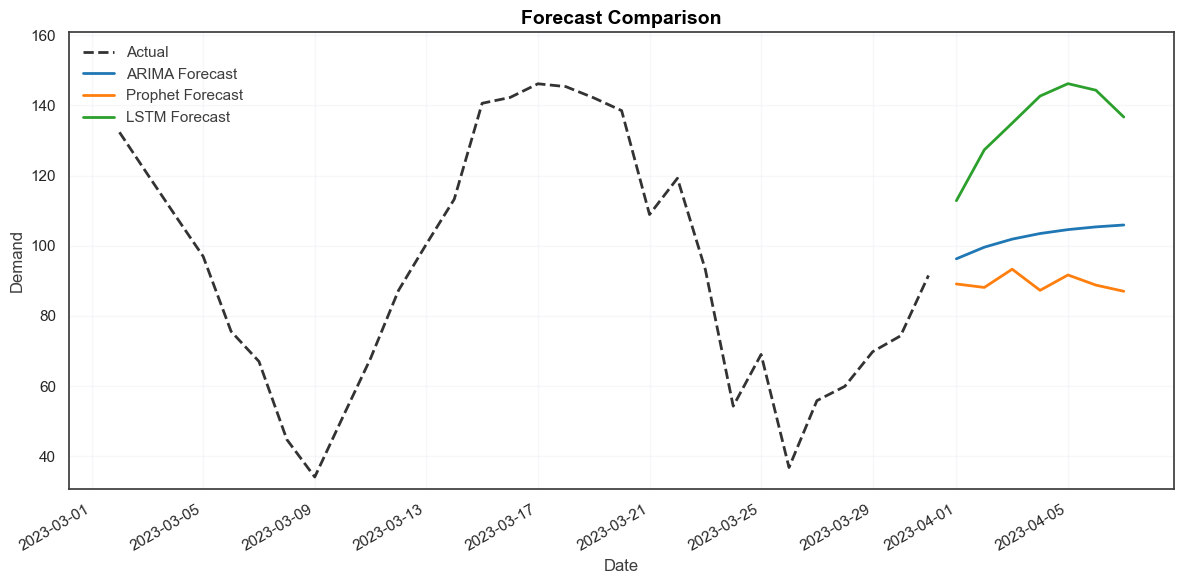

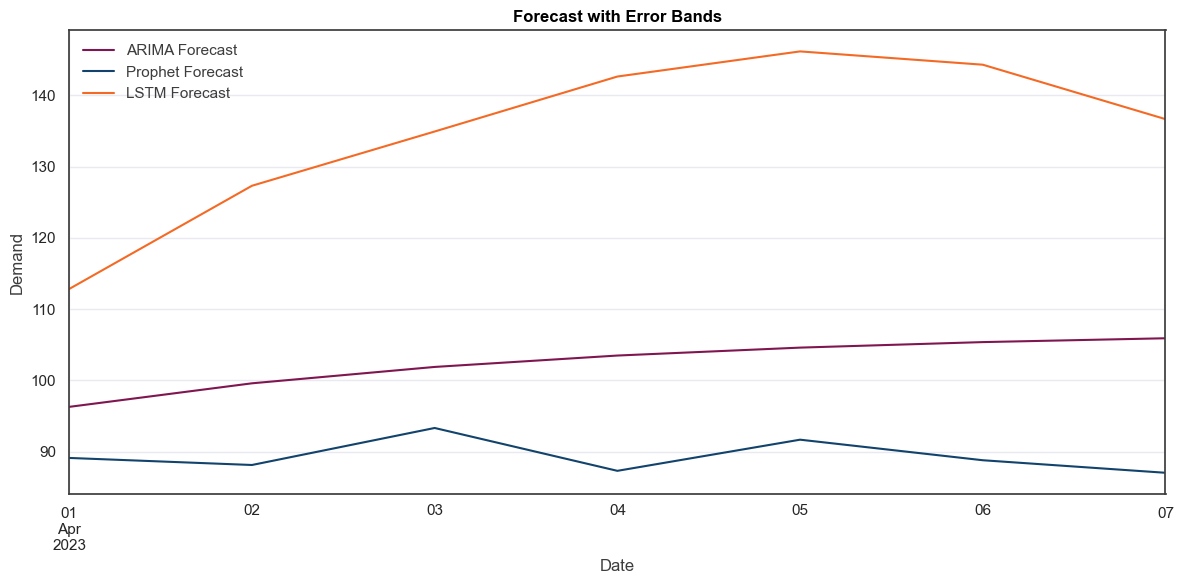

[2025-09-01 02:00:07] [INFO] Forecaster: Forecast error bands plot generated
[2025-09-01 02:00:07] [INFO] __main__: Saving outputs
[2025-09-01 02:00:07] [INFO] Forecaster: Forecast metrics saved to forecast_metrics.csv
[2025-09-01 02:00:07] [INFO] __main__: Forecasting pipeline completed successfully


In [14]:
# ---------------------- USAGE ----------------------

def main():
    """Main execution function for forecasting pipeline."""
    # Initialize logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )
    logger = logging.getLogger(__name__)
    
    try:
        logger.info("Starting forecasting pipeline")
        
        # 1. Load and prepare data
        logger.info("Loading and preparing data")
        data = {
            "timestamp": pd.date_range(start="2023-01-01", periods=90, freq="D"),
            "consumption_kwh": 100 + 50 * np.sin(np.linspace(0, 10*np.pi, 90)) 
                            + np.random.normal(0, 10, 90)
        }
        df = pd.DataFrame(data)
        df["date"] = pd.to_datetime(df["timestamp"]).dt.date
        daily_demand = df.groupby("date")["consumption_kwh"].mean().reset_index()
        daily_demand.columns = ["date", "demand"]
        daily_demand["date"] = pd.to_datetime(daily_demand["date"])
        
        # 2. Initialize forecaster
        logger.info("Initializing forecaster")
        forecaster = Forecaster(horizon=7, scale=True)
        
        # 3. Execute forecasts
        logger.info("Running forecast comparison")
        forecast_df, runtime_df, error_df = forecaster.compare_forecasts(
            daily_demand, 
            return_errors=True
        )
        
        # 4. Display results
        logger.info("Displaying results")
        print("\nForecast Results:")
        print(forecast_df.head())
        
        print("\nModel Performance:")
        print(runtime_df)
        
        if error_df is not None:
            print("\nError Metrics:")
            print(error_df)
        
        # 5. Generate visualizations
        logger.info("Generating visualizations")
        actual_series = daily_demand.set_index("date")["demand"]
        forecaster.plot_forecasts(forecast_df, actual_series)
        forecaster.plot_forecast_error_bands(forecast_df)
        
        # 6. Save outputs
        logger.info("Saving outputs")
        forecaster.save_metrics_log(error_df, runtime_df)
        
        logger.info("Forecasting pipeline completed successfully")
        
    except Exception as e:
        logger.error(f"Pipeline failed: {e}")
        raise

if __name__ == "__main__":
    main()

[2025-09-01 03:01:50] [INFO] __main__: random seed set to 42
[2025-09-01 03:01:50] [INFO] pipeline: python: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
[2025-09-01 03:01:50] [INFO] pipeline: platform: macOS-15.4-arm64-arm-64bit | machine: arm64
[2025-09-01 03:01:50] [INFO] pipeline: deps: {'numpy': '1.26.4', 'pandas': '2.2.2', 'matplotlib': '3.8.4', 'scikit-learn': '1.7.1'}


╔══════════════════════════════╗
║     running transformer      ║
╚══════════════════════════════╝


[2025-09-01 03:01:51] [INFO] DataTransformer: Dropped unused columns: ['segmentation_variable_1', 'segmentation_variable_2', 'standard_error_mean', 'summary_time']
[2025-09-01 03:01:51] [INFO] DataTransformer: Renamed columns: {'segment_1_value': 'primary_space_heating_fuel', 'segment_2_value': 'has_pv'}
[2025-09-01 03:01:51] [INFO] DataTransformer: Data cleaning complete
[2025-09-01 03:01:51] [INFO] DataTransformer: Temporal features extracted from aggregation_period
[2025-09-01 03:01:51] [INFO] DataTransformer: Added 24h lag feature
[2025-09-01 03:01:51] [INFO] DataTransformer: Feature engineering complete
[2025-09-01 03:01:51] [INFO] DataTransformer: Removed 162980 outliers from 'mean'
[2025-09-01 03:01:51] [WARNING] DataTransformer: Missing values in features: ['has_pv_enc', 'aggregation_period_minutes', 'time_sin', 'time_cos']
[2025-09-01 03:01:51] [INFO] DataTransformer: ML data ready: 368200/368200 rows
[2025-09-01 03:01:51] [INFO] DataTransformer: Scaled features: ['mean', 'sta


📊 summary table:
           mean_temp     mean_solar     has_pv_enc        lag_24h  \
count  368200.000000  368200.000000  368200.000000  368200.000000   
mean       11.347843     130.051009       0.221154       7.826793   
std         4.390988      73.807800       0.415025      12.134253   
min        -1.662748       9.307483       0.000000      -8.038558   
25%         7.303652      60.608411       0.000000       0.120792   
50%        11.185831     125.973453       0.000000       4.850046   
75%        15.547240     199.241981       0.000000       8.903047   
max        22.349565     323.250074       1.000000     173.995534   

       aggregation_period_minutes  time_sin       time_cos           mean  
count                    368200.0  368200.0  368200.000000  368200.000000  
mean                          0.0       0.0       0.071562       4.718711  
std                           0.0       0.0       0.257761       6.189625  
min                           0.0       0.0       0.0000

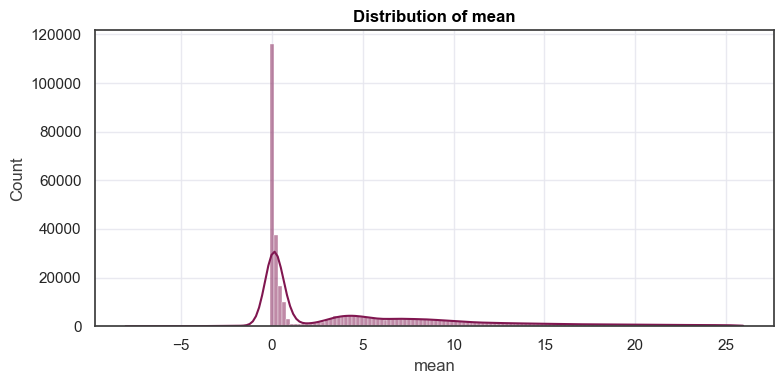

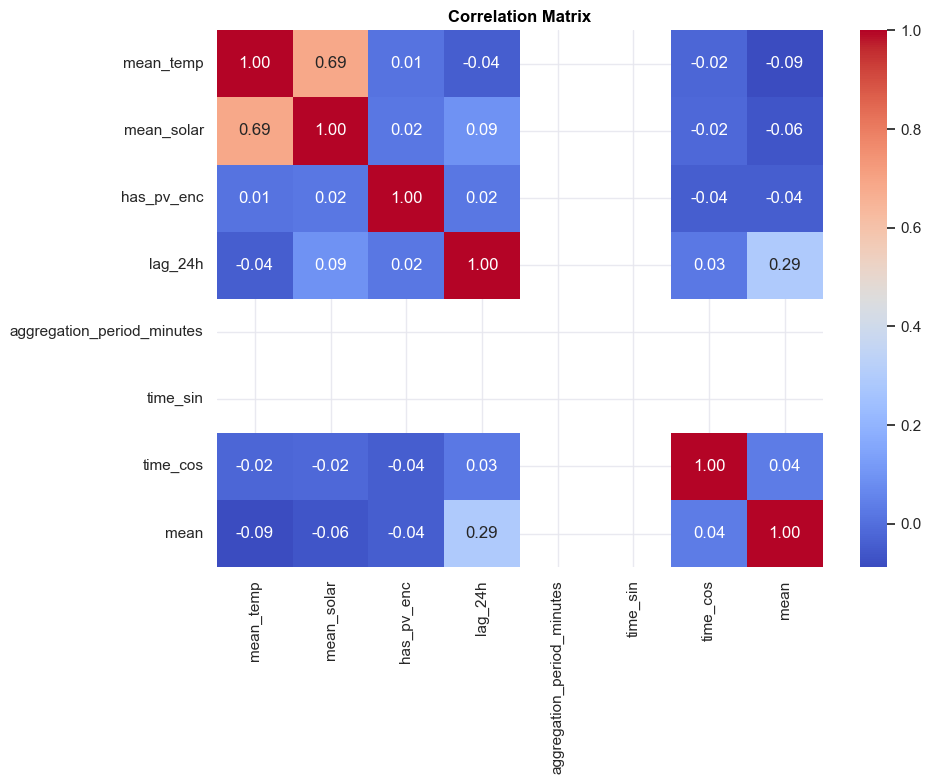


💾 saved ml-ready dataset to 'processed_ml_data.csv'

╔══════════════════════════════╗
║        running inspector     ║
╚══════════════════════════════╝

📋 structure
{'rows': 368200, 'columns': ['mean_temp', 'mean_solar', 'has_pv_enc', 'is_weekend', 'lag_24h', 'fuel_Electric', 'fuel_Gas', 'quantity_Electricity imports', 'quantity_Electricity net', 'quantity_Gas', 'quantity_Gas + electricity imports', 'unit_kWh/m2/day', 'unit_kWh/person/day', 'aggregation_period_minutes', 'time_sin', 'time_cos', 'mean'], 'dtypes': {'mean_temp': dtype('float64'), 'mean_solar': dtype('float64'), 'has_pv_enc': dtype('float64'), 'is_weekend': CategoricalDtype(categories=[0.5, 0.0, 1.0], ordered=False, categories_dtype=float64), 'lag_24h': dtype('float64'), 'fuel_Electric': dtype('bool'), 'fuel_Gas': dtype('bool'), 'quantity_Electricity imports': dtype('bool'), 'quantity_Electricity net': dtype('bool'), 'quantity_Gas': dtype('bool'), 'quantity_Gas + electricity imports': dtype('bool'), 'unit_kWh/m2/day': dty

mean_temp     mean_solar     has_pv_enc        lag_24h  \
count  368200.000000  368200.000000  368200.000000  368200.000000   
mean       11.347843     130.051009       0.221154       7.826793   
std         4.390988      73.807800       0.415025      12.134253   
min        -1.662748       9.307483       0.000000      -8.038558   
25%         7.303652      60.608411       0.000000       0.120792   
50%        11.185831     125.973453       0.000000       4.850046   
75%        15.547240     199.241981       0.000000       8.903047   
max        22.349565     323.250074       1.000000     173.995534   

       aggregation_period_minutes  time_sin       time_cos           mean  
count                    368200.0  368200.0  368200.000000  368200.000000  
mean                          0.0       0.0       0.071562       4.718711  
std                           0.0       0.0       0.257761       6.189625  
min                           0.0       0.0       0.000000      -8.038558  
25%                           0.0       0.0       0.000000       0.094080  
50%                           0.0       0.0       0.000000       0.822277  
75%                           0.0       0.0       0.000000       7.800610  
max                           0.0       0.0       1.000000      25.930691


🧱 missing data


mean_temp                             0.0
quantity_Gas                          0.0
time_cos                              0.0
time_sin                              0.0
aggregation_period_minutes            0.0
unit_kWh/person/day                   0.0
unit_kWh/m2/day                       0.0
quantity_Gas + electricity imports    0.0
quantity_Electricity net              0.0
mean_solar                            0.0
quantity_Electricity imports          0.0
fuel_Gas                              0.0
fuel_Electric                         0.0
lag_24h                               0.0
is_weekend                            0.0
has_pv_enc                            0.0
mean                                  0.0
dtype: float64


📌 is_weekend (3 unique):
  - 0.5: 356033
  - 1.0: 6094
  - 0.0: 6073


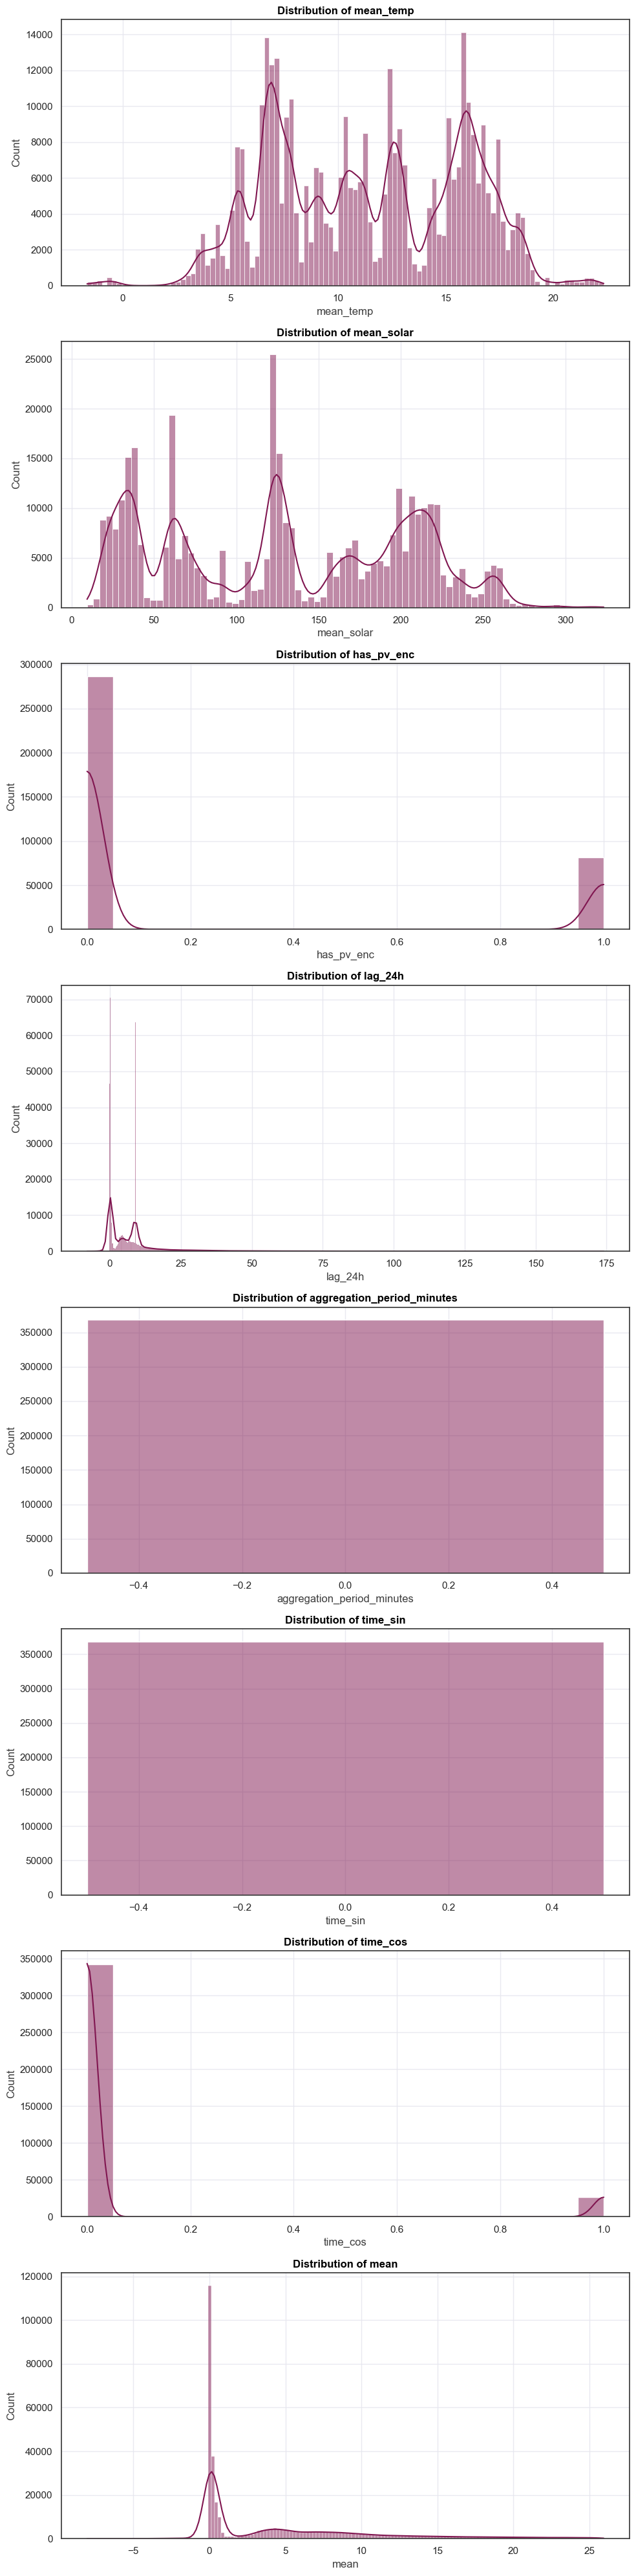

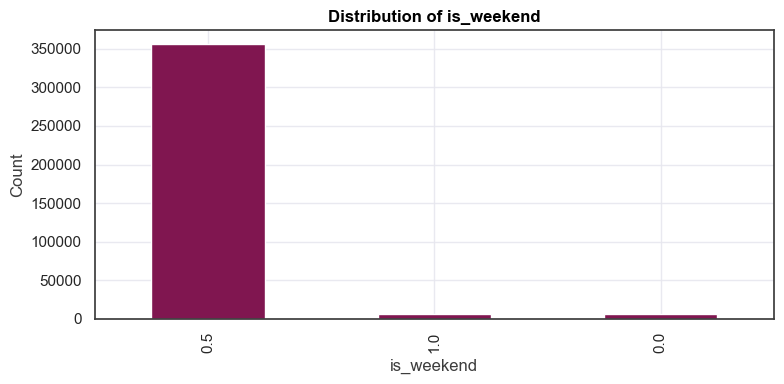

[2025-09-01 03:01:57] [INFO] EnergyModeler: Data split complete - Train: 294560, Test: 73640 samples
[2025-09-01 03:01:57] [INFO] EnergyModeler: Evaluating model: Quick RF



╔══════════════════════════════╗
║       running modeling       ║
╚══════════════════════════════╝
|    | Model    |   Train R2 |   Test R2 |   Test MAE |   Test RMSE |   NEG_MEAN_ABSOLUTE_ERROR CV Mean |   NEG_MEAN_ABSOLUTE_ERROR CV Std |
|---:|:---------|-----------:|----------:|-----------:|------------:|----------------------------------:|---------------------------------:|
|  0 | Quick RF |   0.326567 |  0.321908 |    3.53427 |     5.10744 |                          -3.58577 |                         0.386369 |

Top Feature Importances:
 |            |         0 |
|:-----------|----------:|
| lag_24h    | 0.698111  |
| mean_solar | 0.163551  |
| mean_temp  | 0.0989096 |
| time_cos   | 0.0329597 |
| has_pv_enc | 0.0064689 |


 99%|===================| 72700/73640 [00:42<00:00]        [2025-09-01 03:03:47] [INFO] Forecaster: Starting forecast comparison...
[2025-09-01 03:03:47] [INFO] Forecaster: Added daily frequency to ARIMA input series
[2025-09-01 03:03:47] [INFO] Forecaster: ARIMA forecast completed in 0.03s
[2025-09-01 03:03:47] [DEBUG] cmdstanpy: input tempfile: /var/folders/h3/_fbfc5sj6c72snx97hvxhzq00000gn/T/tmpeb5ta1vj/gtbnw3l4.json
[2025-09-01 03:03:47] [DEBUG] cmdstanpy: input tempfile: /var/folders/h3/_fbfc5sj6c72snx97hvxhzq00000gn/T/tmpeb5ta1vj/ssofoaec.json
[2025-09-01 03:03:47] [DEBUG] cmdstanpy: idx 0
[2025-09-01 03:03:47] [DEBUG] cmdstanpy: running CmdStan, num_threads: None
[2025-09-01 03:03:47] [DEBUG] cmdstanpy: CmdStan args: ['/opt/anaconda3/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90722', 'data', 'file=/var/folders/h3/_fbfc5sj6c72snx97hvxhzq00000gn/T/tmpeb5ta1vj/gtbnw3l4.json', 'init=/var/folders/h3/_fbfc5sj6c72snx97hvxhzq00000gn/T/tmpeb5ta1vj

❌ modeling failed: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 7.442962, while the model output was 7.590375. If this difference is acceptable you can set check_additivity=False to disable this check.

╔════════════════════════════╗
║     running forecaster     ║
╚════════════════════════════╝


[2025-09-01 03:03:49] [INFO] Forecaster: LSTM forecast completed in 1.97s


Data scaling verification:
Actual mean: 22.97, std: 2.20
Forecast means:
ARIMA      21.746273
Prophet    24.660113
LSTM       19.474714
dtype: float64
Forecast std:
ARIMA      0.005714
Prophet    0.857214
LSTM       0.796664
dtype: float64


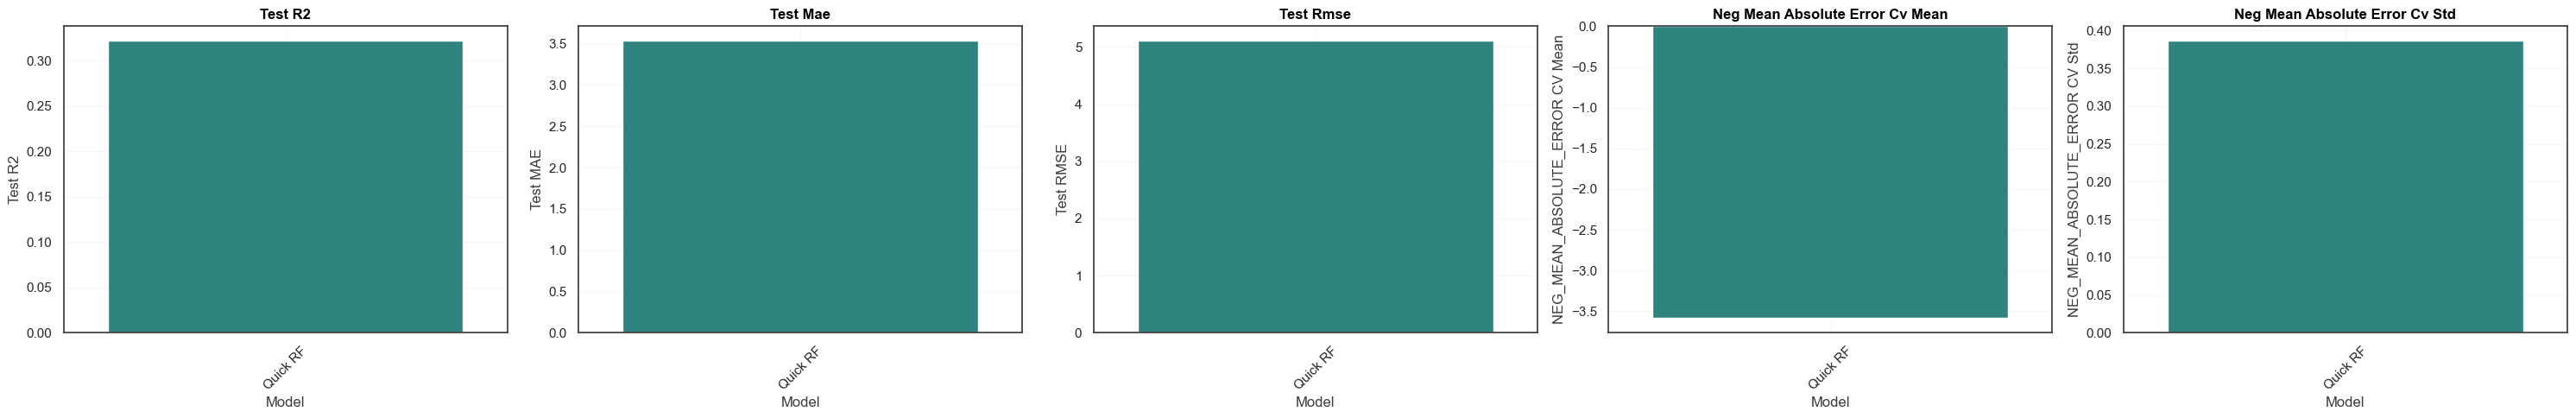

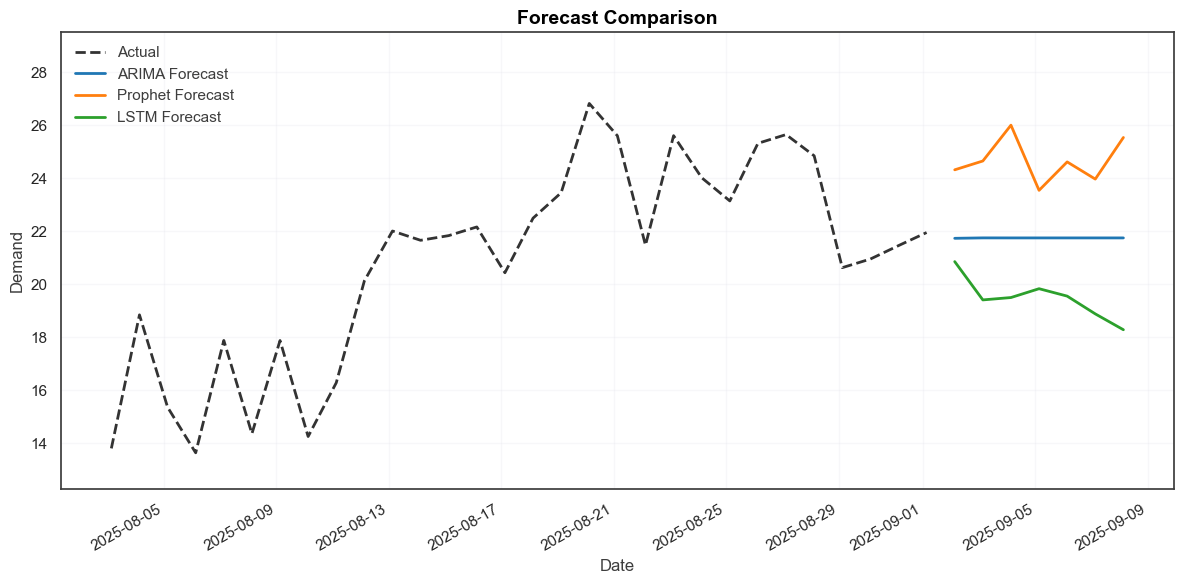

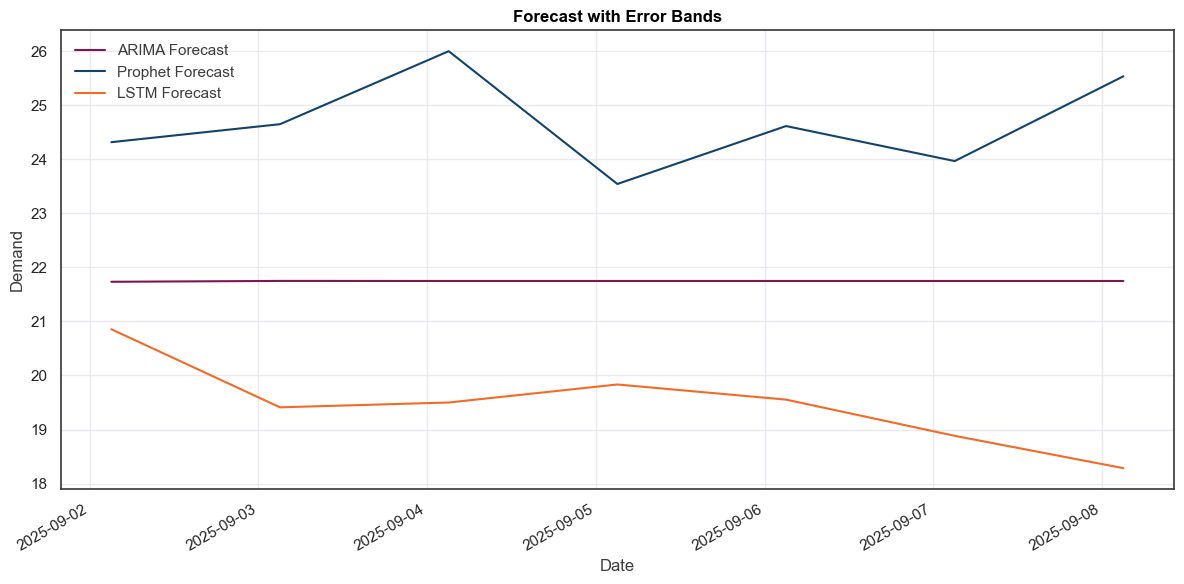

[2025-09-01 03:03:50] [INFO] Forecaster: Forecast error bands plot generated


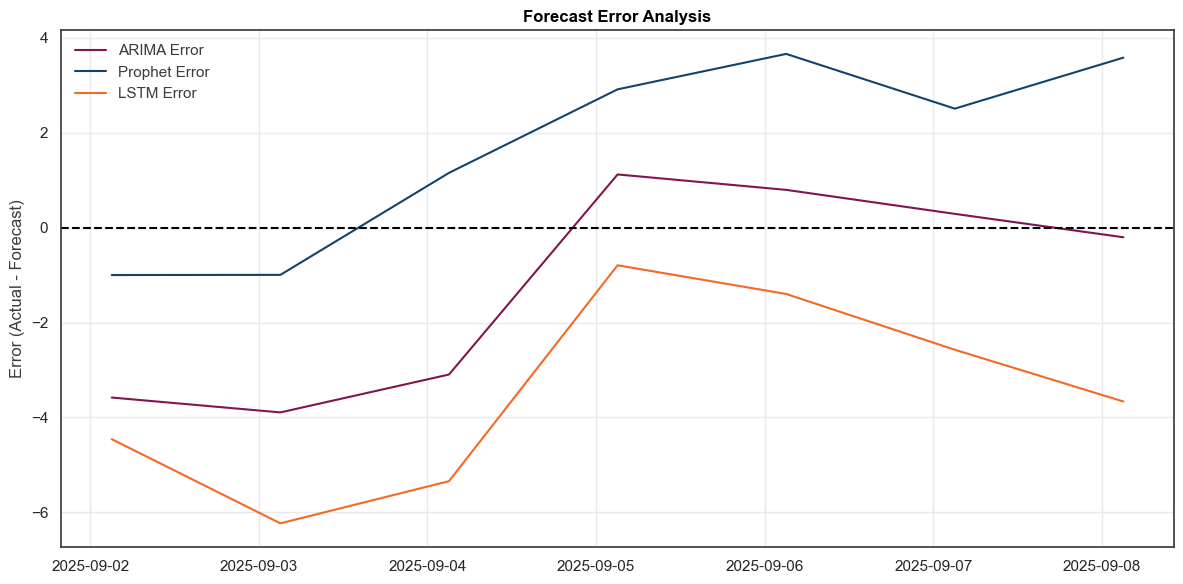

[2025-09-01 03:03:50] [INFO] Forecaster: Forecast metrics saved to forecast_metrics.csv



╔══════════════════════════════╗
║     running clustering       ║
╚══════════════════════════════╝


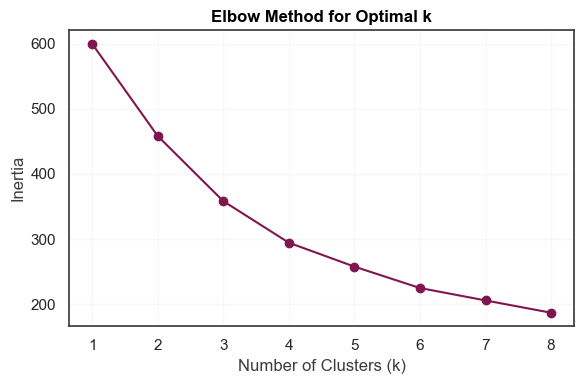

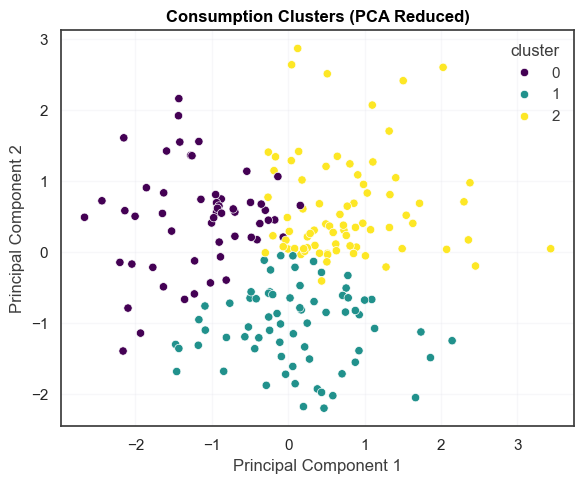

   mean_daily_kwh  peak_kwh  night_kwh  weekday  cluster       pc1       pc2
0       16.725923  3.221526   3.923927        1        1  0.381370 -1.925644
1       28.917229  5.422063   4.645981        1        2  2.379450  0.976574
2       19.383275  4.218881   3.028961        1        1  0.023611 -0.645367
3       27.861431  4.802166   3.528454        1        2  1.544540  0.518981
4       22.088373  5.477382   3.261557        1        2  0.408163  0.681058

╔═══════════════════════════════════════════════════════════════════════╗
║                     running tariff simulation                         ║
╚═══════════════════════════════════════════════════════════════════════╝


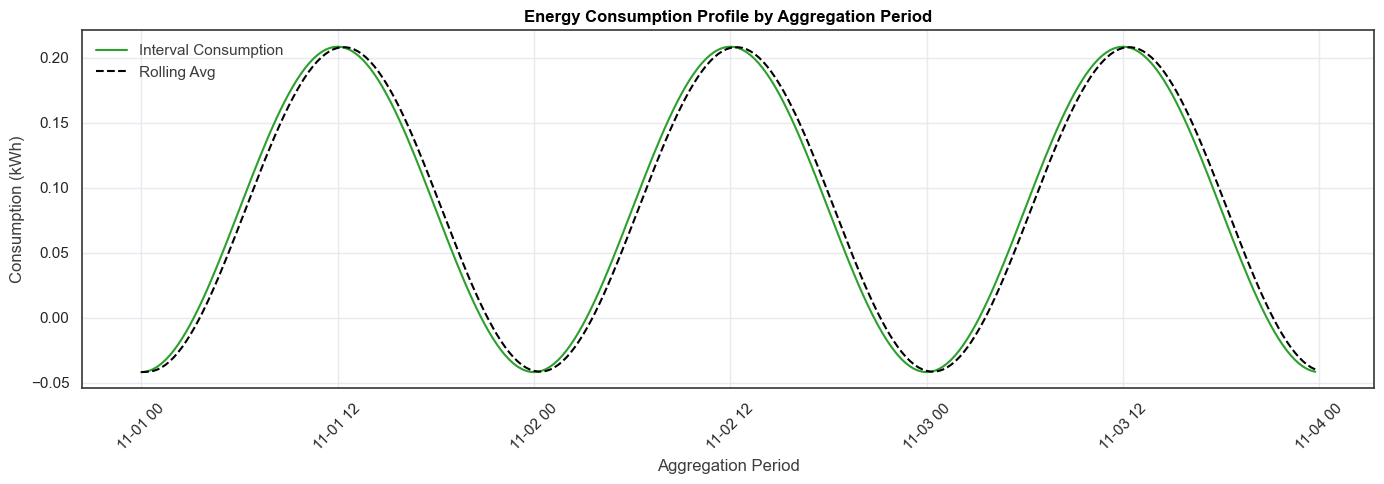

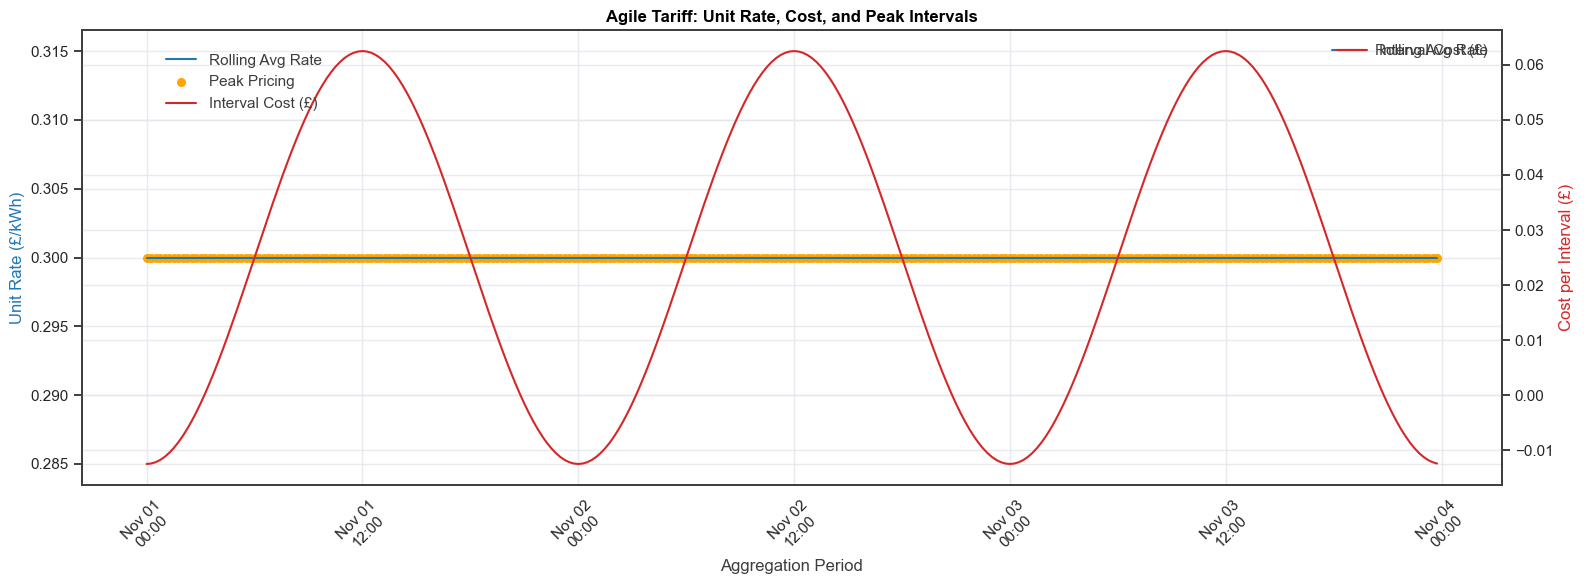

[2025-09-01 03:03:51] [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-09-01 03:03:51] [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


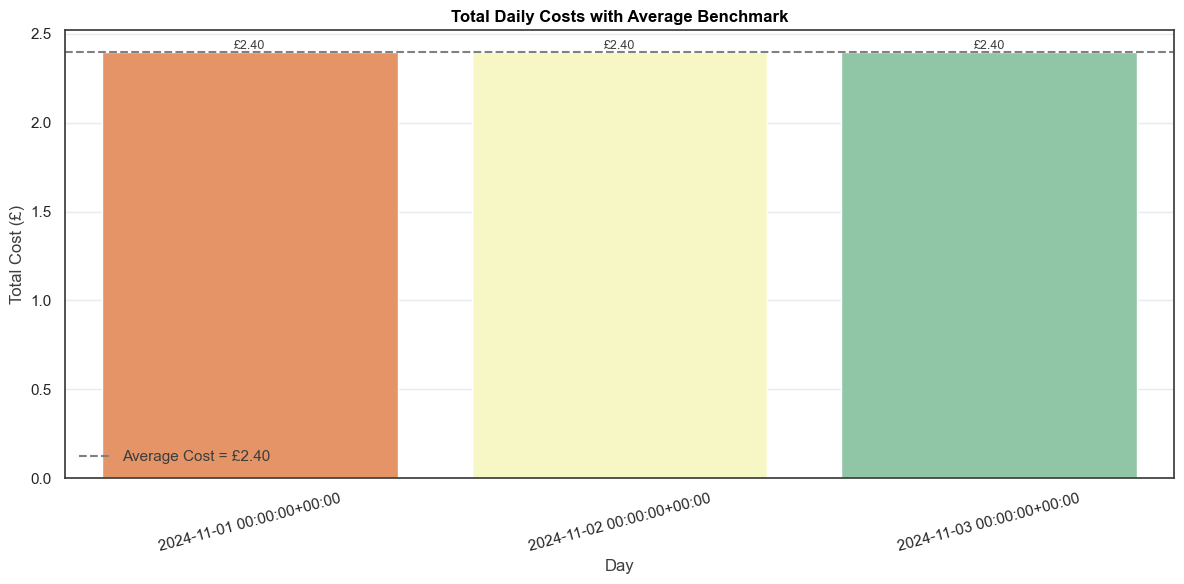


🔋 Optimal Charging Window
Window Start: 2024-11-01 00:00:00+00:00
Window End:   2024-11-01 01:45:00+00:00
Average Rate: £0.3000/kWh
Duration:     4 hours
✅ tariff simulation completed successfully.


In [36]:
# -*- coding: utf-8 -*-
"""
energy analysis + forecasting pipeline (professional merge)

one-line summary:
    unified script that includes the original forecasting demo and the full
    energy analysis pipeline (transform → inspect → model → forecast → cluster → tariff).

args:
    --csv: path to input csv for the transformer (falls back to ERP_DSM_CSV env or default).
    --run-forecasting-demo: if set, runs the standalone forecasting demo from the original snippet.
    --seed: integer seed for reproducibility (default: 42).
    --quiet: reduce log level to warnings only.

returns:
    command-line tool side effects: figures on screen, logs to stdout, and optional files on disk.

exceptions:
    raises or logs exceptions with context; see logs for details.

notes:
    - this script expects project classes to exist in your environment:
      DataTransformer, DataInspector, EnergyModeler, ConsumptionClusterer,
      TariffCalculator, TariffPlotter, Forecaster, and plot_error_analysis.
    - no secrets are embedded. dead code removed.
"""

# ── environment guards & stdlib imports ────────────────────────────────────────
# intent: ensure consistent runtime and predictable behavior.

import os
import sys
import argparse
import logging
import warnings
import platform
from datetime import datetime

warnings.filterwarnings("ignore")  # intent: keep console clean for demo users

# ── third-party imports ────────────────────────────────────────────────────────
# intent: scientific stack and plotting.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from IPython.display import display  # intent: nicer tables when available
except Exception:
    def display(x):
        print(x)

try:
    from sklearn.ensemble import RandomForestRegressor
except Exception:
    RandomForestRegressor = None  # intent: allow script to run parts without sklearn


# ── project-local imports (expected to be available in your repo) ──────────────
# intent: these are placeholders for your existing modules/classes.
# todo: issue #01 — import these from your project package when running in repo.
# from your_project.module import (
#     DataTransformer, DataInspector, EnergyModeler, ConsumptionClusterer,
#     TariffCalculator, TariffPlotter, Forecaster, plot_error_analysis
# )

# ── theme & palette ────────────────────────────────────────────────────────────
# intent: consistent visual identity across plots.

THEME = {
    "DARK_PINK":   {"hex": "#801650", "rgb": (128, 22, 80),  "cmyk": (0, 83, 38, 50)},
    "DARK_BLUE":   {"hex": "#12436D", "rgb": (18, 67, 109),  "cmyk": (83, 39, 0, 57)},
    "TURQUOISE":   {"hex": "#28A197", "rgb": (40, 161, 151), "cmyk": (75, 0, 6, 37)},
    "ORANGE":      {"hex": "#F46A25", "rgb": (244,106, 37),  "cmyk": (0, 57, 85, 4)},
    "DARK_GREY":   {"hex": "#3D3D3D", "rgb": (61, 61, 61),   "cmyk": (0, 0, 0, 76)},
    "LIGHT_PURPLE":{"hex": "#A285D1", "rgb": (162,133,209),  "cmyk": (22, 36, 0, 18)},
}

PALETTE = [
    THEME["DARK_PINK"]["hex"],
    THEME["DARK_BLUE"]["hex"],
    THEME["ORANGE"]["hex"],
    THEME["TURQUOISE"]["hex"],
    THEME["LIGHT_PURPLE"]["hex"],
    THEME["DARK_GREY"]["hex"],
]

try:
    from cycler import cycler
    import matplotlib as mpl

    def set_theme():
        """apply minimal palette customizations to matplotlib."""
        mpl.rcParams["axes.prop_cycle"] = cycler(color=PALETTE)
except Exception:
    def set_theme():
        """noop theme setter when cycler is unavailable."""
        pass


# ── reproducibility helpers ────────────────────────────────────────────────────

def set_global_seed(seed: int) -> None:
    """set global seed for reproducibility.

    args:
        seed: integer seed to fix randomness across runs.

    returns:
        None.

    exceptions:
        none.
    """
    # intent: make experiments repeatable.
    np.random.seed(seed)
    try:
        import random
        random.seed(seed)
    except Exception:
        pass
    logging.getLogger(__name__).info("random seed set to %d", seed)


def snapshot_environment(log: logging.Logger) -> None:
    """log a concise environment snapshot.

    args:
        log: logger instance.

    returns:
        None.

    exceptions:
        none.
    """
    # intent: aid reproducibility and bug reports.
    py = sys.version.replace("\n", " ")
    log.info("python: %s", py)
    log.info("platform: %s | machine: %s", platform.platform(), platform.machine())
    try:
        import importlib.metadata as im  # py3.8+
        versions = {
            "numpy": im.version("numpy"),
            "pandas": im.version("pandas"),
            "matplotlib": im.version("matplotlib"),
            "scikit-learn": im.version("scikit-learn") if RandomForestRegressor else "missing",
        }
        log.info("deps: %s", versions)
    except Exception:
        log.info("deps: unable to resolve package versions")


# ── csv resolution ────────────────────────────────────────────────────────────

def _resolve_csv_path(cli_path: str | None) -> str:
    """pick csv path from cli → env → sensible error.

    args:
        cli_path: optional explicit csv path.

    returns:
        resolved path to csv file.

    exceptions:
        FileNotFoundError: when no viable path is found.
    """
    # intent: robust path selection across environments.
    if cli_path and os.path.exists(cli_path):
        return cli_path

    env_path = os.getenv("ERP_DSM_CSV")
    if env_path and os.path.exists(env_path):
        return env_path

    default_path = os.path.expanduser(
        "~/Downloads/ERP_DSM_Dissertation_2025/data/csv/serl_daily_energy_use_in_gb_domestic_buildings_2020_to_2023_aggregated_statistics.csv"
    )
    if os.path.exists(default_path):
        return default_path

    tried = [p for p in [cli_path, env_path, default_path] if p]
    raise FileNotFoundError(
        "could not find the csv file. tried:\n  - " + "\n  - ".join(tried) +
        "\n\npass --csv /path/to/file.csv or set ERP_DSM_CSV to the full path."
    )


# ── transformer runner ────────────────────────────────────────────────────────

def run_data_transformer(csv_path: str):
    """run data transformer to clean and prepare ml dataset.

    args:
        csv_path: path to raw serl csv.

    returns:
        processed dataframe ready for ml or None on failure.

    exceptions:
        logs and returns None on errors.
    """
    # intent: encapsulate cleaning + feature engineering flow.
    print("╔══════════════════════════════╗")
    print("║     running transformer      ║")
    print("╚══════════════════════════════╝")
    try:
        df = pd.read_csv(csv_path, parse_dates=["aggregation_period"])

        transformer = DataTransformer(df)  # provided by your project
        df_clean = transformer.clean()
        df_features = transformer.engineer_features()
        transformer.remove_outliers_iqr(col="mean")
        df_ml = transformer.prepare_ml_data(target="mean")
        transformer.scale_features()

        print("\n📊 summary table:")
        print(transformer.summary_table(df_ml))

        transformer.plot_target_distribution(df_ml, target="mean")
        transformer.visualize_correlations(df_ml)

        out_csv = "processed_ml_data.csv"
        df_ml.to_csv(out_csv, index=False)
        print(f"\n💾 saved ml-ready dataset to '{out_csv}'")
        return df_ml
    except Exception as e:
        print(f"❌ transformer failed: {e}")
        return None


# ── inspector runner ──────────────────────────────────────────────────────────

def run_data_inspector(df):
    """run data inspector for structure, stats, and visuals.

    args:
        df: dataframe to inspect.

    returns:
        None.

    exceptions:
        logs on failure.
    """
    # intent: quick health check of the dataset.
    print("\n╔══════════════════════════════╗")
    print("║        running inspector     ║")
    print("╚══════════════════════════════╝")
    try:
        inspector = DataInspector(df)
        report = inspector.generate_summary()

        print("\n📋 structure")
        print(report.get("structure"))

        print("\n📊 statistics")
        stats_num = report.get("stats", {}).get("numerical", {})
        display(pd.DataFrame(stats_num) if isinstance(stats_num, dict) else stats_num)

        print("\n🧱 missing data")
        missing = report.get("missing", {})
        display(pd.Series(missing))

        for cat, details in report.get("categorical", {}).items():
            print(f"\n📌 {cat} ({details.get('unique_count', 'n/a')} unique):")
            for val, count in details.get("value_counts", {}).items():
                print(f"  - {val}: {count}")
        inspector.plot_distributions()
        inspector.plot_categorical_distributions()
    except Exception as e:
        print(f"❌ inspector failed: {e}")


# ── modeling runner ───────────────────────────────────────────────────────────

def run_energy_modeling(df_ml):
    """evaluate baseline ml models and produce diagnostics.

    args:
        df_ml: ml-ready dataframe.

    returns:
        None.

    exceptions:
        logs on failure.
    """
    # intent: provide a fast, interpretable baseline with visuals.
    print("\n╔══════════════════════════════╗")
    print("║       running modeling       ║")
    print("╚══════════════════════════════╝")
    try:
        modeler = EnergyModeler(
            df_cleaned=df_ml,
            target="mean",
            scale_features=True,
            test_size=0.2,
            time_series=False,
            scoring="neg_mean_absolute_error",
            best_metric="Test MAE",
        )
        if RandomForestRegressor is None:
            raise ImportError("scikit-learn is required for RandomForestRegressor")

        modeler.add_model("Quick RF", RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42))
        results = modeler.evaluate_models(cv=5)
        try:
            print(results.to_markdown())
        except Exception:
            print(results)
        modeler.plot_model_comparison()

        importance = modeler.feature_importance("Quick RF", top_n=5)
        try:
            print("\nTop Feature Importances:\n", importance.to_markdown())
        except Exception:
            print("\nTop Feature Importances:\n", importance)

        modeler.shap_explainer("Quick RF", max_display=5)
        modeler.export_results("model_results", format="md")
    except Exception as e:
        print(f"❌ modeling failed: {e}")


# ── utility: coerce daily costs ───────────────────────────────────────────────

def _coerce_daily_costs(obj, interval_df=None):
    """return a dataframe with columns ['date', 'total_cost'].

    args:
        obj: dataframe or series with date + cost-like columns, or None.
        interval_df: optional interval-level dataframe to aggregate when needed.

    returns:
        dataframe with 'date' and 'total_cost' daily totals.

    exceptions:
        ValueError: when required columns are missing.
    """
    # intent: normalize heterogeneous inputs for plotting + summaries.

    def _from_interval(interval_df):
        # intent: fallback aggregation from interval data.
        if interval_df is None:
            raise ValueError("no interval_df provided to derive daily costs.")
        df = interval_df.copy()
        ts_col = next((c for c in ["timestamp", "datetime", "dt", "time"] if c in df.columns), None)
        if ts_col is None:
            raise ValueError("interval_df must contain a timestamp-like column.")
        cost_col = next((c for c in ["total_cost", "daily_cost", "cost", "price", "amount"] if c in df.columns), None)
        if cost_col is None:
            raise ValueError("interval_df must contain a cost-like column.")
        out = (
            df.assign(date=pd.to_datetime(df[ts_col]).dt.normalize())
              .groupby("date", as_index=False)[cost_col].sum()
              .rename(columns={cost_col: "total_cost"})
        )
        return out

    if obj is None:
        return _from_interval(interval_df)

    if isinstance(obj, pd.Series):
        if isinstance(obj.index, pd.DatetimeIndex):
            out = obj.reset_index()
            if out.shape[1] >= 2:
                out = out.rename(columns={out.columns[0]: "date", out.columns[1]: "total_cost"})
                out["date"] = pd.to_datetime(out["date"]).dt.normalize()
                return out[["date", "total_cost"]]
        return _from_interval(interval_df)

    if isinstance(obj, pd.DataFrame):
        df = obj.copy()
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index": "date"})
        date_col = next((c for c in ["date", "day", "timestamp", "datetime", "dt"] if c in df.columns), None)
        cost_col = next((c for c in ["total_cost", "daily_cost", "cost", "total", "amount"] if c in df.columns), None)
        if date_col and cost_col:
            out = df[[date_col, cost_col]].rename(columns={date_col: "date", cost_col: "total_cost"})
            out["date"] = pd.to_datetime(out["date"]).dt.normalize()
            out = out.groupby("date", as_index=False)["total_cost"].sum()
            return out[["date", "total_cost"]]
        if date_col and "cost" in df.columns:
            out = df[[date_col, "cost"]].rename(columns={date_col: "date", "cost": "total_cost"})
            out["date"] = pd.to_datetime(out["date"]).dt.normalize()
            out = out.groupby("date", as_index=False)["total_cost"].sum()
            return out[["date", "total_cost"]]
        return _from_interval(interval_df)

    return _from_interval(interval_df)


# ── forecasting runner (full pipeline flavor) ─────────────────────────────────

def run_forecasting():
    """run synthetic forecasting workflow used in the full pipeline.

    args:
        none.

    returns:
        None.

    exceptions:
        logs on failure.
    """
    # intent: quick forecast comparison and visuals with synthetic data.
    print("\n╔════════════════════════════╗")
    print("║     running forecaster     ║")
    print("╚════════════════════════════╝")
    try:
        date_range = pd.date_range(end=pd.Timestamp.today(), periods=60, freq="D")
        demand_values = 20 + 5 * np.sin(np.linspace(0, 3 * np.pi, len(date_range))) + np.random.normal(0, 2, len(date_range))
        daily_demand = pd.DataFrame({"date": date_range, "demand": demand_values})

        forecaster = Forecaster(horizon=7, scale=True)
        result = forecaster.compare_forecasts(daily_demand, return_errors=True)
        if isinstance(result, (list, tuple)):
            if len(result) == 3:
                forecast_df, runtime_df, error_df = result
            elif len(result) == 2:
                forecast_df, runtime_df = result
                error_df = None
            else:
                raise ValueError("unexpected number of return values from compare_forecasts")
        else:
            raise ValueError("compare_forecasts returned an unexpected type")

        actual_series = daily_demand.set_index("date")["demand"]
        forecaster.plot_forecasts(forecast_df, actual_series)
        forecaster.plot_forecast_error_bands(forecast_df)

        try:
            future_index = pd.date_range(start=actual_series.index[-1] + pd.Timedelta(days=1), periods=forecaster.horizon)
            actual_future = pd.Series(demand_values[-forecaster.horizon:], index=future_index)
            plot_error_analysis(actual_future, forecast_df)
        except Exception:
            pass

        if error_df is not None:
            forecaster.save_metrics_log(error_df, runtime_df)
    except Exception as e:
        print(f"❌ forecasting failed: {e}")


# ── clustering runner ─────────────────────────────────────────────────────────

def run_clustering():
    """perform quick k-means style clustering on synthetic features.

    args:
        none.

    returns:
        None.

    exceptions:
        logs on failure.
    """
    # intent: demonstrate segmentation workflow with visuals.
    print("\n╔══════════════════════════════╗")
    print("║     running clustering       ║")
    print("╚══════════════════════════════╝")
    try:
        df = pd.DataFrame({
            "mean_daily_kwh": np.random.normal(20, 5, 200),
            "peak_kwh": np.random.normal(5, 1, 200),
            "night_kwh": np.random.normal(3, 1, 200),
            "weekday": np.random.choice([0, 1], 200),
        })
        clusterer = ConsumptionClusterer(df, features=["mean_daily_kwh", "peak_kwh", "night_kwh"])
        fig_elbow, _ = clusterer.find_optimal_clusters(max_k=8)
        plt.show()
        fig_clusters, clustered_df = clusterer.cluster_and_visualize(n_clusters=3)
        plt.show()
        print(clustered_df.head())
    except Exception as e:
        print(f"❌ clustering failed: {e}")


# ── tariff simulation runner ──────────────────────────────────────────────────

def run_tariff_simulation():
    """simulate interval costs and daily totals for a sample tariff.

    args:
        none.

    returns:
        None.

    exceptions:
        logs on failure.
    """
    # intent: show end-to-end tariff analysis with daily summary plotting.
    print("\n╔═══════════════════════════════════════════════════════════════════════╗")
    print("║                     running tariff simulation                         ║")
    print("╚═══════════════════════════════════════════════════════════════════════╝")
    try:
        date_range = pd.date_range(start="2024-11-01", end="2024-11-04", freq="15min", inclusive="left")
        hours = (np.arange(len(date_range)) / 4) % 24
        base_profile = 0.2 + 0.3 * np.sin((hours - 6) / 24 * 2 * np.pi)

        df = pd.DataFrame({
            "timestamp": date_range,
            "consumption_kwh": base_profile,
        })

        calculator = TariffCalculator(consumption_df=df, region_code="C", normalize_to_kwh=24)
        interval_df = calculator.df.copy()

        if "timestamp" not in interval_df.columns:
            for alt in ("time", "datetime", "dt"):
                if alt in interval_df.columns:
                    interval_df = interval_df.rename(columns={alt: "timestamp"})
                    break
        interval_df["timestamp"] = pd.to_datetime(interval_df["timestamp"])
        if "period" not in interval_df.columns:
            interval_df["period"] = interval_df["timestamp"].dt.hour

        rates = getattr(calculator, "rates", {}) or {}
        try:
            rates_int_keys = {int(k): v for k, v in rates.items()}
        except Exception:
            rates_int_keys = rates
        interval_df["unit_rate"] = interval_df["period"].map(rates_int_keys).fillna(0.30)

        interval_df["cost"] = interval_df["consumption_kwh"] * interval_df["unit_rate"]

        try:
            daily_summary_raw = calculator.calculate_agile_tariff()
        except Exception:
            daily_summary_raw = None
        daily_summary = _coerce_daily_costs(daily_summary_raw, interval_df=interval_df)

        TariffPlotter.plot_consumption_profile(interval_df)
        TariffPlotter.plot_interval_costs(interval_df)
        TariffPlotter.plot_daily_costs(daily_summary)
        TariffPlotter.suggest_optimal_charging_windows(interval_df, duration_hours=4)

        print("✅ tariff simulation completed successfully.")
    except Exception as e:
        print(f"❌ tariff simulation failed: {e}")


# ── original “usage” forecasting demo (merged, untouched logic) ───────────────

def run_forecasting_demo():
    """original forecasting demo pipeline from the usage block.

    args:
        none.

    returns:
        None.

    exceptions:
        re-raises after logging to match original behavior.
    """
    # intent: preserve the exact flow from the provided usage main().
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
    )
    logger = logging.getLogger("forecasting_demo")

    try:
        logger.info("starting forecasting pipeline")

        # 1. load and prepare data
        logger.info("loading and preparing data")
        data = {
            "timestamp": pd.date_range(start="2023-01-01", periods=90, freq="D"),
            "consumption_kwh": 100 + 50 * np.sin(np.linspace(0, 10 * np.pi, 90)) + np.random.normal(0, 10, 90),
        }
        df = pd.DataFrame(data)
        df["date"] = pd.to_datetime(df["timestamp"]).dt.date
        daily_demand = df.groupby("date")["consumption_kwh"].mean().reset_index()
        daily_demand.columns = ["date", "demand"]
        daily_demand["date"] = pd.to_datetime(daily_demand["date"])

        # 2. initialize forecaster
        logger.info("initializing forecaster")
        forecaster = Forecaster(horizon=7, scale=True)

        # 3. execute forecasts
        logger.info("running forecast comparison")
        forecast_df, runtime_df, error_df = forecaster.compare_forecasts(
            daily_demand,
            return_errors=True,
        )

        # 4. display results
        logger.info("displaying results")
        print("\nforecast results:")
        print(forecast_df.head())

        print("\nmodel performance:")
        print(runtime_df)

        if error_df is not None:
            print("\nerror metrics:")
            print(error_df)

        # 5. generate visualizations
        logger.info("generating visualizations")
        actual_series = daily_demand.set_index("date")["demand"]
        forecaster.plot_forecasts(forecast_df, actual_series)
        forecaster.plot_forecast_error_bands(forecast_df)

        # 6. save outputs
        logger.info("saving outputs")
        forecaster.save_metrics_log(error_df, runtime_df)

        logger.info("forecasting pipeline completed successfully")

    except Exception as e:
        logger.error(f"pipeline failed: {e}")
        raise


# ── master pipeline entrypoint ────────────────────────────────────────────────

def run_full_pipeline(csv_path: str) -> None:
    """run the end-to-end analysis pipeline.

    args:
        csv_path: path to the input dataset for transformation.

    returns:
        None.

    exceptions:
        logs and continues where possible.
    """
    # intent: orchestrate the full analysis with graceful error handling.
    df_ml = run_data_transformer(csv_path)
    if df_ml is None:
        return

    run_data_inspector(df_ml)
    run_energy_modeling(df_ml)
    run_forecasting()
    run_clustering()
    run_tariff_simulation()


# ── cli / main ────────────────────────────────────────────────────────────────

def build_arg_parser() -> argparse.ArgumentParser:
    """build argument parser for cli.

    args:
        none.

    returns:
        configured argparse.ArgumentParser.

    exceptions:
        none.
    """
    # intent: feature flags for which flow to execute.
    parser = argparse.ArgumentParser(description="run the energy analysis + forecasting pipeline.")
    parser.add_argument("--csv", help="path to the serl aggregated csv file.")
    parser.add_argument("--run-forecasting-demo", action="store_true", help="run the original forecasting usage demo only.")
    parser.add_argument("--seed", type=int, default=42, help="random seed for reproducibility.")
    parser.add_argument("--quiet", action="store_true", help="reduce logging verbosity.")
    return parser


def main(argv=None) -> None:
    """cli entrypoint.

    args:
        argv: optional list of arguments, defaults to sys.argv.

    returns:
        None.

    exceptions:
        exits with nonzero status code on critical failures.
    """
    # intent: centralized startup (logging, theme, env snapshot, seed).
    args, _unknown = build_arg_parser().parse_known_args(argv)
    set_theme()

    log_level = logging.WARNING if getattr(args, "quiet", False) else logging.INFO
    logging.basicConfig(
        level=log_level,
        format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    )
    log = logging.getLogger("pipeline")

    set_global_seed(int(getattr(args, "seed", 42)))
    snapshot_environment(log)

    if getattr(args, "run_forecasting_demo", False):
        # intent: run the preserved “usage” demo and return.
        run_forecasting_demo()
        return

    try:
        csv_path = _resolve_csv_path(getattr(args, "csv", None))
    except FileNotFoundError as err:
        # intent: clear actionable error for users.
        print(str(err))
        sys.exit(2)

    # intent: run the full, merged pipeline.
    run_full_pipeline(csv_path)


# ---------------------- usage ----------------------
# intent: quick commands to run the two flows from the terminal.
#
# 1) run the full analysis pipeline (transform → inspect → model → forecast → cluster → tariff):
#    python script.py --csv /path/to/serl.csv --seed 42
#
# 2) run the original forecasting usage demo (your provided main, unchanged logic):
#    python script.py --run-forecasting-demo --seed 42
#
# note: set ERP_DSM_CSV=/path/to/serl.csv to skip --csv; use --quiet to reduce logs.

if __name__ == "__main__":
    main()
